In [1]:
import time
import pickle
from os import listdir
from os.path import isfile, join

import numpy as np
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.10Ef' % x)
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mean

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_validate
from sklearn.decomposition import PCA

from impyute.imputation import cs
pd.options.display.float_format = '{:20,.15f}'.format

from pprint import pprint

import copy
from sklearn.ensemble import ExtraTreesRegressor

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.initializers import GlorotNormal, GlorotUniform, he_normal, he_uniform
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras import backend as K
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

from hyperopt import Trials, STATUS_OK, tpe, rand
from hyperas import optim
from hyperas.distributions import choice, uniform

In [2]:
pd.set_option('display.max_columns', None)  

In [99]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
class Process:
    def __init__(self, 
                 X_train, X_test, X_val, y_train, y_test, y_val, 
                 imputer='mean', 
                 minmaxrange=(-1,1), 
                 standardize_X=True,
                 standardize_y=True,
                 robust_range=(10, 90),
                ):
        self.y_process = []
        self.X_train = X_train.copy()
        self.X_test = X_test.copy()
        self.X_val = X_val.copy()
        self.y_train = y_train.copy().values.reshape(-1, 1)
        self.y_test = y_test.copy().values.reshape(-1, 1)
        self.y_val = y_val.copy().values.reshape(-1, 1)
        self.imputer = imputer
        self.X_minmaxscaler = MinMaxScaler(feature_range=minmaxrange)
        self.y_minmaxscaler = MinMaxScaler(feature_range=minmaxrange)
        self.y_robust_scaler = RobustScaler(quantile_range=robust_range)
        self.X_robust_scaler = RobustScaler(quantile_range=robust_range)
        self.skewer_X = PowerTransformer(standardize=standardize_X)
        self.skewer_y = PowerTransformer(standardize=standardize_y)

    def fill_nan(self):
        def fill_train_test(imputer):
            imputer.fit(self.X_train)
            self.X_train[:] = imputer.transform(self.X_train)
            self.X_test[:] = imputer.transform(self.X_test)
            self.X_val[:] = imputer.transform(self.X_val)

        if (self.imputer == 'mean'):
            fill_train_test(SimpleImputer(strategy='mean'))
        elif (self.imputer == 'median'):
            fill_train_test(SimpleImputer(strategy='median'))
        elif (self.imputer == 'knn'):
            fill_train_test(KNNImputer())
        elif (self.imputer == 'iterative'):
            fill_train_test(IterativeImputer(verbose=0, max_iter=50))
        elif (self.imputer == 'iterative_mlp'):
            fill_train_test(
                IterativeImputer(
                    estimator=MLPRegressor(learning_rate='adaptive', random_state=0),
                    verbose=2,
                )
            )
        return self
        
    def minmaxscale_X(self):
        self.X_minmaxscaler.fit(self.X_train)
        self.X_train[:] = self.X_minmaxscaler.transform(self.X_train)
        self.X_test[:] = self.X_minmaxscaler.transform(self.X_test)
        self.X_val[:] = self.X_minmaxscaler.transform(self.X_val)
        return self
    
    def minmaxscale_X_inverse(self, data):
        return self.X_minmaxscaler.inverse_transform(data)
    
    def minmaxscale_Y(self, inverse=False):
        self.y_minmaxscaler.fit(self.y_train)
        self.y_train[:] = self.y_minmaxscaler.transform(self.y_train)
        self.y_test[:] = self.y_minmaxscaler.transform(self.y_test)
        self.y_val[:] = self.y_minmaxscaler.transform(self.y_val)
        self.y_process.append(self.minmaxscale_Y_inverse)
        return self
    
    def minmaxscale_Y_inverse(self, data): # data is in 1d array
        return self.y_minmaxscaler.inverse_transform(data.reshape(-1, 1)).flatten()
    
    def robustscale_X(self):
        self.X_robust_scaler.fit(self.X_train)
        self.X_train[:] = self.X_robust_scaler.transform(self.X_train)
        self.X_test[:] = self.X_robust_scaler.transform(self.X_test)
        self.X_val[:] = self.X_robust_scaler.transform(self.X_val)
        return self
    
    def robustscale_X_inverse(self, data):
        return self.X_robust_scaler.inverse_transform(data)
    
    def robustscale_Y(self, inverse=False):
        self.y_robust_scaler.fit(self.y_train)
        self.y_train[:] = self.y_robust_scaler.transform(self.y_train)
        self.y_test[:] = self.y_robust_scaler.transform(self.y_test)
        self.y_val[:] = self.y_robust_scaler.transform(self.y_val)
        self.y_process.append(self.robustscale_Y_inverse)
        return self
    
    def robustscale_Y_inverse(self, data): # data is in 1d array
        return self.y_robust_scaler.inverse_transform(data.reshape(-1, 1)).flatten()
    
    def skew_X(self, inverse=False):
        self.skewer_X.fit(self.X_train)
        self.X_train[:] = self.skewer_X.transform(self.X_train)
        self.X_test[:] = self.skewer_X.transform(self.X_test)
        self.X_val[:] = self.skewer_X.transform(self.X_val)
        return self
    
    def skew_X_inverse(self, data):
        return self.skewer_X.inverse_transform(data)
    
    def skew_y(self):
        self.skewer_y.fit(self.y_train)
        self.y_train = self.skewer_y.transform(self.y_train)
        self.y_test = self.skewer_y.transform(self.y_test)
        self.y_val = self.skewer_y.transform(self.y_val)
        self.y_process.append(self.skew_y_inverse)
        return self

    def skew_y_inverse(self, data): # data is 1d ndarray
        return self.skewer_y.inverse_transform(data.reshape(-1, 1)).flatten()

    def return_processed(self):
        return self.X_train, self.X_test, self.X_val, self.y_train.flatten(), self.y_test.flatten(), self.y_val.flatten()      

In [4]:
def get_metrics(y_test, y_pred, cols):
    SS_Residual = sum((y_test - y_pred)**2)
    SS_Total = sum((y_test - np.mean(y_test))**2)
    r2 = 1 - (float(SS_Residual))/SS_Total
    adj_r2 = 1 - (1-r2)*(len(y_test) - 1)/(len(y_test) - cols -1)
    return  {
        'mape': np.mean(np.abs((y_test - y_pred)/y_test)) * 100,
        'mae': metrics.mean_absolute_error(y_test, y_pred),
        'rmse': np.sqrt(metrics.mean_squared_error(y_test, y_pred)),
        'adj_r2': adj_r2,
    }

def print_metrics(data, y_test, y_pred, cols):
    print(data)
    res = get_metrics(y_test, y_pred, cols)
    for key in res:
        print(f'{key}: {res[key]:,.3f}')
    return res


def predict(model, model_name, X_train, y_train, X_test, y_test):
    pred_train = model.predict(X_train.values)
    pred_test = model.predict(X_test.values)
    if len(pred_train.shape) == 2 and pred_train.shape[1] == 1:
        pred_train = pred_train.flatten()
        pred_test = pred_test.flatten()
    return {
        'res': {
            'train': print_metrics('train', y_train, pred_train, X_train.shape[1]),
            'test': print_metrics('test', y_test, pred_test, X_test.shape[1]),
        },
        'predictions':{
            'train': pred_train,
            'test': pred_test,
        },
        'actual': {
            'train': y_train,
            'test': y_test,
        },
    }


def output_metrics(model, data, process, with_val=True):
    if with_val:  
        res = predict(model, "Keras NN", 
                       data['X_train'],  
                       data['y_train'],
                       data['X_val'],
                       data['y_val'])
    else:
        res = predict(model, "Keras NN", 
                       data['X_train'],  
                       data['y_train'],  
                       data['X_test'],
                       data['y_test'])

    y_actual_train_back = res['actual']['train']
    y_pred_train_back = res['predictions']['train']
    y_actual_test_back = res['actual']['test']
    y_pred_test_back = res['predictions']['test']
    
    print_sorted_actual_to_predicted_graphs(
        y_actual_train_back,
        y_pred_train_back,
        y_actual_test_back,
        y_pred_test_back)

    if process and process.y_process:
        for apply_function in reversed(process.y_process):
            y_actual_train_back = apply_function(y_actual_train_back)
            y_pred_train_back = apply_function(y_pred_train_back)
            y_actual_test_back = apply_function(y_actual_test_back)
            y_pred_test_back = apply_function(y_pred_test_back)

        print_metrics('train', y_actual_train_back, y_pred_train_back, data['X_train'].shape[1])
        print_metrics('test', y_actual_test_back, y_pred_test_back, data['X_test'].shape[1])
        print_sorted_actual_to_predicted_graphs(
            y_actual_train_back,
            y_pred_train_back,
            y_actual_test_back,
            y_pred_test_back, print_log=True)


def print_graphs(actual, predicted, title, print_log=False):
    length = len(actual)
    res_df = pd.DataFrame({'actual':actual, 'predicted': predicted}).astype(float)
    res_df.sort_values(by='actual', inplace=True)

    plt.figure()
    x = np.linspace(0, length, length)
    plt.plot(x, res_df['actual'], label='revenue actual')
    plt.plot(x, res_df['predicted'], label='revenue predicted')

    plt.ticklabel_format(useOffset=False, style='plain')
    plt.rcParams["figure.figsize"] = (8,8)
    if print_log:
        plt.yscale('log')
    plt.xlabel('movie')
    plt.ylabel('revenue')
    plt.title(title)
    plt.legend()
    plt.show()
    
def print_sorted_actual_to_predicted_graphs(train_real, train_pred, test_real, test_pred, print_log=False):
    if print_log:
        print_graphs(train_real, train_pred, 'train data: log scale', print_log=True)
        print_graphs(test_real, test_pred, 'validation data: log scale', print_log=True)
    print_graphs(train_real, train_pred, 'train data')
    print_graphs(test_real, test_pred, 'validation data')
    
# -----------------------------------------

def get_data():
    with open('proc_data_001.pickle', 'rb') as handle:
        d = pickle.load(handle)
        X_train = d['X_train']
        y_train = d['y_train']
        X_test = d['X_test']
        y_test = d['y_test']
        return X_train, y_train, X_test, y_test

In [102]:
path = 'datasets'
onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]
datasets = sorted([d for d in onlyfiles if not 'raw' in d and 'dataset' in d])

In [52]:
# cols_to_exclude = ['genre__western', 'genre__documentary', 'genre__history', 'country__es', 'country__jp', 'country__ca', 'country__de', 'country__in', 'country__fr', 'country__ru', 'country__it', 'country__au', 'rating__nc-17', 'country__other', 'tag__satire', 'tag__neo_noir', 'tag__sadist', 'tag__cruelty', 'tag__dark', 'tag__storytelling', 'tag__sci_fi', 'tag__psychological', 'tag__absurd', 'tag__philosophical', 'tag__depressing', 'tag__plot_twist', 'tag__realism', 'tag__home_movie', 'tag__thought_provoking']
# cols_to_exclude = [col for col in df.columns if (('budget' in col or 'profit' in col) and ('crew' in col or 'cast' in col))]

def split_process_df(name, train=0.8, test=0.1):
    def get_train_test_revenue(df):
        df['revenue'] = df['META__revenue']
        dff = df[[col for col in df.columns if not 'META' in col]]
        X = dff.drop(['revenue'], axis=1)
        y = dff['revenue']
        return X, y

    df_raw = pd.read_csv(f'datasets/{name}')
    # df_raw = reduce_mem_usage(df_raw)
    df = shuffle(df_raw, random_state=0)

    num_in_train = int(df.shape[0]*0.8)
    # num_in_test = int(df.shape[0]*0.1)
    num_in_test = int(df.shape[0]*0.1)
    df_train = df[:num_in_train].copy()
    df_test = df[num_in_train:num_in_train+num_in_test].copy()
    df_val = df[num_in_train+num_in_test:].copy()
    X_train, y_train = get_train_test_revenue(df_train)
    X_test, y_test = get_train_test_revenue(df_test)
    X_val, y_val = get_train_test_revenue(df_val)
    
    data = {}
    process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').skew_X().skew_y().fill_nan()
#     process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').skew_X().skew_y().robustscale_Y().fill_nan()
#     process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').skew_X().skew_y().robustscale_X().fill_nan()
#     process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').robustscale_X().robustscale_Y().skew_X().skew_y().fill_nan()
#     process = Process(X_train, X_test, X_val, y_train, y_test, y_val, imputer='knn').skew_X().skew_y().robustscale_X().robustscale_Y().fill_nan()
    data['X_train'], data['X_test'], data['X_val'], data['y_train'], data['y_test'], data['y_val'] = process.return_processed()
    return data, process

In [ ]:
for d_name in datasets:
    name = d_name.replace('.csv', '')
    if 'revenue' in name:
        print(f'processing {name}')
        data, process = split_process_df(d_name, train=0.8, test=0.1)

        with open(f'processed/{name}_data.pickle', 'wb') as handle:
            pickle.dump(data, handle)

        with open(f'processed/{name}_process.pickle', 'wb') as handle:
            pickle.dump(process, handle)

In [5]:
with open('processed/dataset_all_data.pickle', 'rb') as handle:
    data = pickle.load(handle)
    
with open('processed/dataset_all_process.pickle', 'rb') as handle:
    process = pickle.load(handle)

In [170]:
datasets

['dataset_all.csv',
 'dataset_budget_start_1percent.csv',
 'dataset_budget_start_5percent.csv',
 'dataset_gb.csv',
 'dataset_profitability_10percentile.csv',
 'dataset_profitability_1percentile.csv',
 'dataset_profitability_1percentile_years2000-2018.csv',
 'dataset_profitability_1percentile_years2000-2018_budget_start_1percent.csv',
 'dataset_profitability_1percentile_years2000-2018_budget_start_5percent.csv',
 'dataset_profitability_5percentile.csv',
 'dataset_profitability_negative.csv',
 'dataset_profitability_positive.csv',
 'dataset_revenue_1percentile.csv',
 'dataset_revenue_5percentile.csv',
 'dataset_us.csv',
 'dataset_years1970-1999.csv',
 'dataset_years2000-2018.csv']

In [ ]:
Datasets							Comment			Number of movies	% from all movies dataset
All movies										7495			100
US											5695			76
GB											893			12
Years 2000-2018										4903			65.4
Years 1970-1999										2042			27
Profitable movies										5107			68
Not profitable movies									2335			31
Budget after 1 percentile 					starts from 8875$			7418			99
Budget after 5 percentile 					starts from 250000$		7129			95
Profitability 1 percentile cut 				profitability range [-13.8, 65]	7342			98
Profitability 5 percentile cut					profitability range [-14.9, 13.9]	6744			90
Profitability 10 percentile cut				profitability range [-4.42, 7.4]	5994			80
Profitability 1 percentile cut for movies 2000-2018						4814			64.2
Profitability 1 percentile cut for movies 2000-2018 and budget 1%+				4754			63.4
Profitability 1 percentile cut for movies 2000-2018 and budget 5%+				4599			61.3
Revenue after 1 percentile					starts from 10000			7354			98
Revenue after 5 percentile					starts from 111229		6743			90


In [189]:
'dataset_all.csv'.replace('.csv', '')

'dataset_all'

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dataset_budget_start_1percent.csv
-----------------------------------------------
output LGBMRegressor
train
mape: 155.665
mae: 0.315
rmse: 0.405
adj_r2: 0.829
test
mape: 151.419
mae: 0.477
rmse: 0.629
adj_r2: 0.426


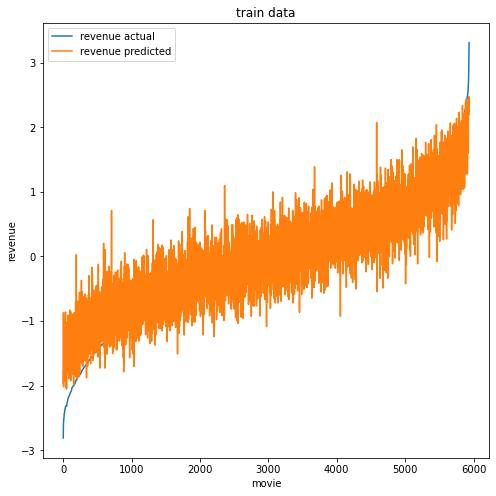

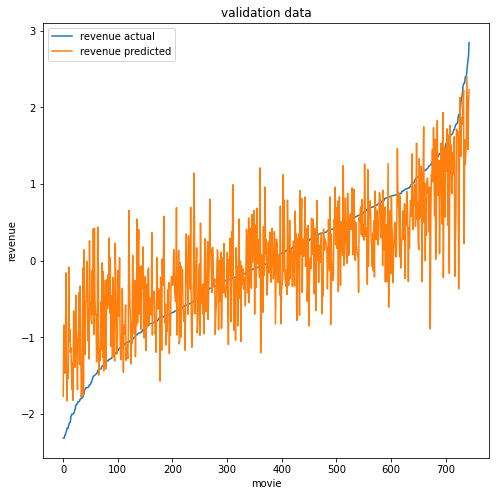

train
mape: 253.876
mae: 31,864,628.986
rmse: 82,644,777.317
adj_r2: 0.730
test
mape: 760.891
mae: 43,415,606.909
rmse: 108,276,409.633
adj_r2: 0.370


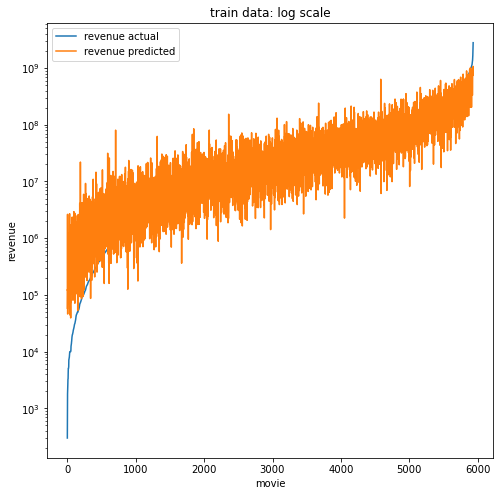

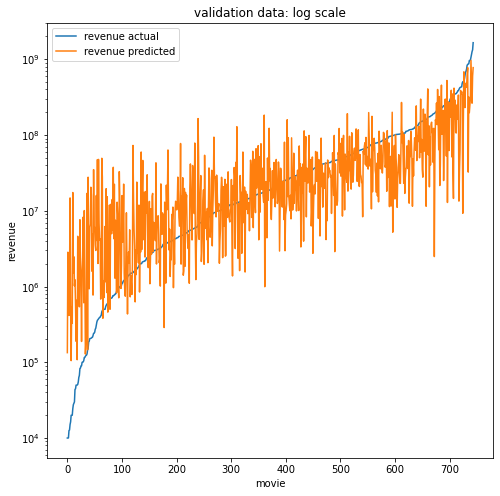

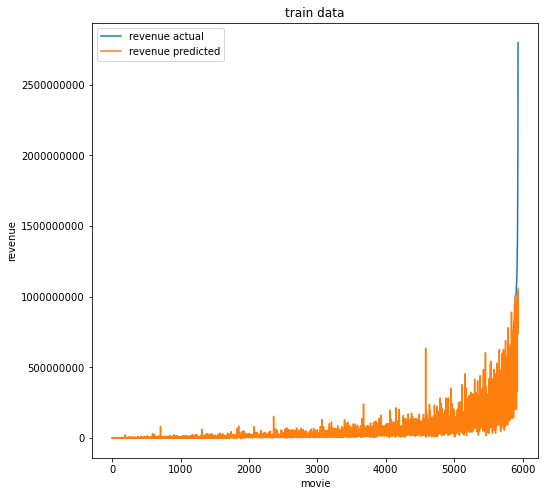

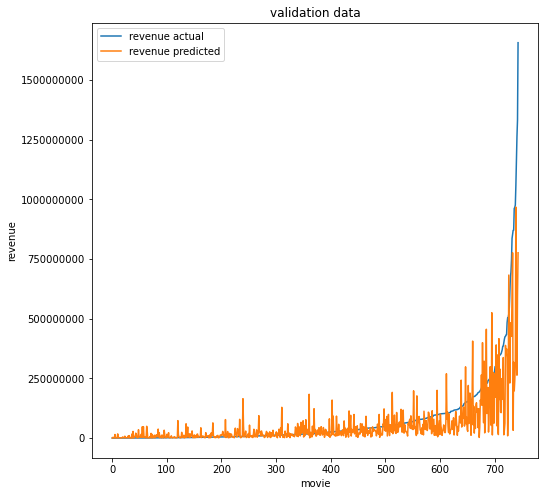

Epoch 00157: early stopping
-----------------------------------------------
output NN
train
mape: 226.402
mae: 0.433
rmse: 0.564
adj_r2: 0.670
test
mape: 161.114
mae: 0.482
rmse: 0.634
adj_r2: 0.418


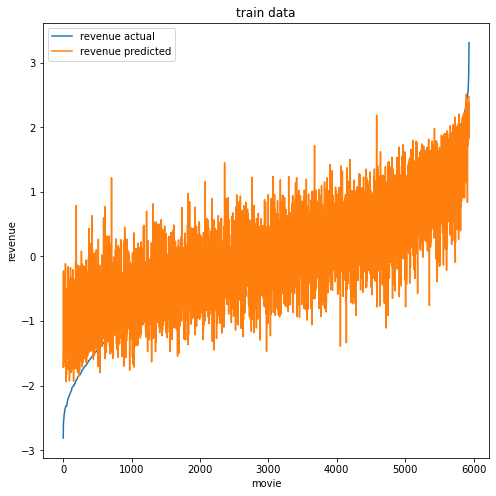

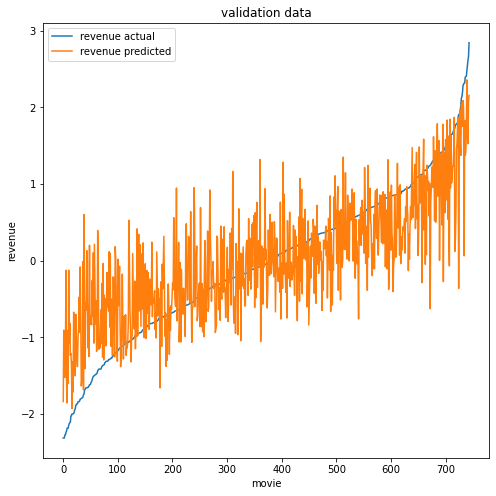

train
mape: 817.513
mae: 39,277,786.015
rmse: 94,380,307.199
adj_r2: 0.648
test
mape: 789.479
mae: 43,622,831.205
rmse: 107,646,246.975
adj_r2: 0.378


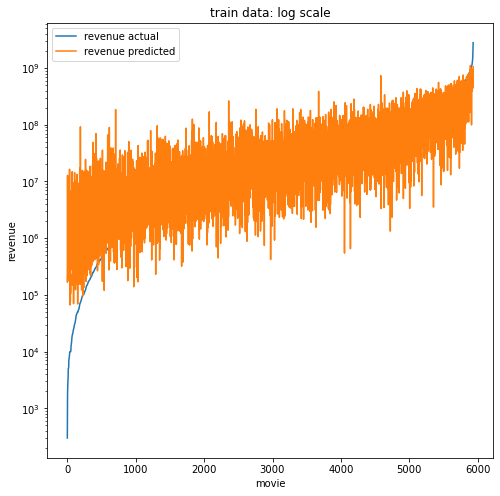

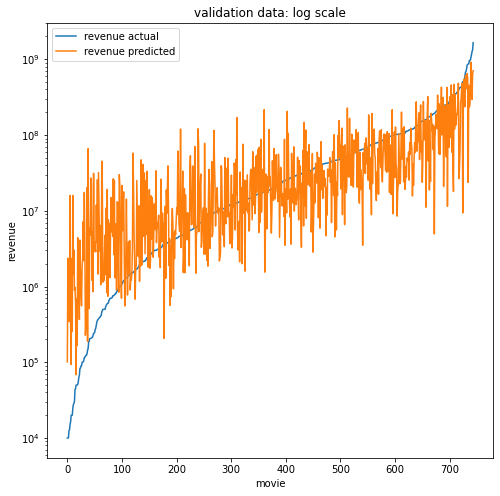

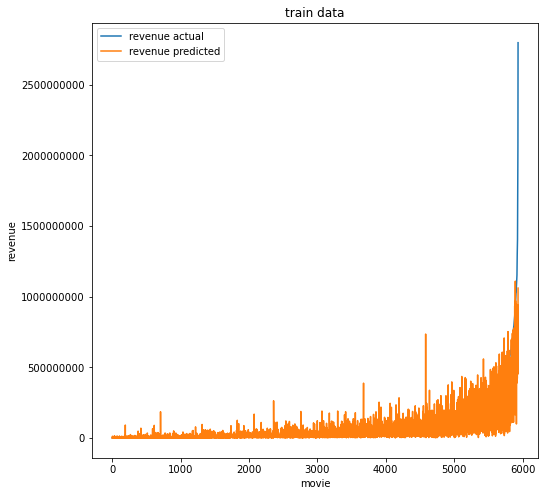

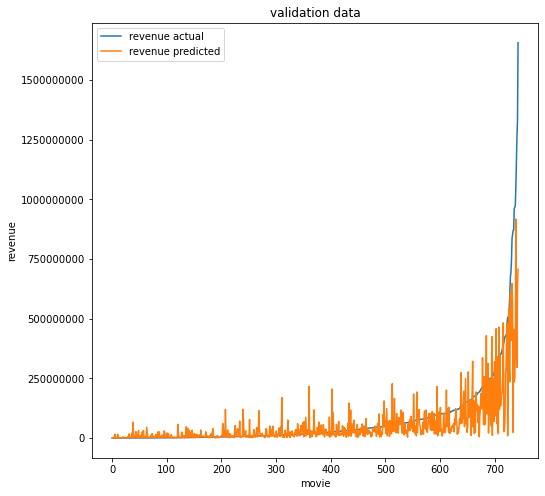

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dataset_budget_start_5percent.csv
-----------------------------------------------
output LGBMRegressor
train
mape: 1,006.330
mae: 0.323
rmse: 0.418
adj_r2: 0.818
test
mape: 200.519
mae: 0.461
rmse: 0.610
adj_r2: 0.426


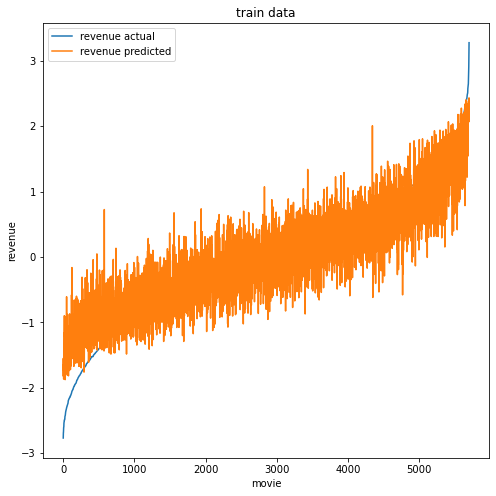

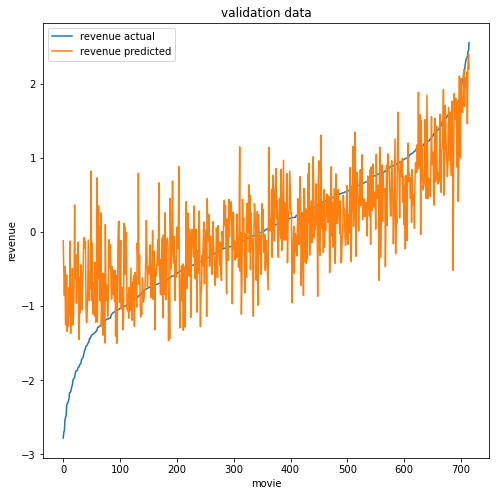

train
mape: 215.168
mae: 34,104,218.590
rmse: 89,423,829.599
adj_r2: 0.713
test
mape: 2,601.332
mae: 40,133,963.271
rmse: 78,315,444.723
adj_r2: 0.568


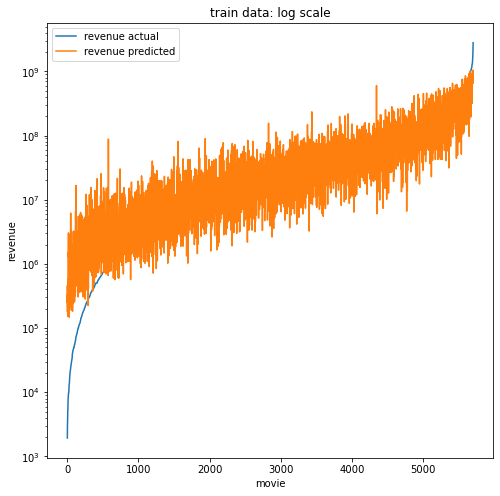

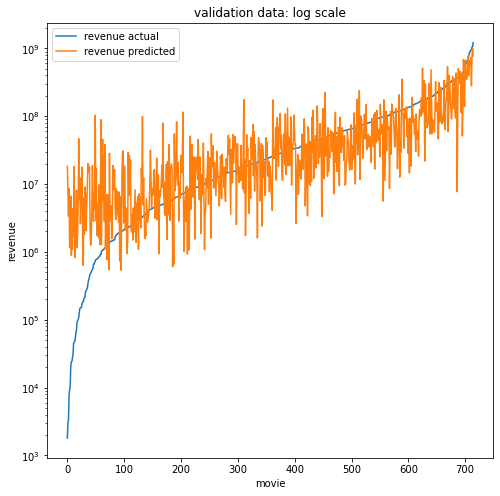

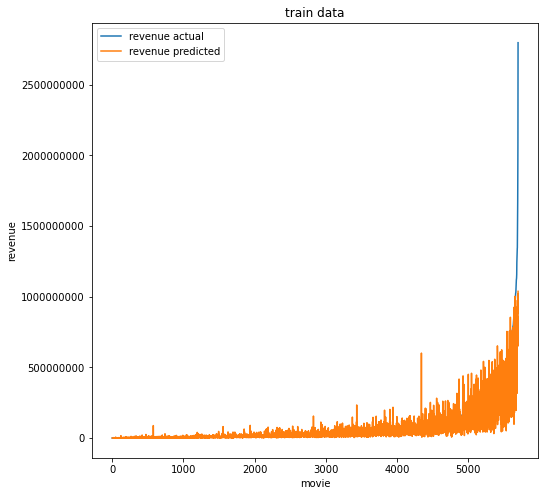

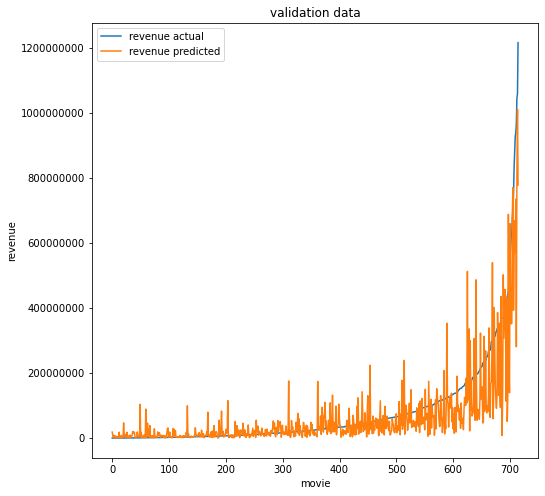

Epoch 00180: early stopping
-----------------------------------------------
output NN
train
mape: 1,297.516
mae: 0.453
rmse: 0.588
adj_r2: 0.640
test
mape: 234.902
mae: 0.452
rmse: 0.591
adj_r2: 0.462


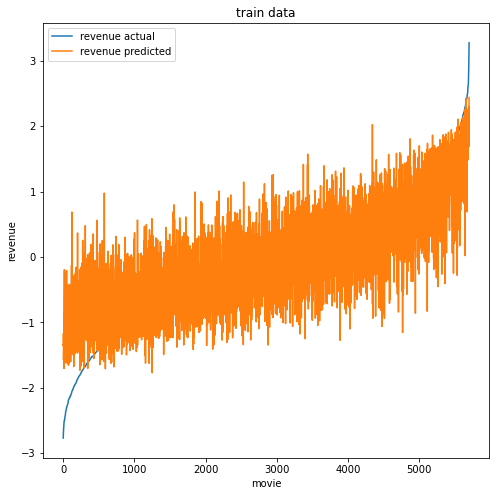

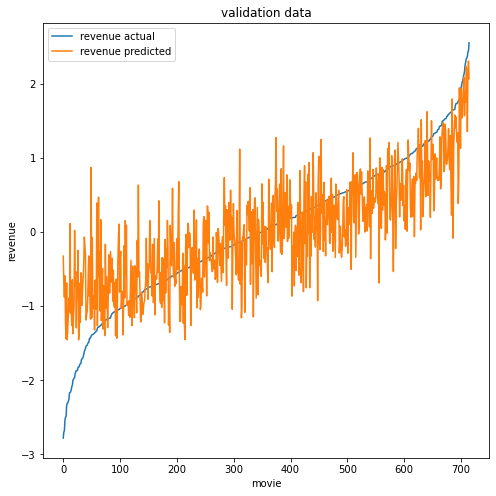

train
mape: 571.971
mae: 43,088,539.483
rmse: 106,440,805.824
adj_r2: 0.594
test
mape: 1,892.631
mae: 39,357,199.456
rmse: 78,703,390.308
adj_r2: 0.563


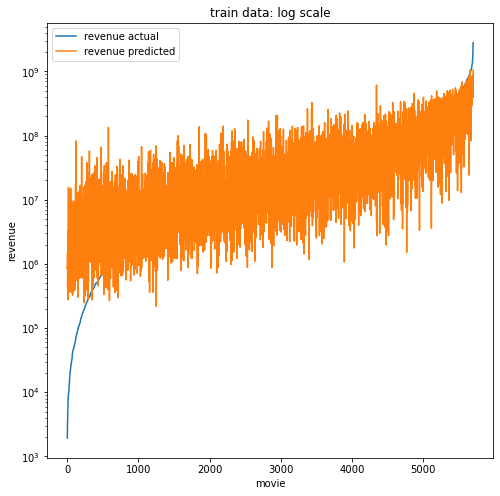

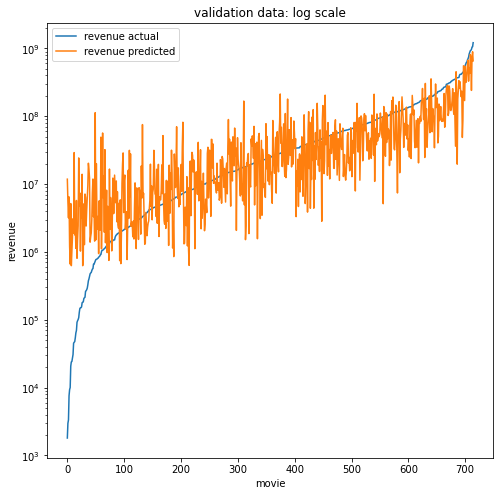

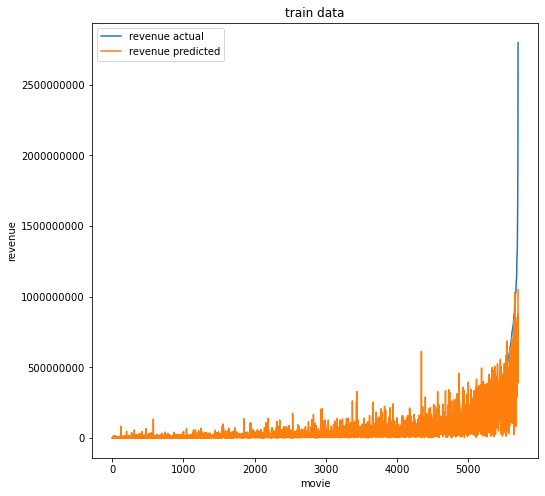

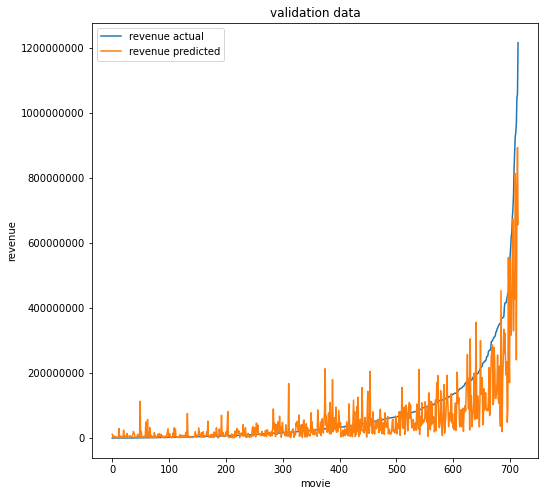

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dataset_profitability_10percentile.csv
-----------------------------------------------
output LGBMRegressor
train
mape: 128.352
mae: 0.240
rmse: 0.296
adj_r2: 0.908
test
mape: 154.054
mae: 0.352
rmse: 0.433
adj_r2: 0.703


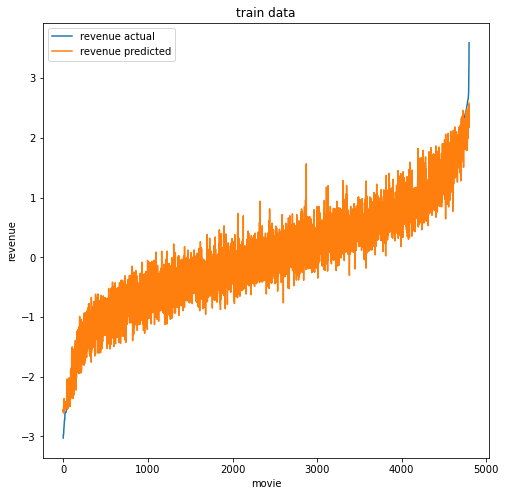

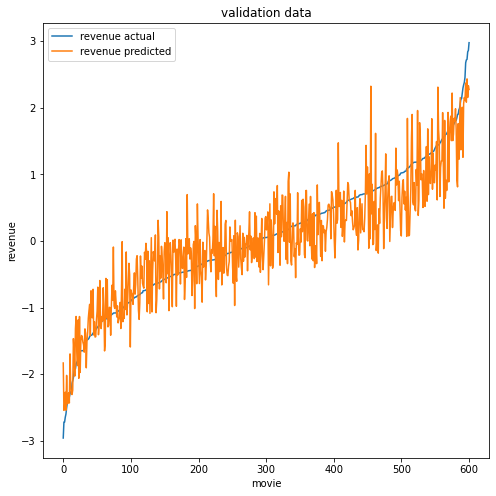

train
mape: 59.657
mae: 25,894,319.519
rmse: 64,486,710.786
adj_r2: 0.810
test
mape: 127.068
mae: 42,058,880.078
rmse: 95,024,872.158
adj_r2: 0.458


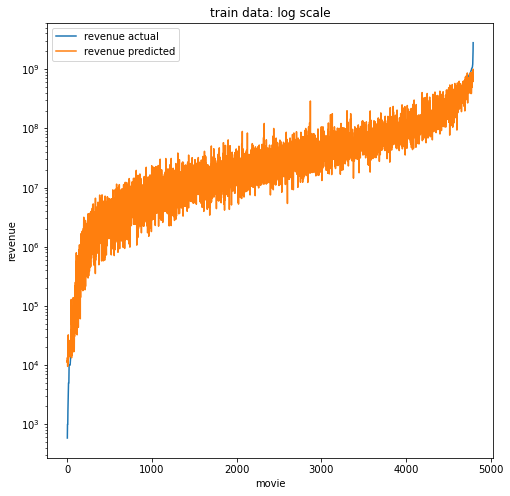

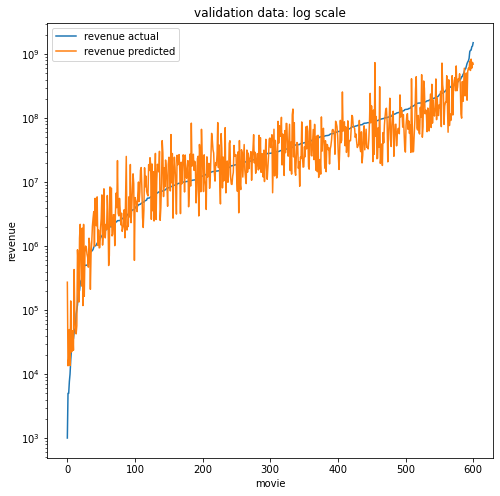

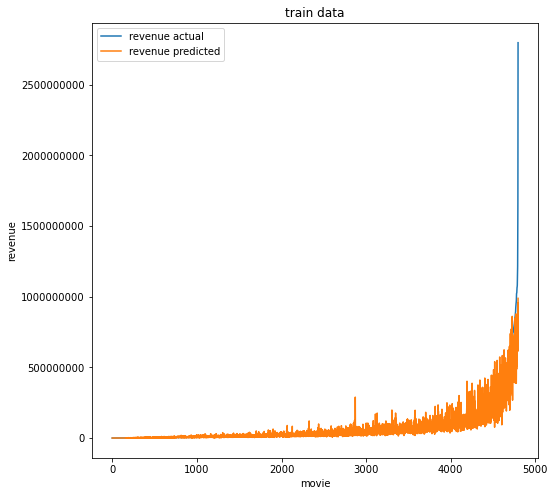

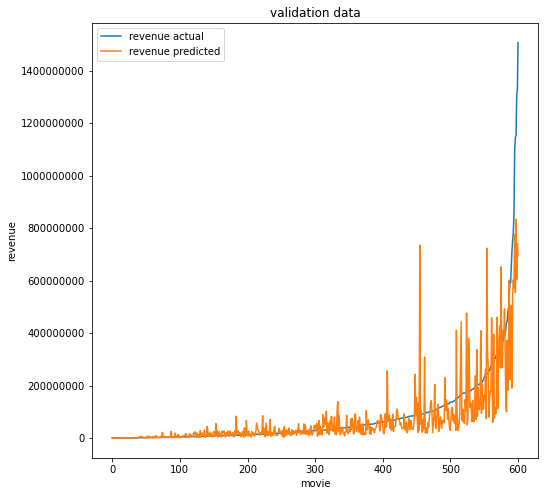

Epoch 00218: early stopping
-----------------------------------------------
output NN
train
mape: 182.801
mae: 0.348
rmse: 0.427
adj_r2: 0.808
test
mape: 145.573
mae: 0.352
rmse: 0.434
adj_r2: 0.701


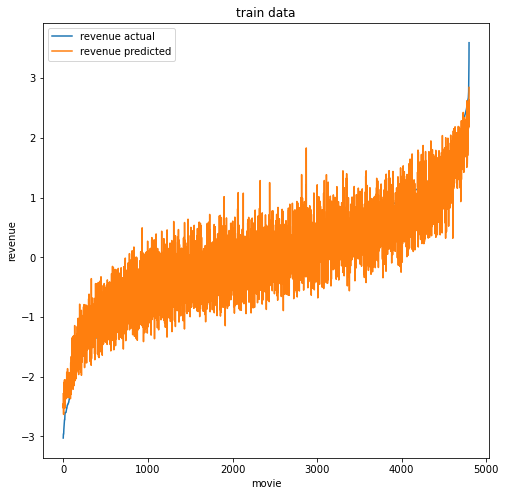

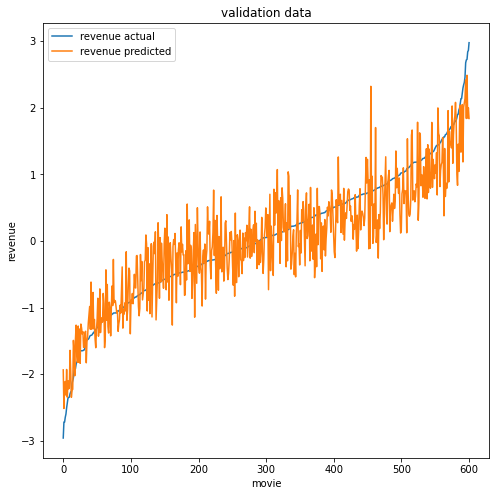

train
mape: 100.605
mae: 34,685,231.338
rmse: 75,957,866.749
adj_r2: 0.737
test
mape: 115.979
mae: 42,067,973.390
rmse: 103,170,919.432
adj_r2: 0.361


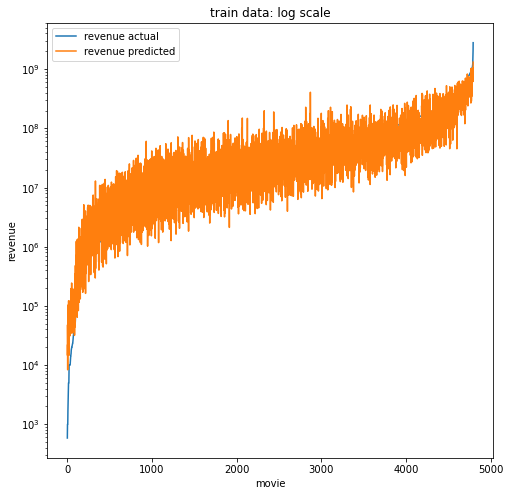

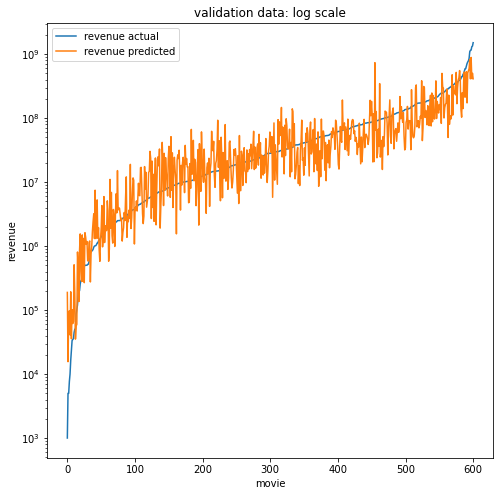

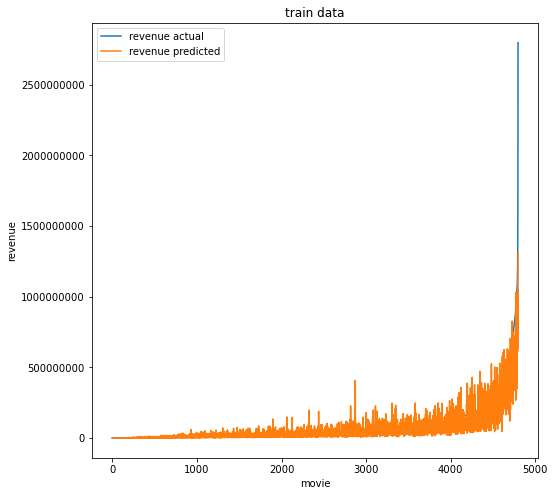

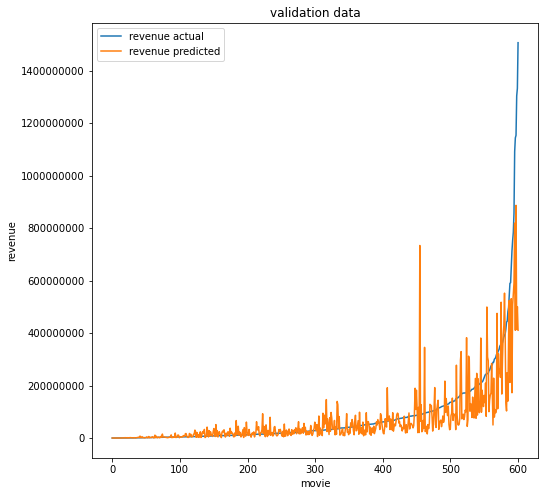

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dataset_profitability_1percentile.csv
-----------------------------------------------
output LGBMRegressor
train
mape: 445.978
mae: 0.303
rmse: 0.387
adj_r2: 0.844
test
mape: 137.633
mae: 0.416
rmse: 0.537
adj_r2: 0.579


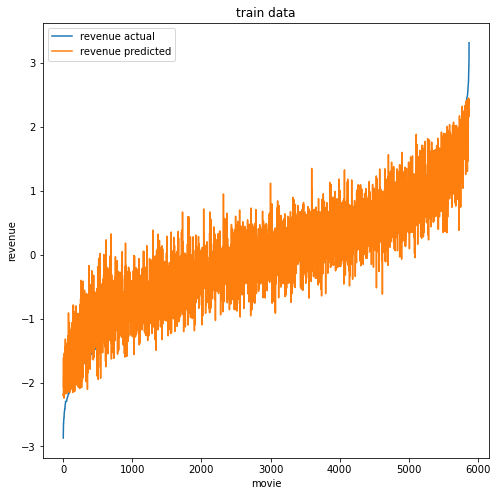

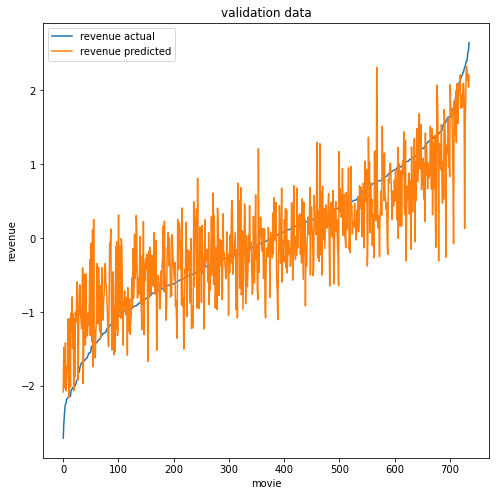

train
mape: 165.751
mae: 31,904,066.544
rmse: 81,384,226.861
adj_r2: 0.736
test
mape: 300.069
mae: 39,188,485.443
rmse: 89,671,150.520
adj_r2: 0.563


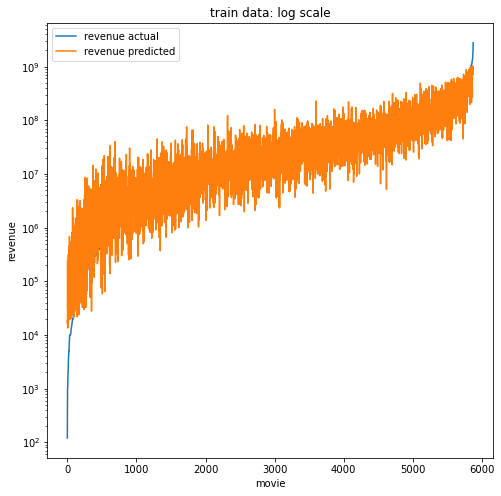

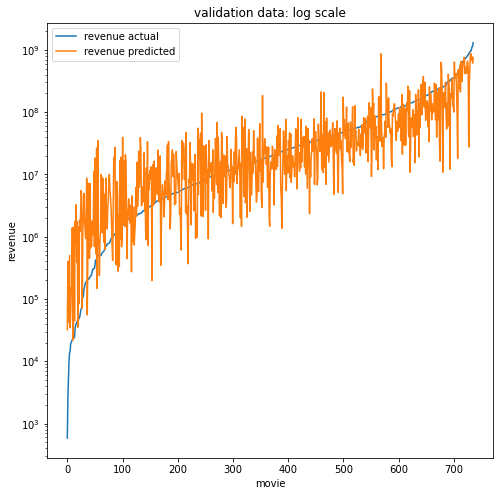

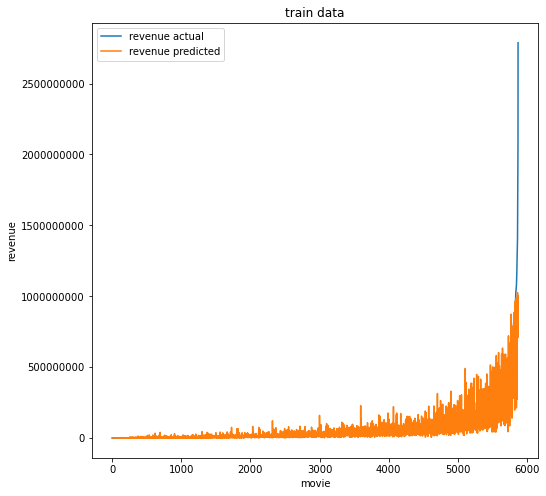

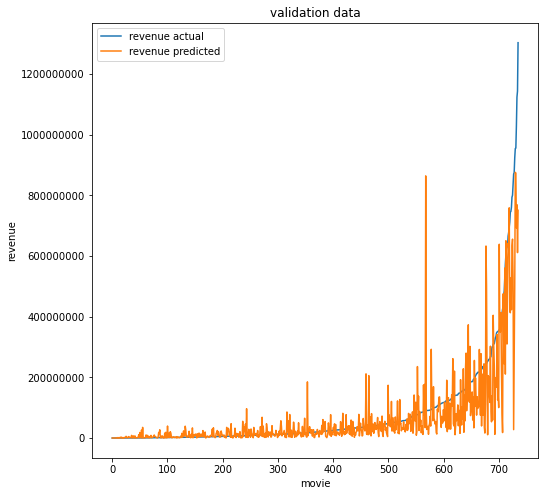

Epoch 00126: early stopping
-----------------------------------------------
output NN
train
mape: 520.247
mae: 0.424
rmse: 0.543
adj_r2: 0.694
test
mape: 159.819
mae: 0.424
rmse: 0.545
adj_r2: 0.566


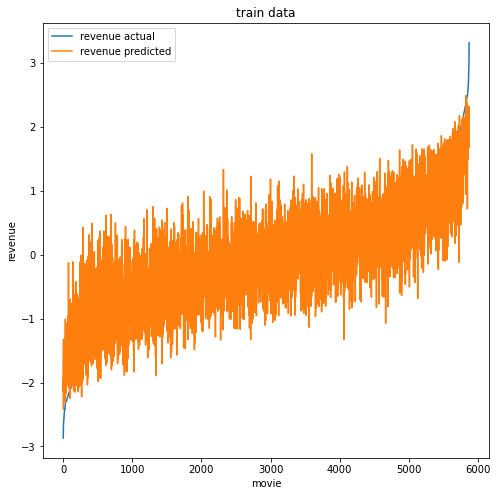

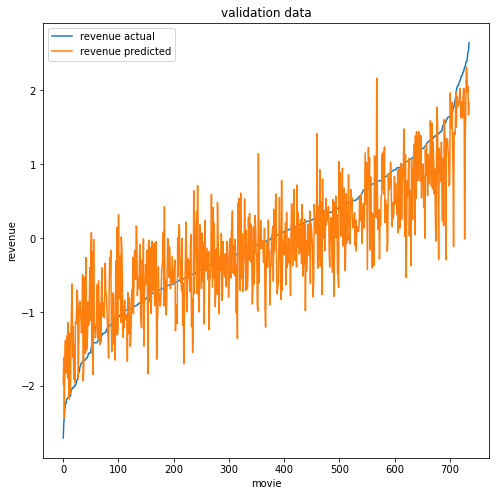

train
mape: 335.600
mae: 40,831,390.757
rmse: 99,773,156.348
adj_r2: 0.603
test
mape: 268.118
mae: 41,146,228.443
rmse: 97,337,810.602
adj_r2: 0.485


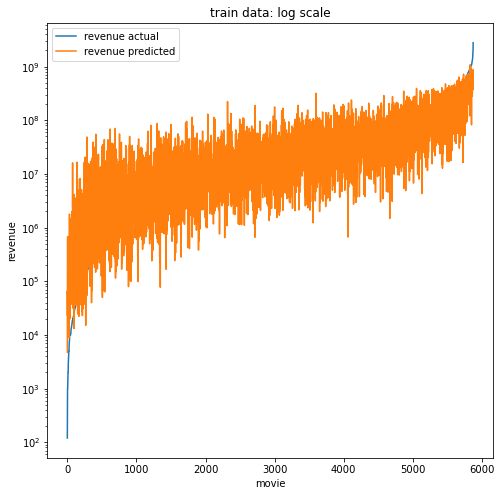

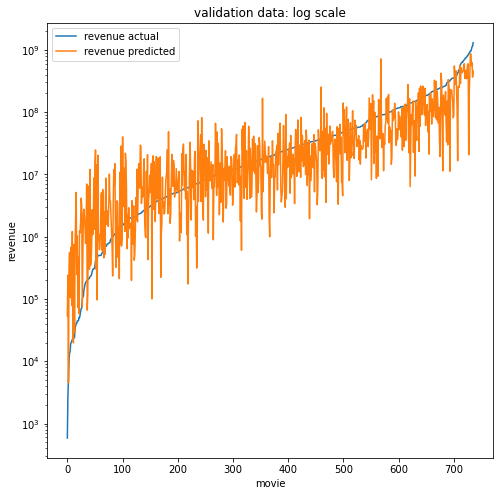

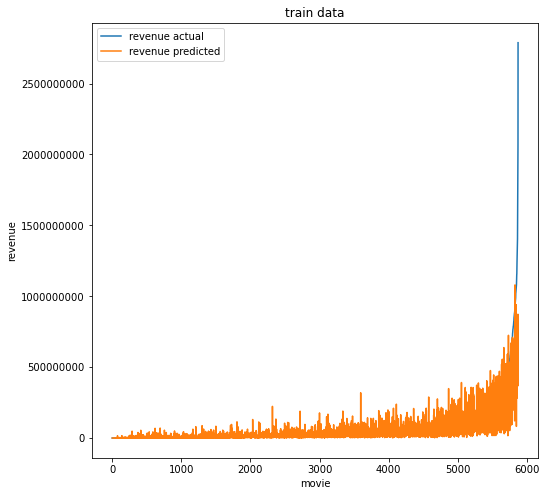

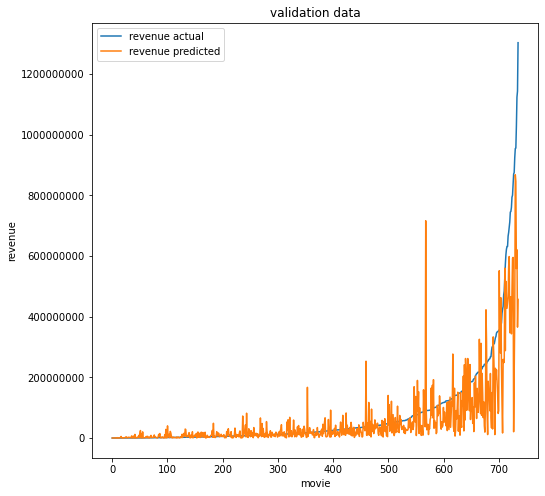

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dataset_profitability_1percentile_years2000-2018.csv
-----------------------------------------------
output LGBMRegressor
train
mape: 137.500
mae: 0.254
rmse: 0.327
adj_r2: 0.887
test
mape: 178.075
mae: 0.425
rmse: 0.538
adj_r2: 0.490


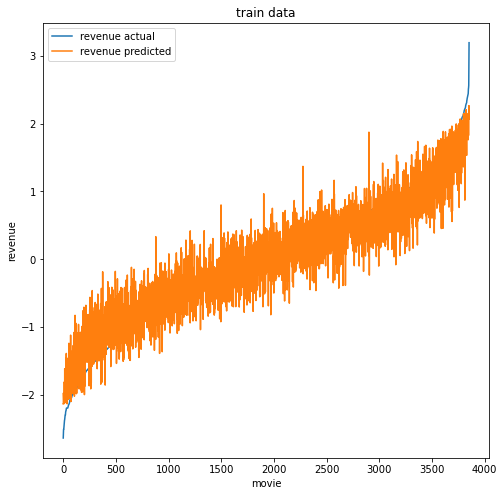

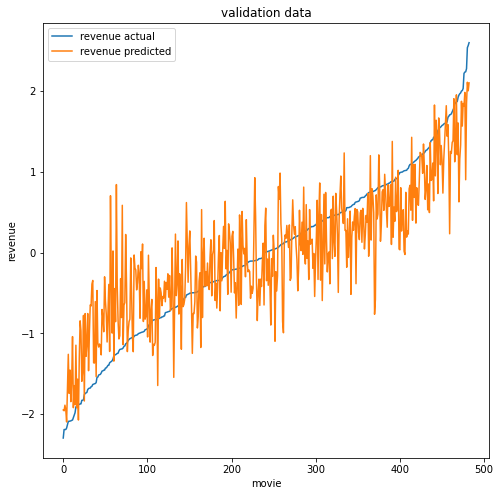

train
mape: 130.337
mae: 30,634,291.241
rmse: 81,223,413.316
adj_r2: 0.757
test
mape: 361.174
mae: 45,195,537.934
rmse: 100,550,319.677
adj_r2: 0.383


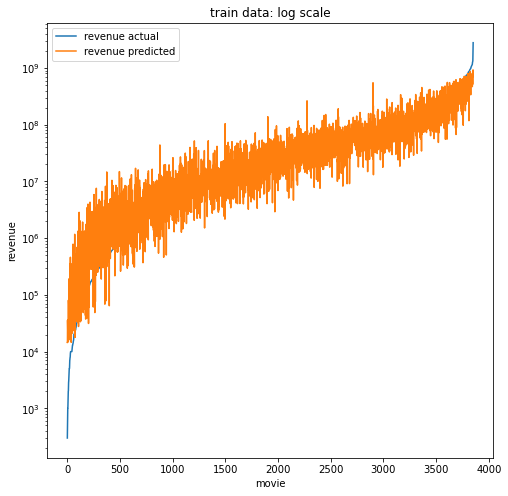

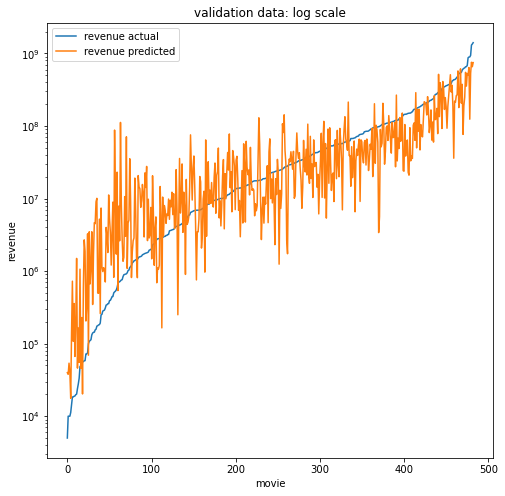

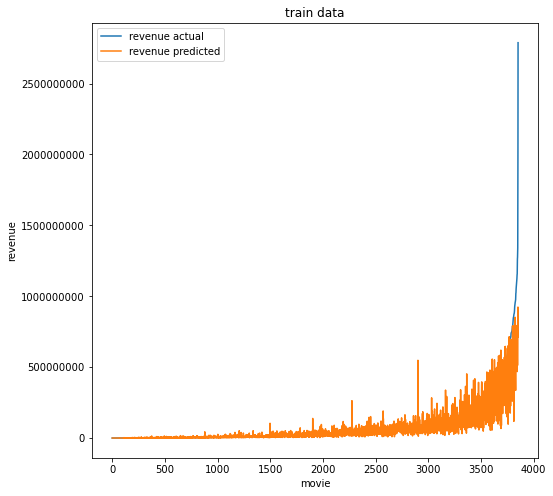

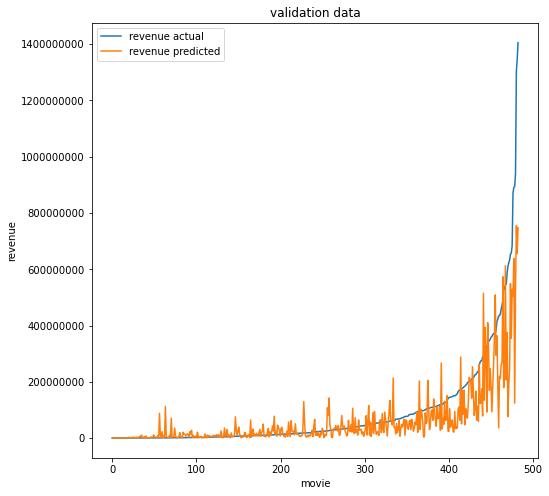

Epoch 00210: early stopping
-----------------------------------------------
output NN
train
mape: 224.486
mae: 0.389
rmse: 0.507
adj_r2: 0.727
test
mape: 156.090
mae: 0.431
rmse: 0.549
adj_r2: 0.469


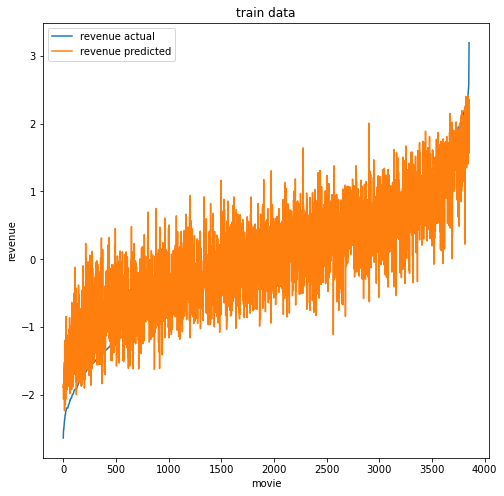

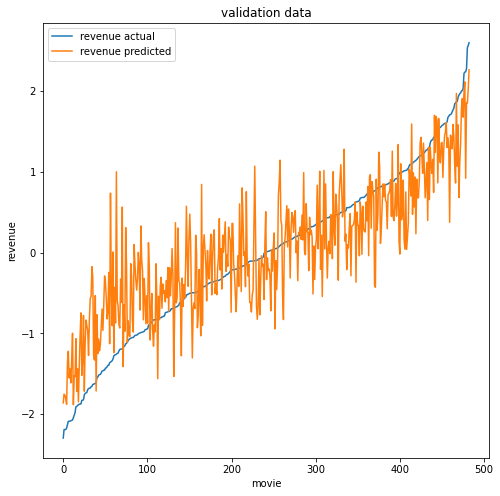

train
mape: 420.291
mae: 40,107,701.526
rmse: 94,598,908.846
adj_r2: 0.670
test
mape: 433.980
mae: 45,446,513.776
rmse: 100,163,110.782
adj_r2: 0.388


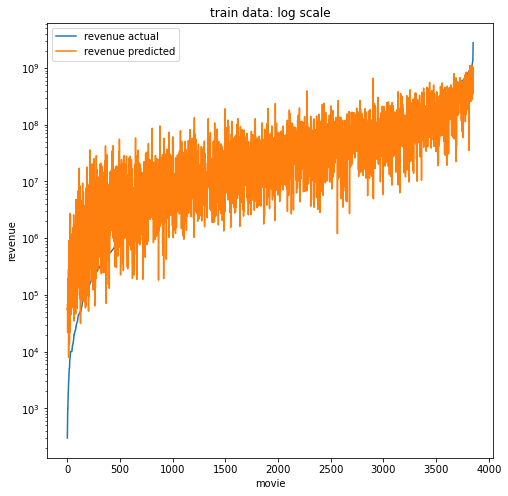

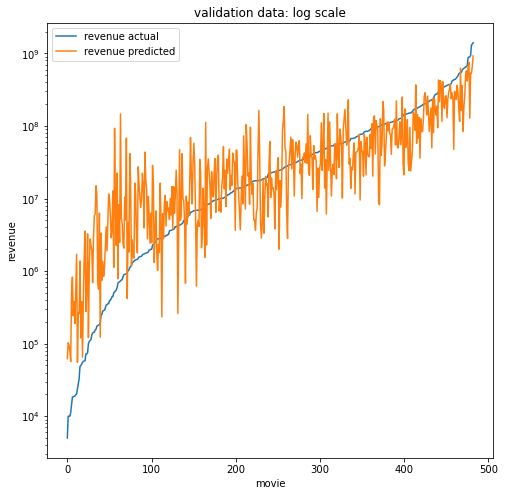

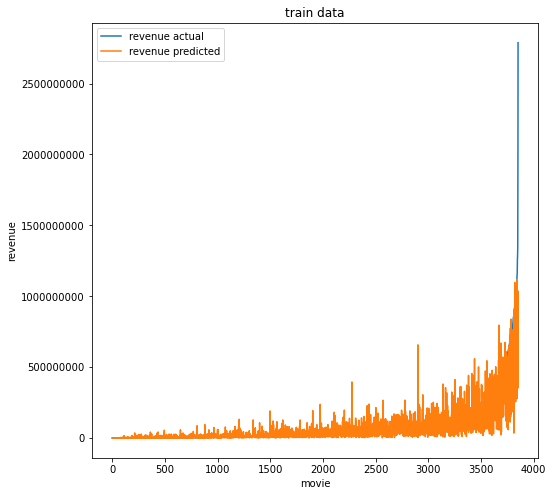

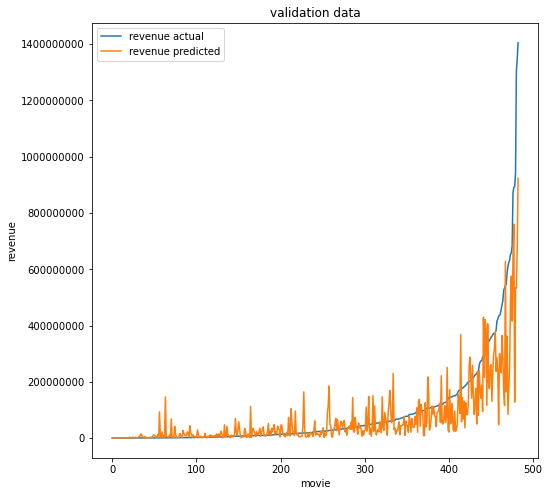

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dataset_profitability_1percentile_years2000-2018_budget_start_1percent.csv
-----------------------------------------------
output LGBMRegressor
train
mape: 142.906
mae: 0.291
rmse: 0.373
adj_r2: 0.852
test
mape: 211.338
mae: 0.419
rmse: 0.523
adj_r2: 0.436


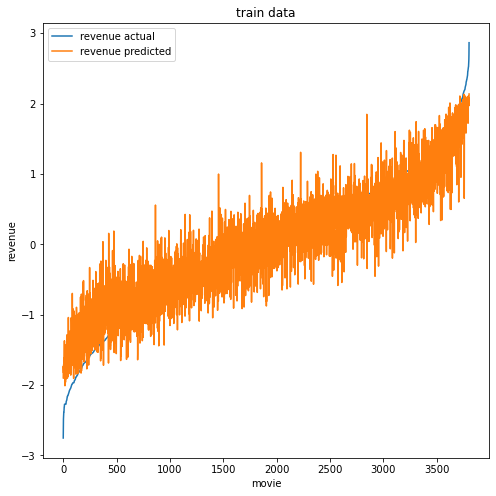

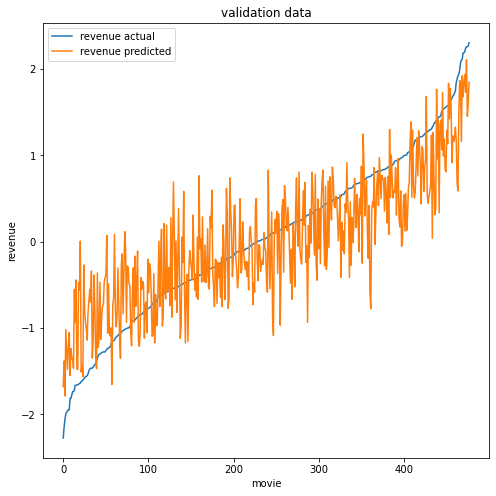

train
mape: 166.866
mae: 34,478,504.875
rmse: 84,648,492.105
adj_r2: 0.745
test
mape: 244.200
mae: 46,618,567.735
rmse: 98,199,419.497
adj_r2: 0.317


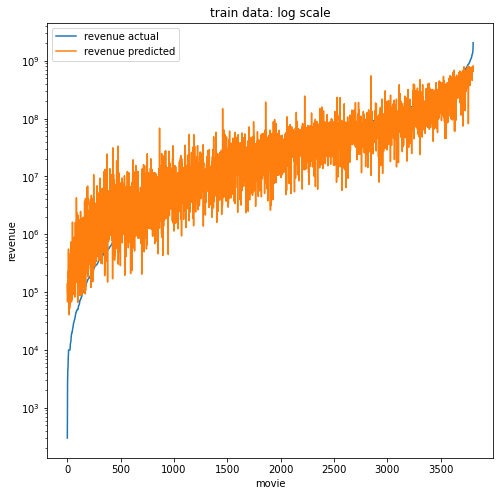

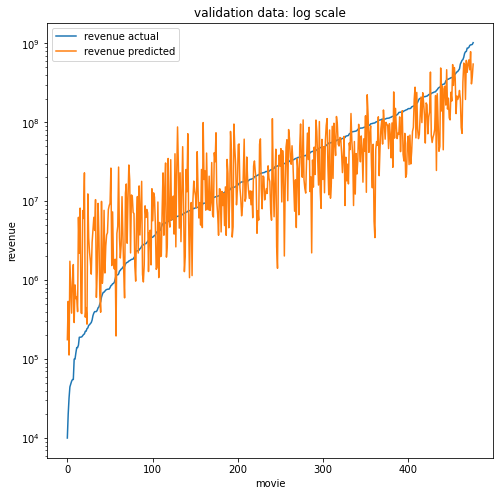

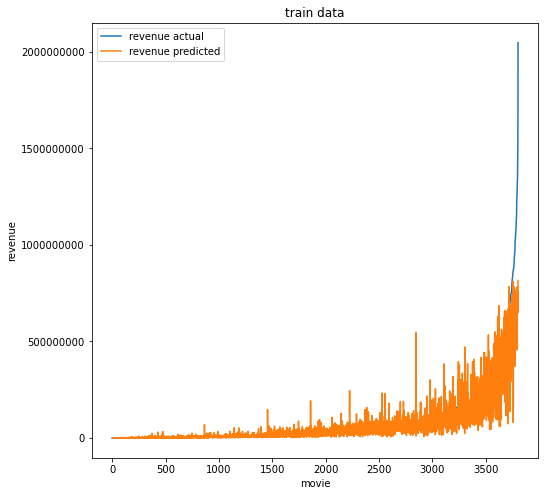

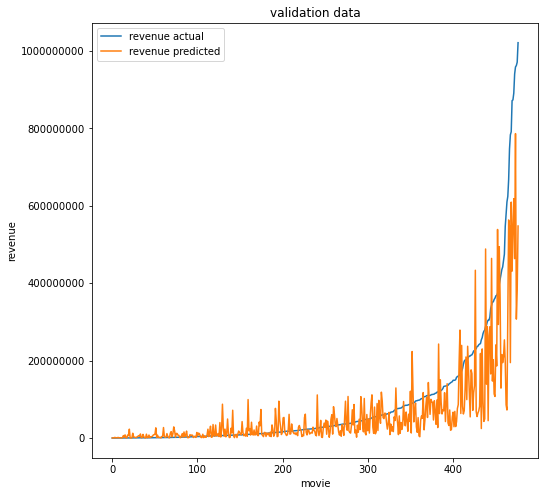

Epoch 00151: early stopping
-----------------------------------------------
output NN
train
mape: 192.408
mae: 0.398
rmse: 0.516
adj_r2: 0.717
test
mape: 188.063
mae: 0.412
rmse: 0.525
adj_r2: 0.431


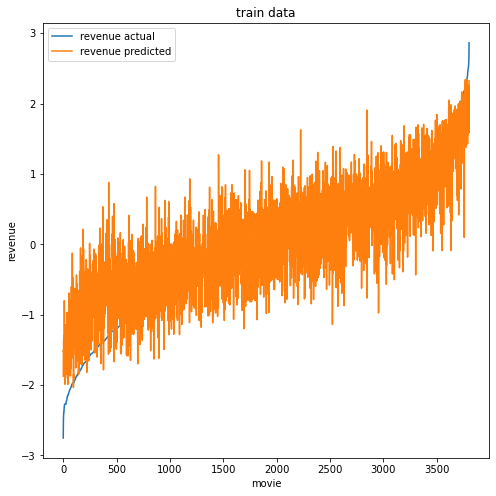

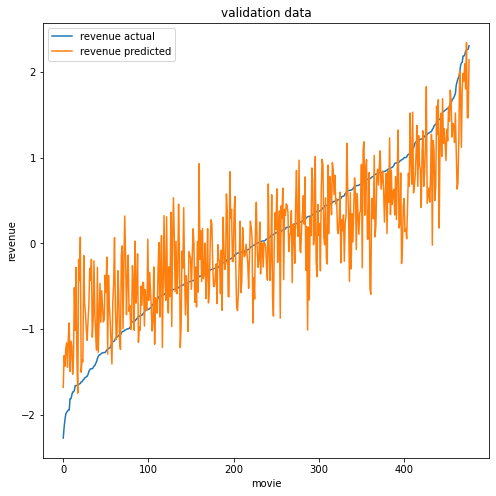

train
mape: 410.483
mae: 40,923,184.224
rmse: 92,435,362.574
adj_r2: 0.696
test
mape: 286.360
mae: 44,894,379.700
rmse: 93,789,405.978
adj_r2: 0.377


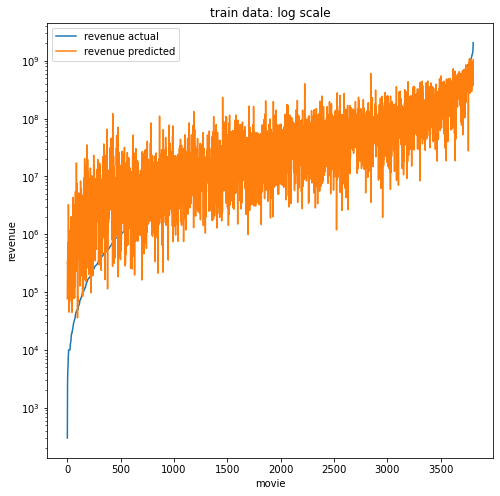

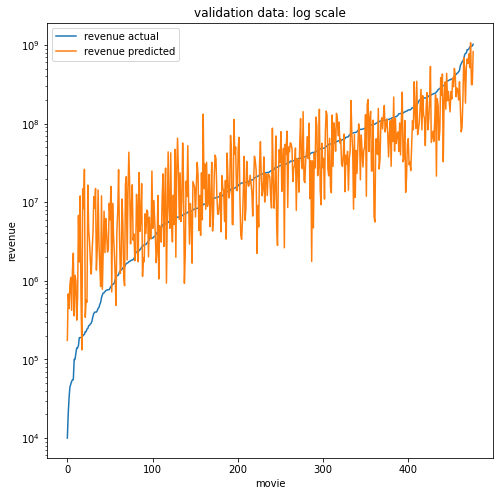

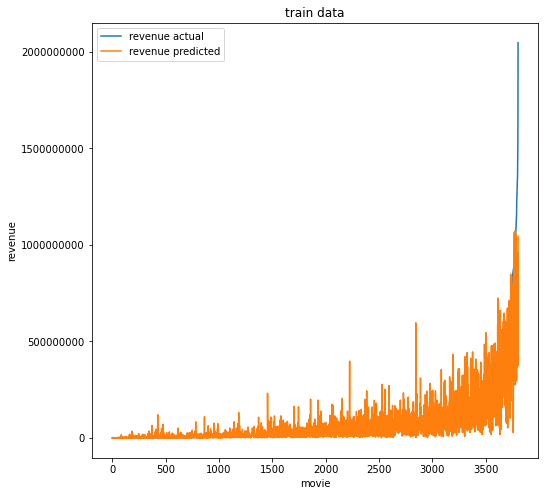

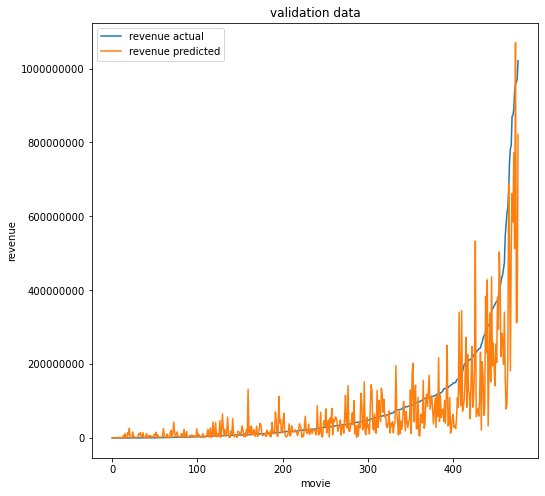

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dataset_profitability_1percentile_years2000-2018_budget_start_5percent.csv
-----------------------------------------------
output LGBMRegressor
train
mape: 161.870
mae: 0.273
rmse: 0.350
adj_r2: 0.870
test
mape: 217.453
mae: 0.441
rmse: 0.579
adj_r2: 0.347


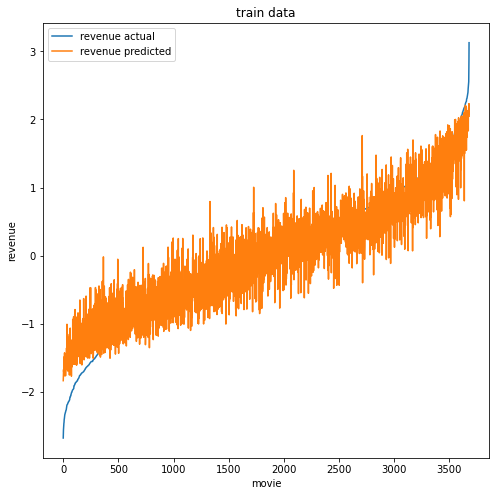

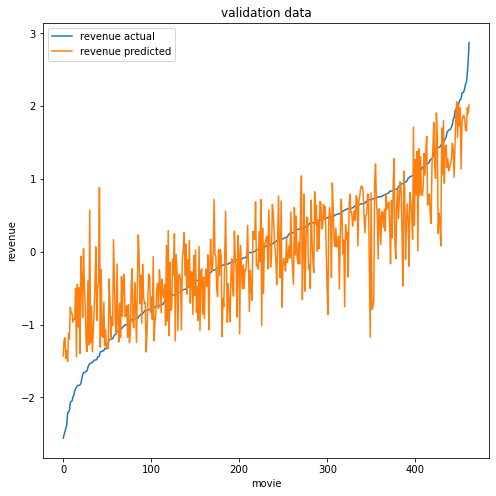

train
mape: 116.810
mae: 32,648,917.257
rmse: 83,119,620.354
adj_r2: 0.764
test
mape: 437.093
mae: 49,876,686.977
rmse: 121,547,689.668
adj_r2: 0.290


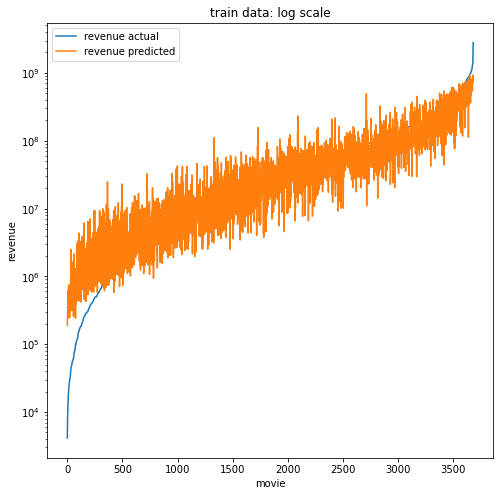

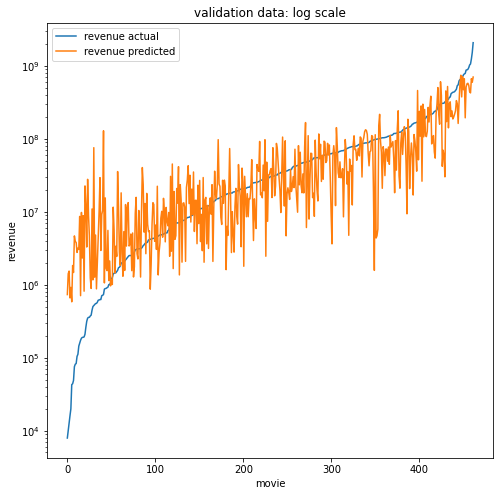

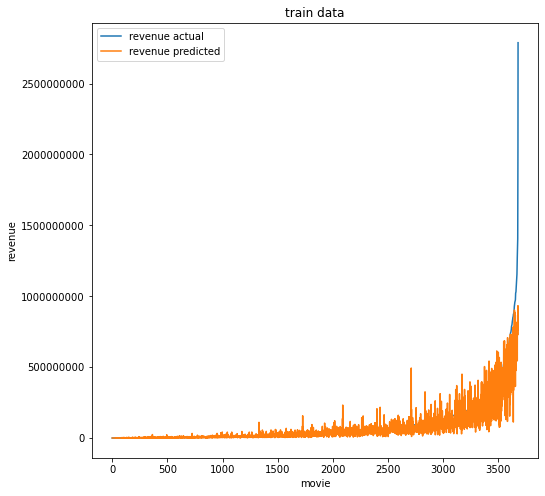

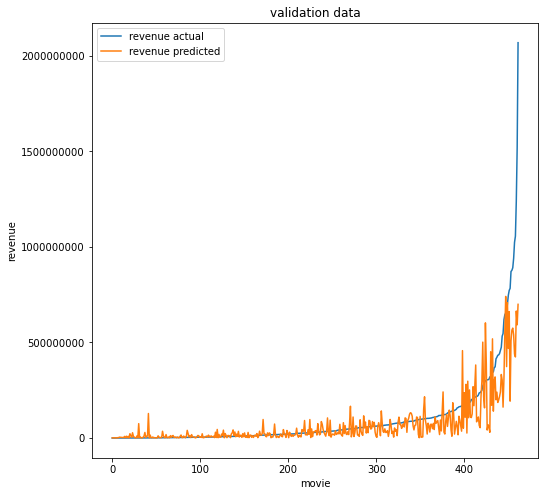

Epoch 00165: early stopping
-----------------------------------------------
output NN
train
mape: 228.367
mae: 0.419
rmse: 0.549
adj_r2: 0.679
test
mape: 218.911
mae: 0.436
rmse: 0.577
adj_r2: 0.352


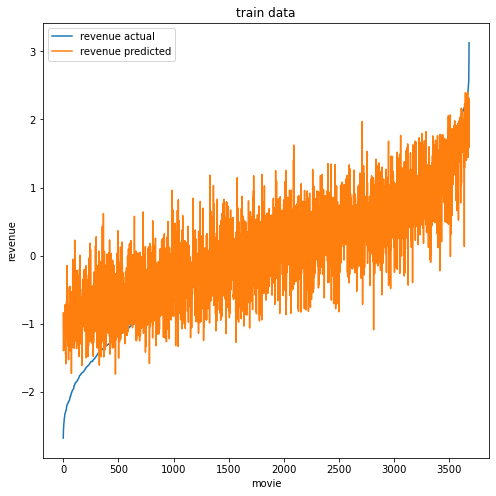

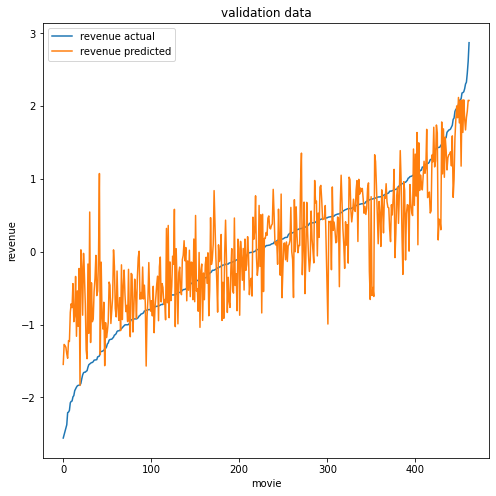

train
mape: 422.917
mae: 42,945,799.725
rmse: 97,318,705.677
adj_r2: 0.676
test
mape: 493.698
mae: 48,185,806.868
rmse: 114,994,670.464
adj_r2: 0.364


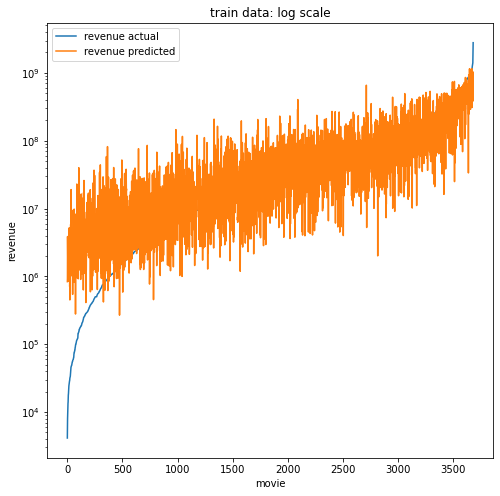

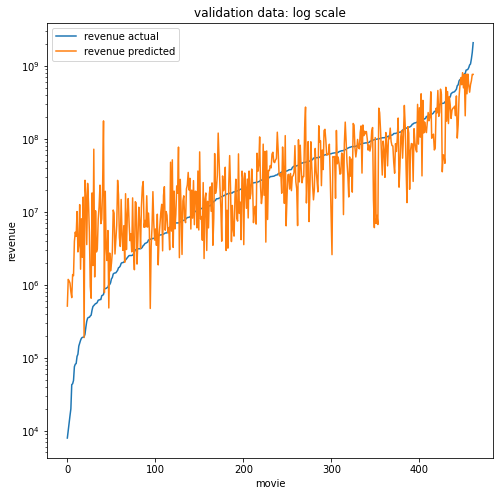

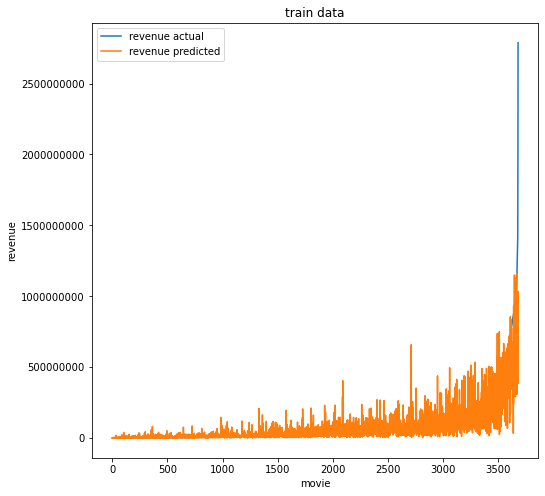

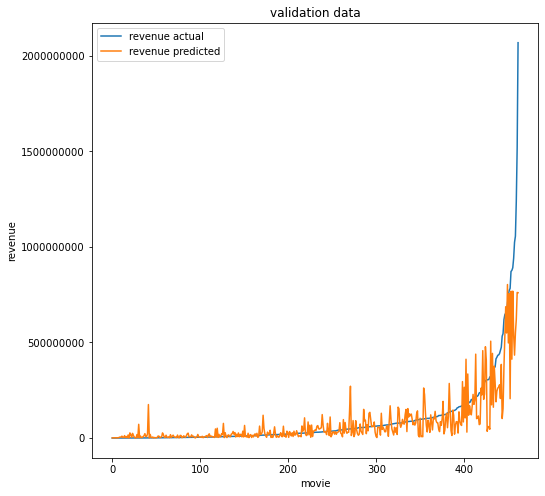

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dataset_profitability_5percentile.csv
-----------------------------------------------
output LGBMRegressor
train
mape: 213.182
mae: 0.270
rmse: 0.339
adj_r2: 0.880
test
mape: 166.094
mae: 0.393
rmse: 0.489
adj_r2: 0.620


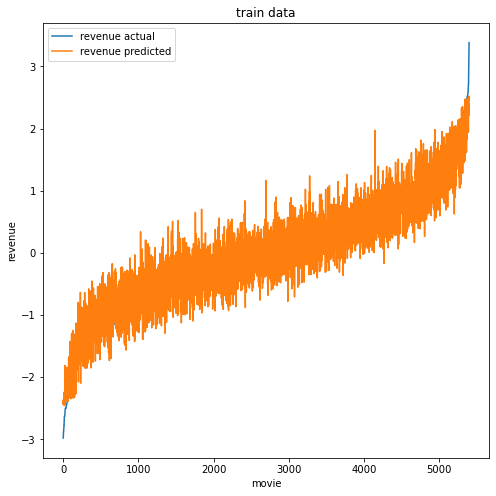

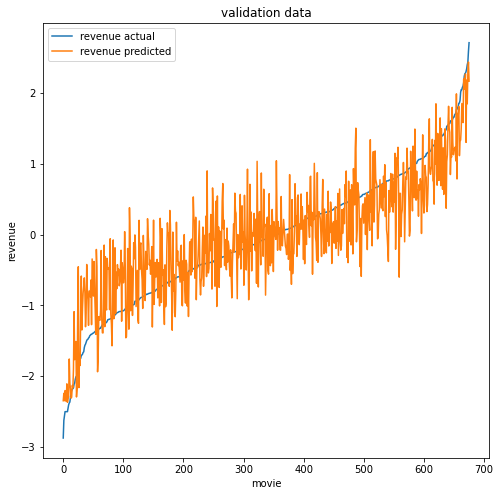

train
mape: 85.925
mae: 29,848,825.436
rmse: 77,575,943.997
adj_r2: 0.768
test
mape: 158.091
mae: 33,988,551.975
rmse: 70,115,910.360
adj_r2: 0.625


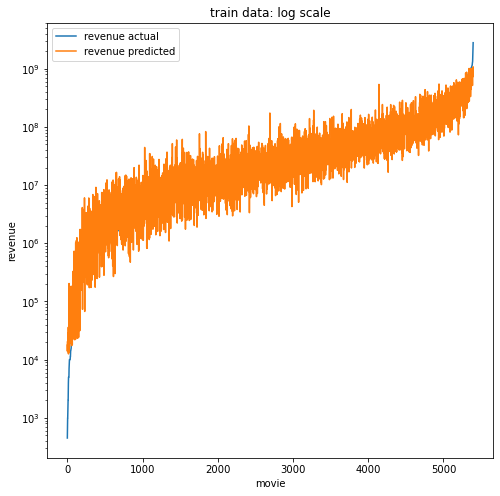

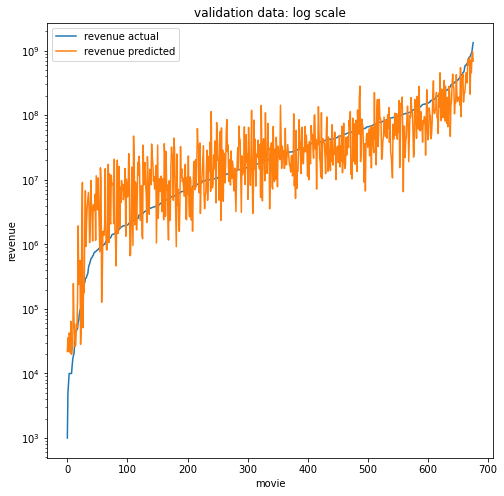

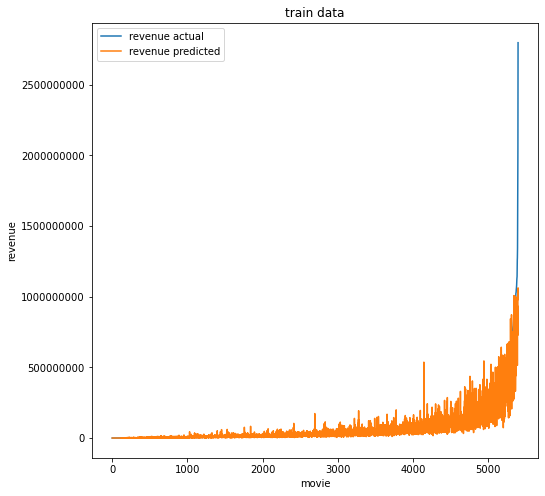

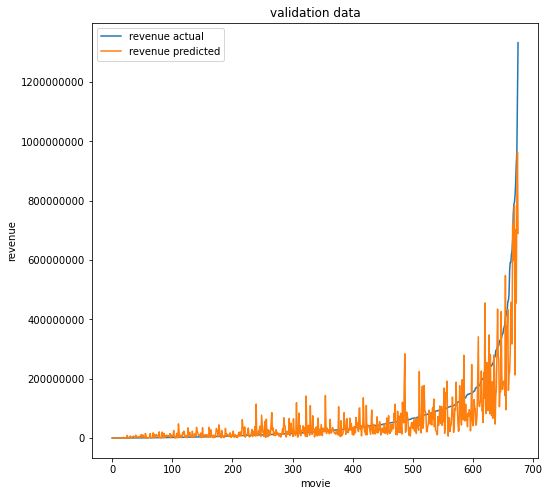

Epoch 00157: early stopping
-----------------------------------------------
output NN
train
mape: 250.056
mae: 0.385
rmse: 0.484
adj_r2: 0.756
test
mape: 180.322
mae: 0.391
rmse: 0.485
adj_r2: 0.627


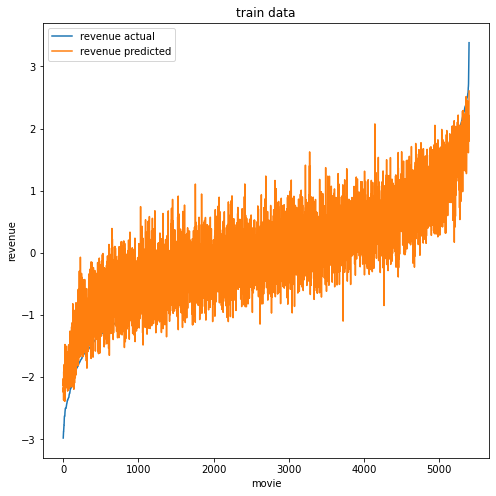

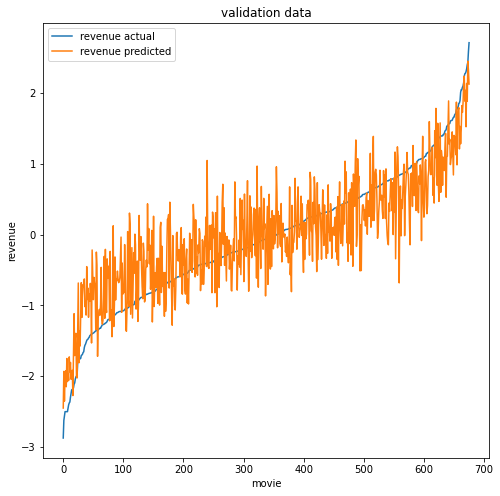

train
mape: 176.604
mae: 38,863,584.217
rmse: 93,356,249.312
adj_r2: 0.665
test
mape: 167.725
mae: 33,398,474.621
rmse: 68,682,031.221
adj_r2: 0.640


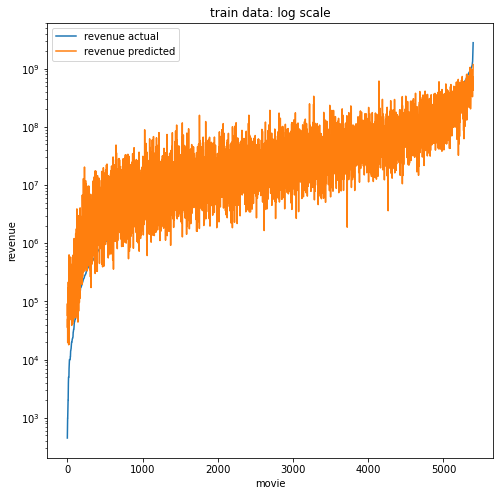

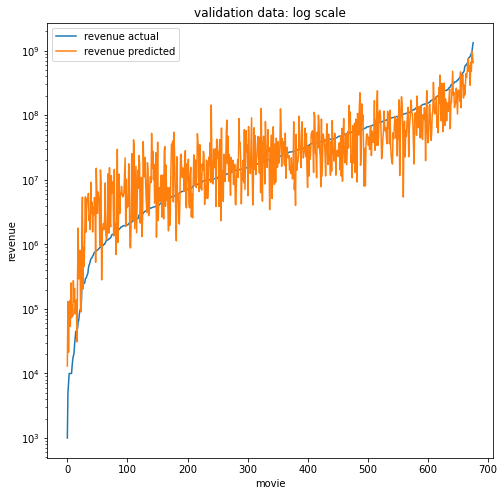

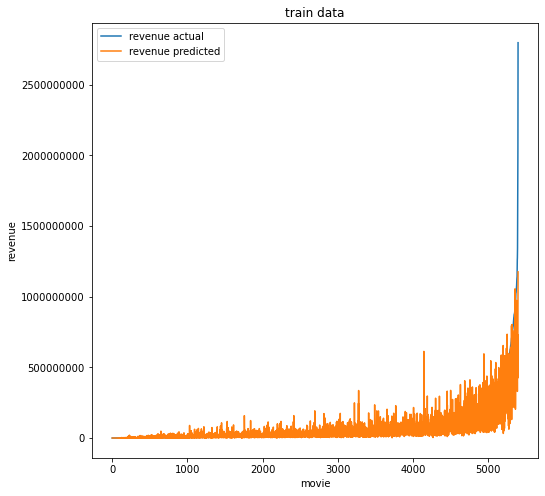

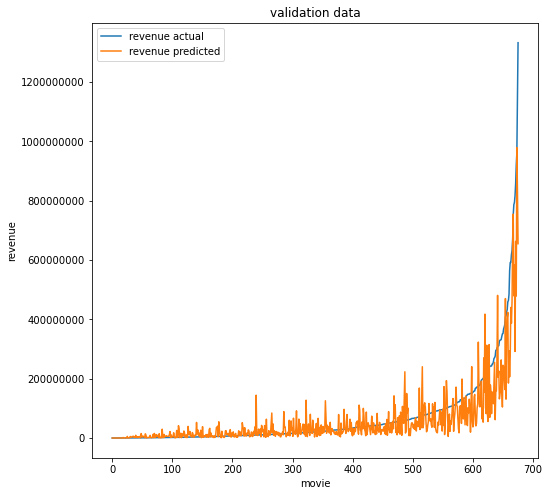

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dataset_profitability_negative.csv
-----------------------------------------------
output LGBMRegressor
train
mape: 153.848
mae: 0.308
rmse: 0.389
adj_r2: 0.828
test
mape: 131.892
mae: 0.448
rmse: 0.559
adj_r2: -7.623


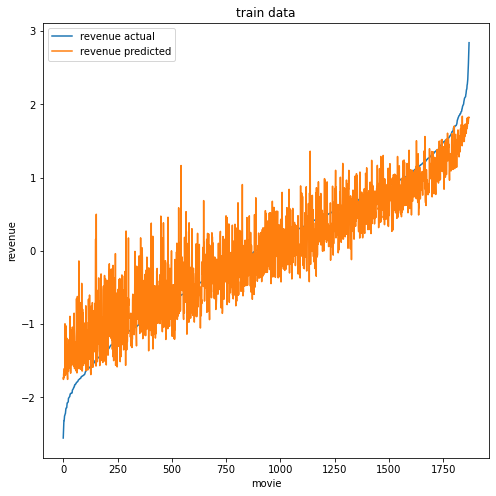

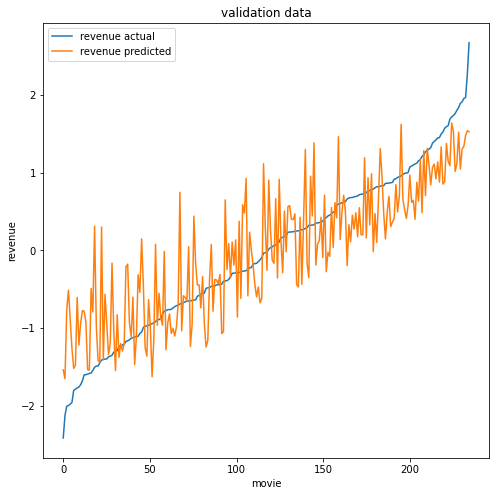

train
mape: 209.160
mae: 3,882,970.606
rmse: 8,326,627.900
adj_r2: 0.698
test
mape: 439.216
mae: 5,929,710.833
rmse: 12,035,857.943
adj_r2: -13.069


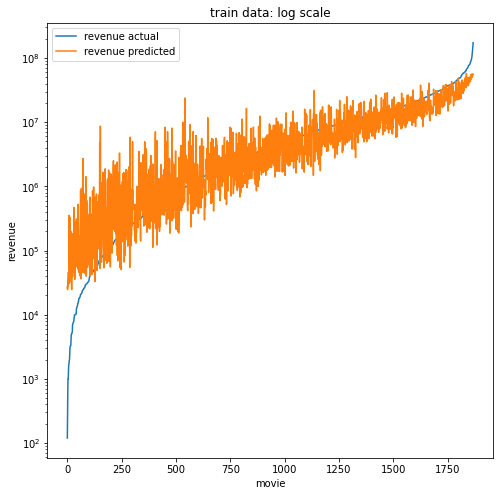

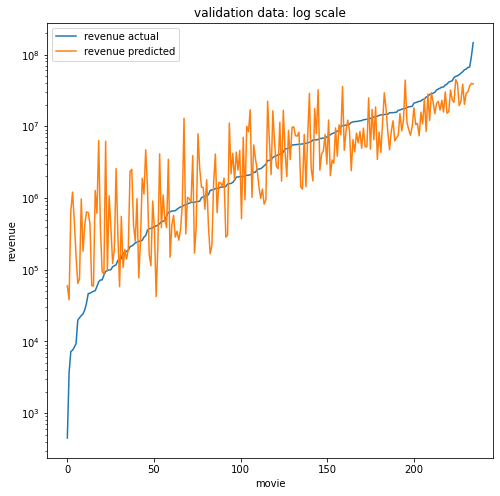

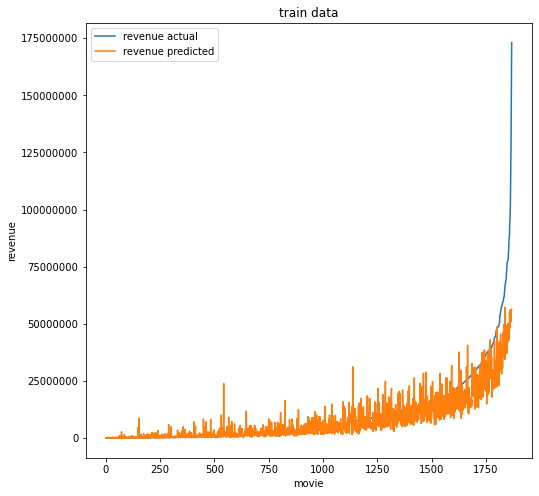

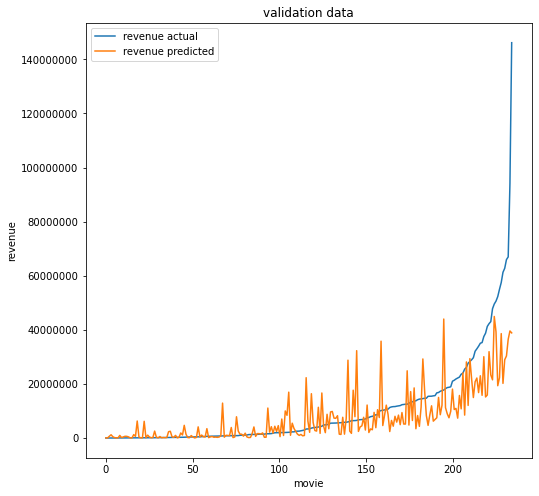

Epoch 00289: early stopping
-----------------------------------------------
output NN
train
mape: 200.453
mae: 0.412
rmse: 0.512
adj_r2: 0.702
test
mape: 125.609
mae: 0.458
rmse: 0.551
adj_r2: -7.359


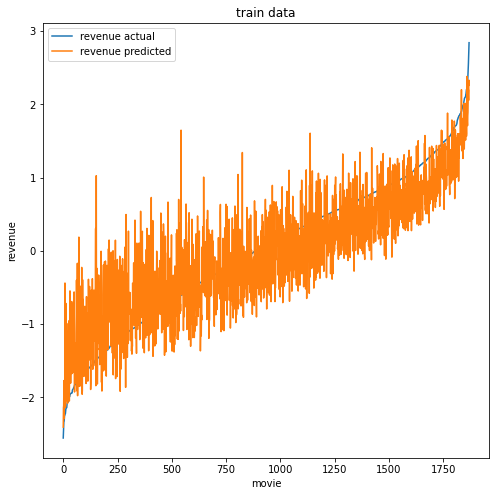

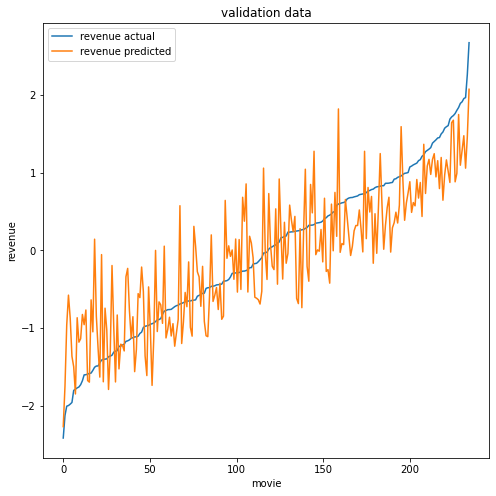

train
mape: 330.118
mae: 4,771,689.566
rmse: 8,556,617.639
adj_r2: 0.681
test
mape: 304.953
mae: 5,900,147.637
rmse: 11,365,491.366
adj_r2: -11.546


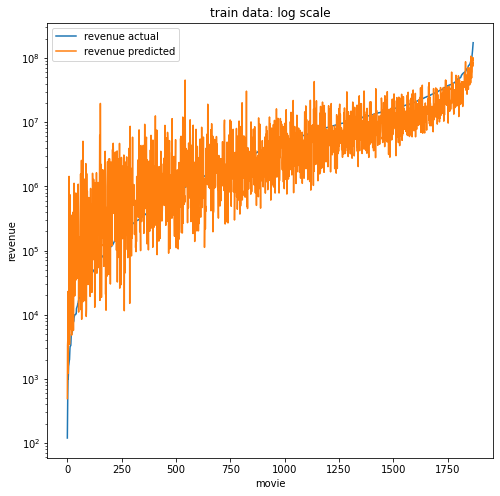

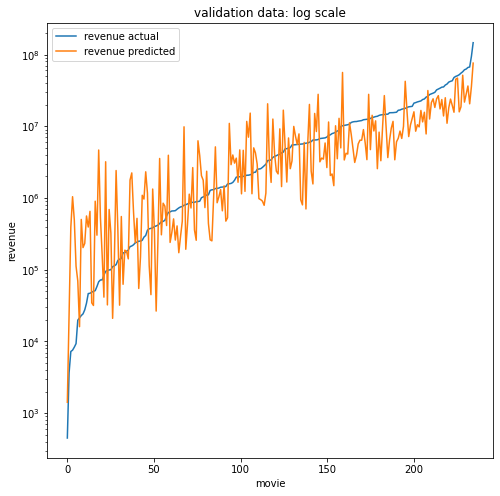

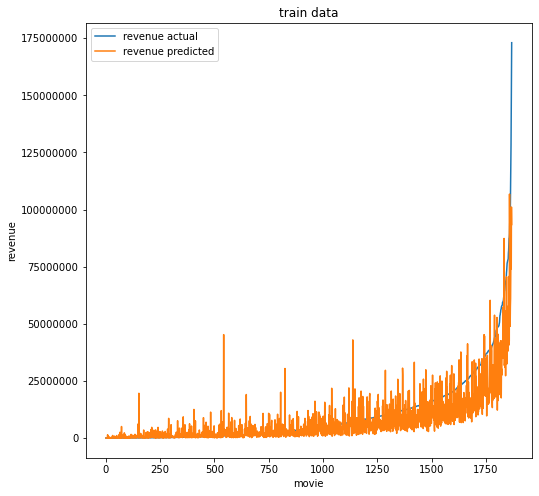

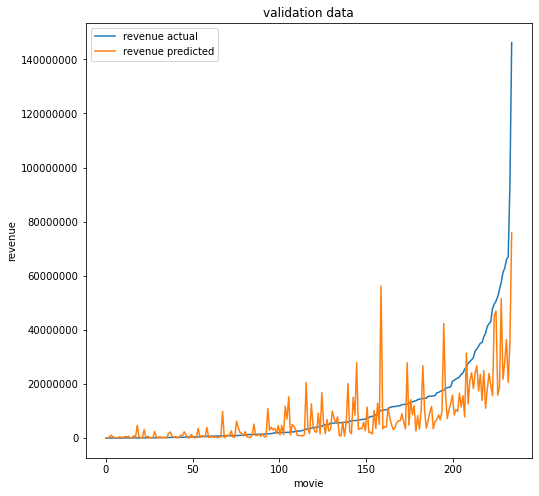

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dataset_profitability_positive.csv
-----------------------------------------------
output LGBMRegressor
train
mape: 275.746
mae: 0.224
rmse: 0.288
adj_r2: 0.912
test
mape: 206.092
mae: 0.360
rmse: 0.462
adj_r2: 0.600


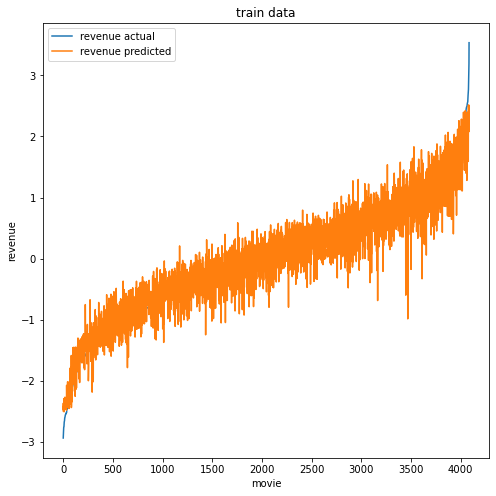

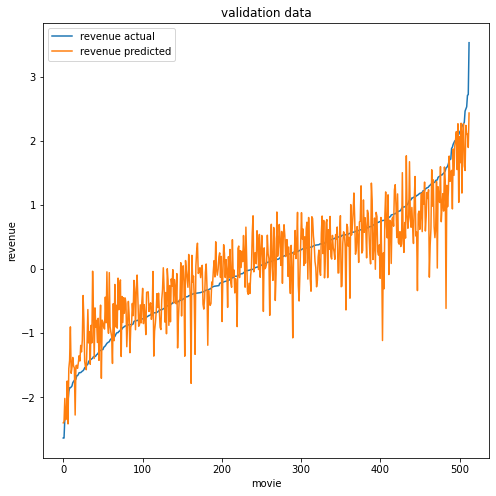

train
mape: 49.860
mae: 33,728,686.654
rmse: 83,171,335.195
adj_r2: 0.785
test
mape: 85.775
mae: 52,045,319.310
rmse: 125,462,809.143
adj_r2: 0.404


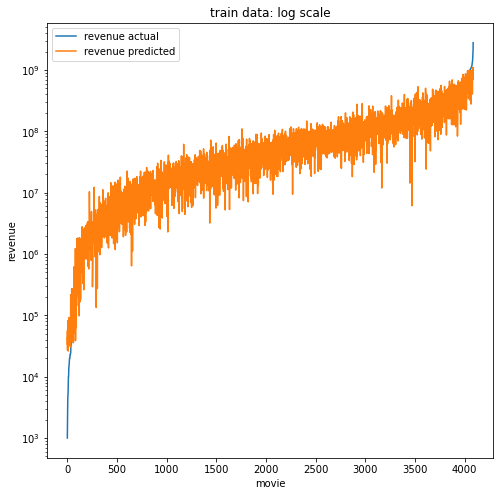

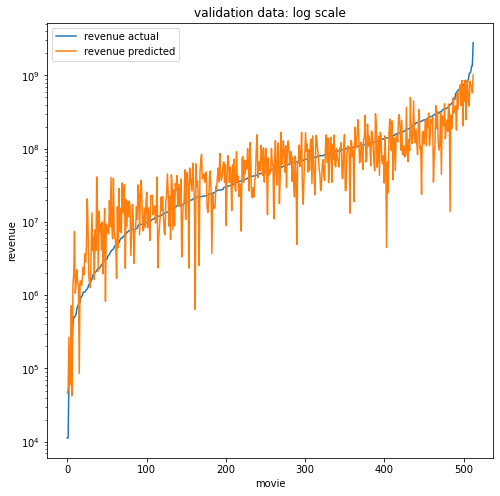

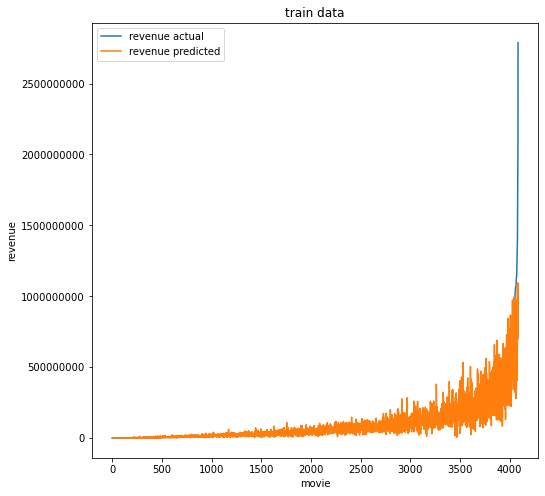

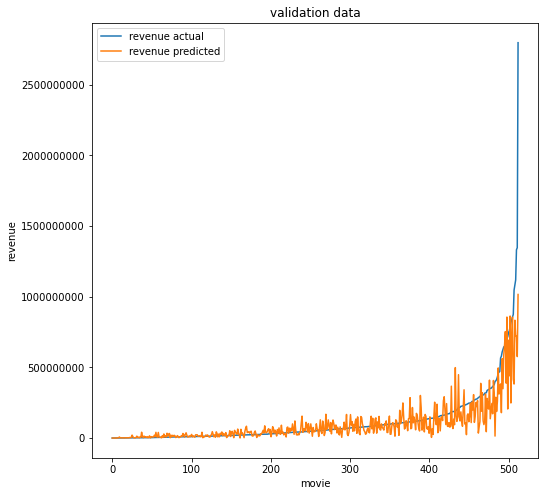

Epoch 00123: early stopping
-----------------------------------------------
output NN
train
mape: 461.727
mae: 0.331
rmse: 0.424
adj_r2: 0.810
test
mape: 190.032
mae: 0.351
rmse: 0.449
adj_r2: 0.621


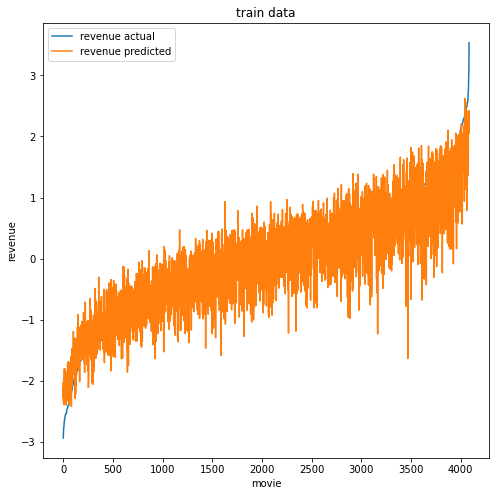

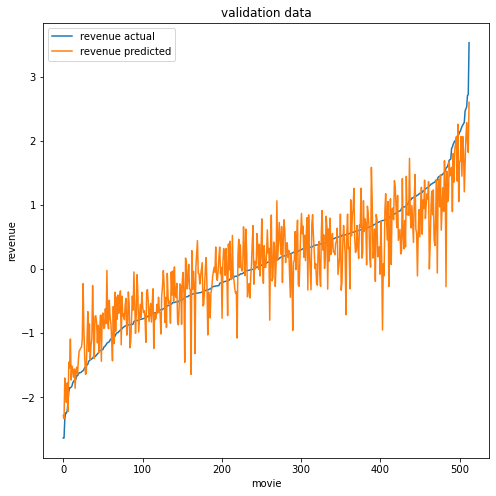

train
mape: 90.773
mae: 46,682,741.363
rmse: 104,992,640.787
adj_r2: 0.657
test
mape: 83.288
mae: 52,930,610.713
rmse: 124,122,539.498
adj_r2: 0.417


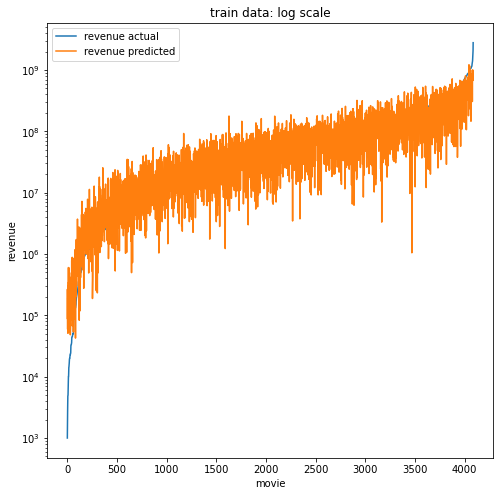

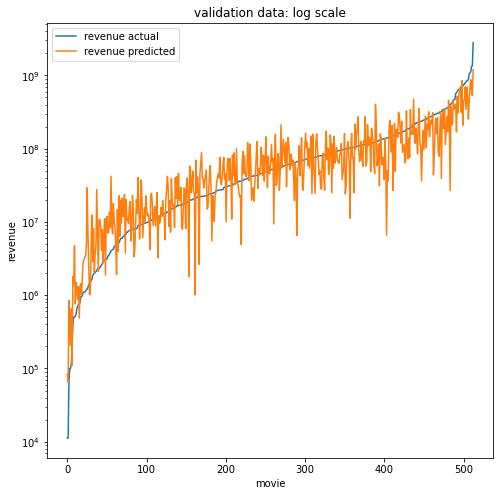

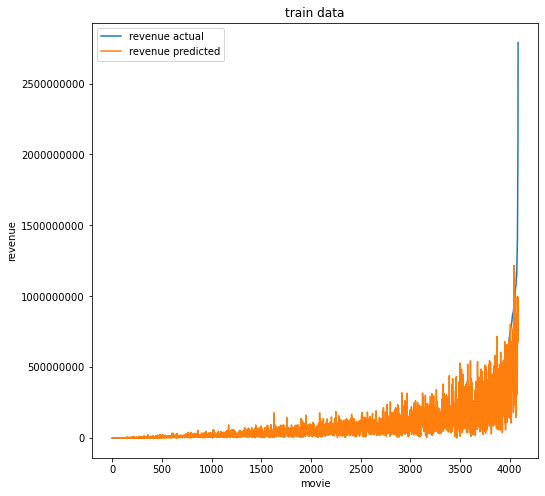

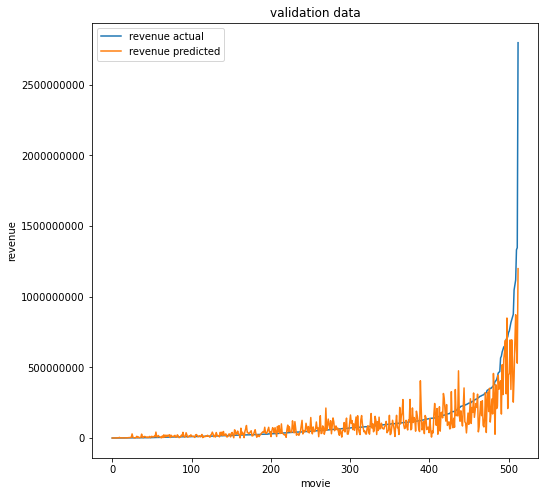

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dataset_revenue_1percentile.csv
-----------------------------------------------
output LGBMRegressor
train
mape: 188.189
mae: 0.319
rmse: 0.413
adj_r2: 0.823
test
mape: 331.205
mae: 0.471
rmse: 0.600
adj_r2: 0.496


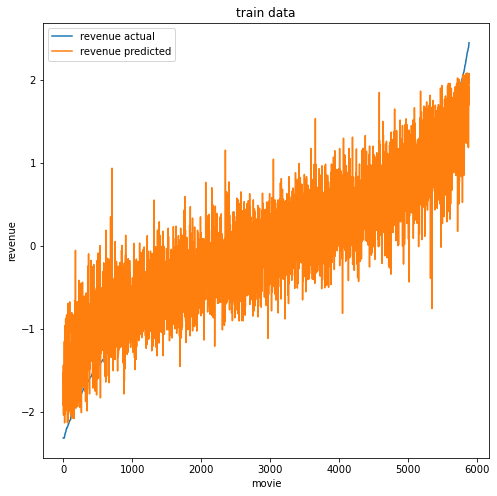

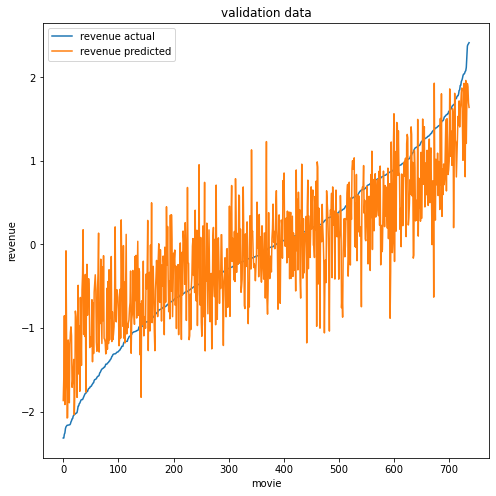

train
mape: 198.992
mae: 28,128,877.089
rmse: 61,101,111.153
adj_r2: 0.715
test
mape: 554.911
mae: 35,816,642.899
rmse: 71,865,986.310
adj_r2: 0.411


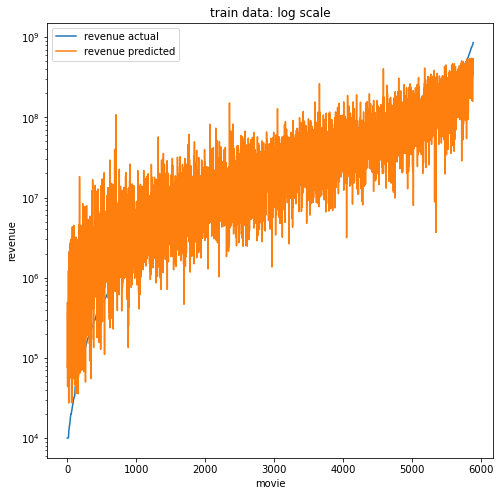

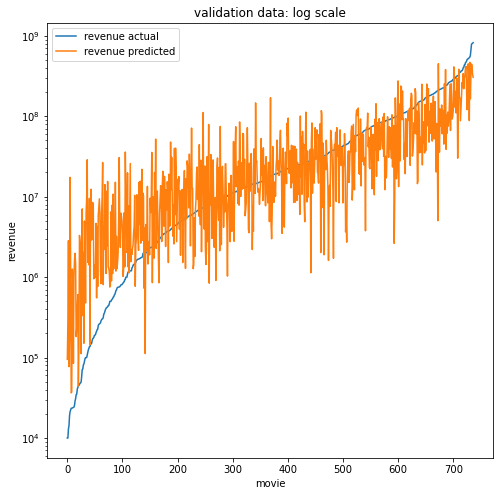

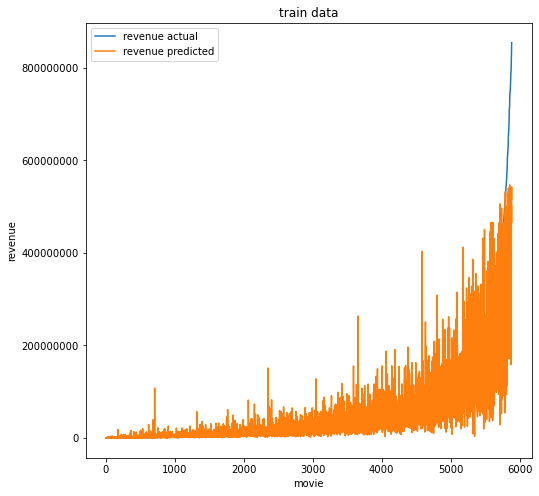

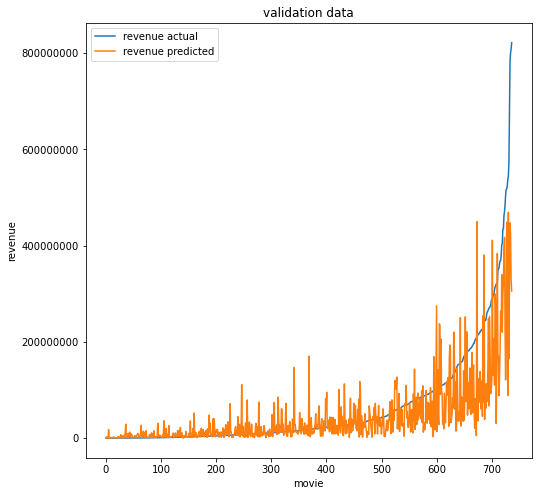

Epoch 00157: early stopping
-----------------------------------------------
output NN
train
mape: 275.685
mae: 0.448
rmse: 0.578
adj_r2: 0.652
test
mape: 295.539
mae: 0.468
rmse: 0.595
adj_r2: 0.505


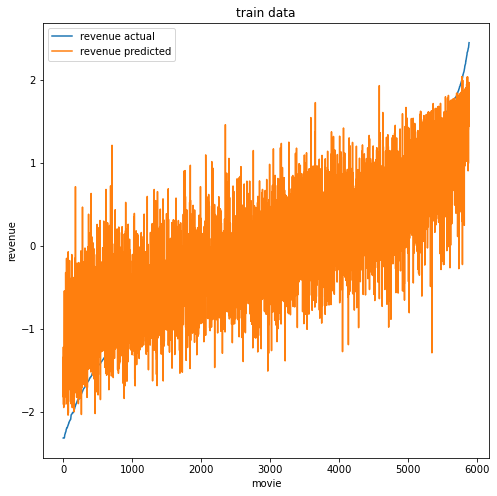

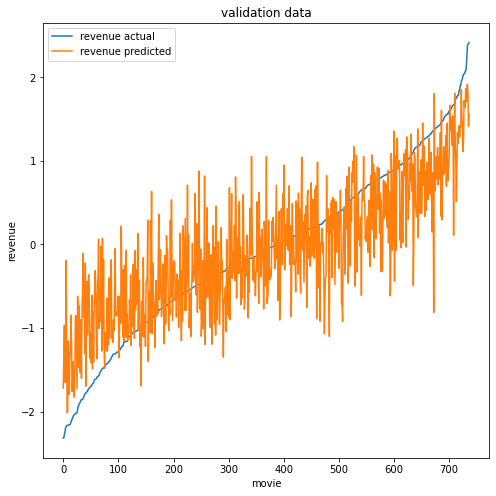

train
mape: 476.072
mae: 36,465,114.528
rmse: 75,862,181.536
adj_r2: 0.561
test
mape: 491.990
mae: 35,439,798.960
rmse: 71,169,254.454
adj_r2: 0.422


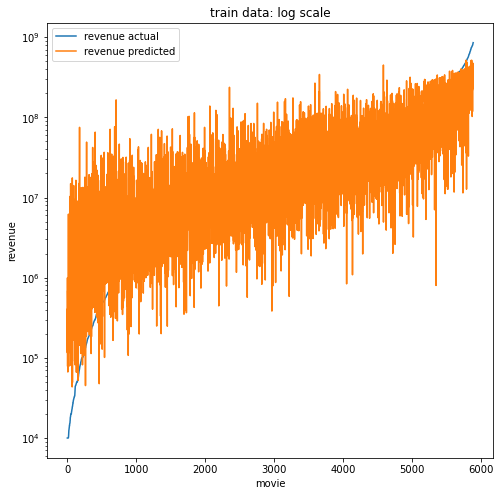

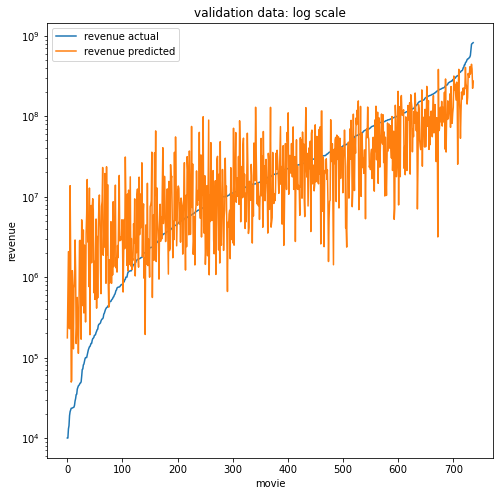

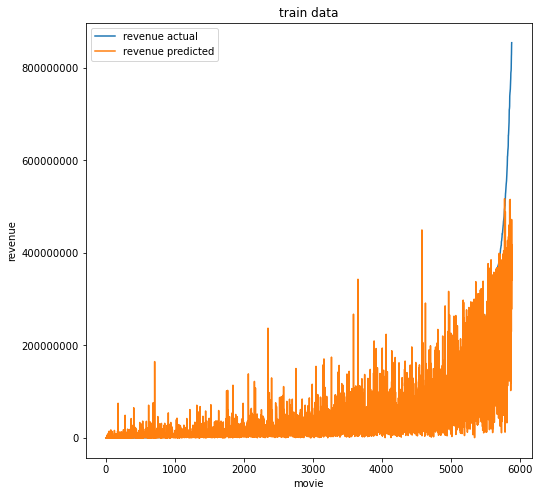

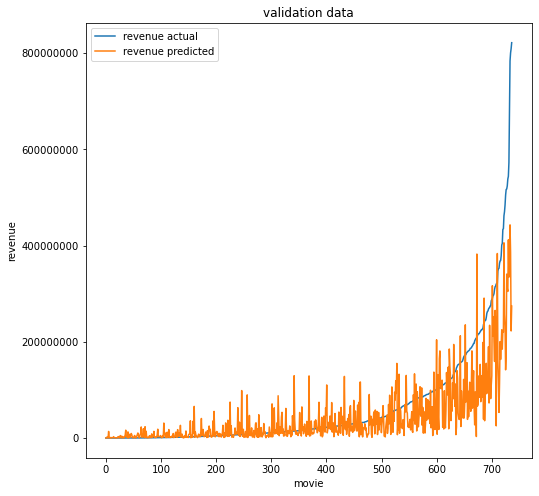

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dataset_revenue_5percentile.csv
-----------------------------------------------
output LGBMRegressor
train
mape: 174.222
mae: 0.348
rmse: 0.444
adj_r2: 0.795
test
mape: 211.637
mae: 0.514
rmse: 0.658
adj_r2: 0.354


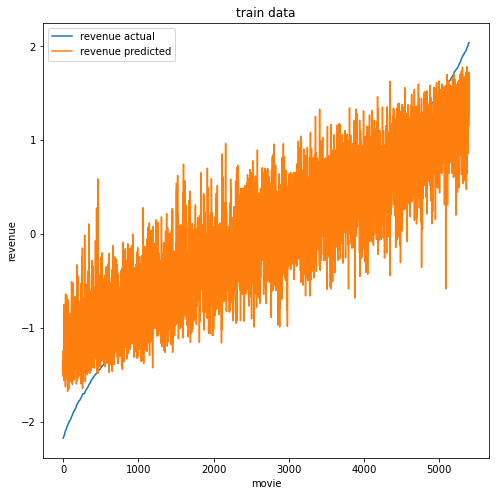

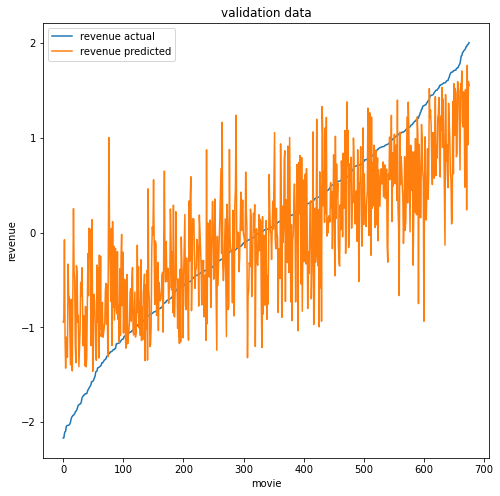

train
mape: 114.252
mae: 21,377,630.324
rmse: 40,453,685.397
adj_r2: 0.649
test
mape: 255.661
mae: 29,618,286.794
rmse: 51,362,477.996
adj_r2: 0.201


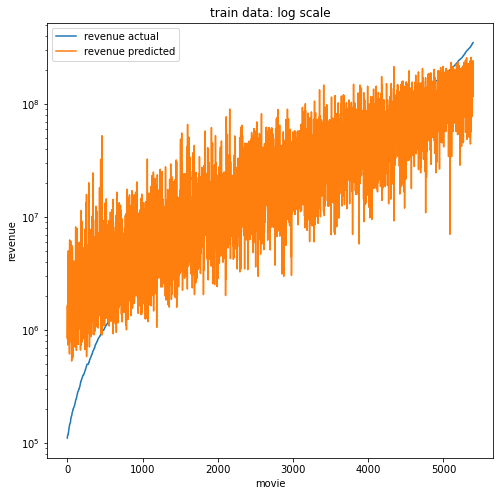

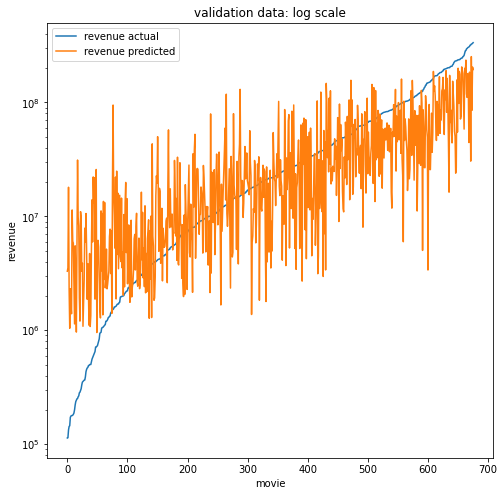

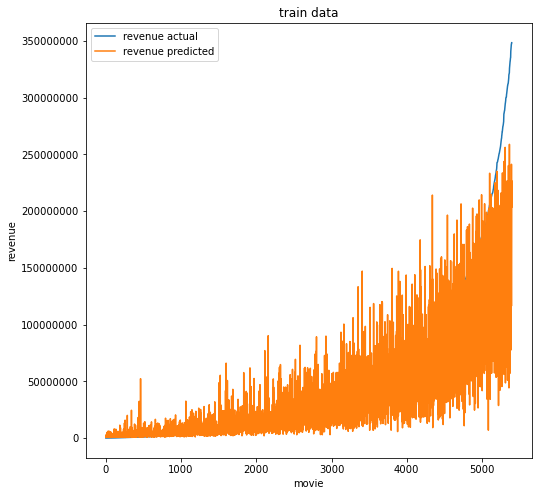

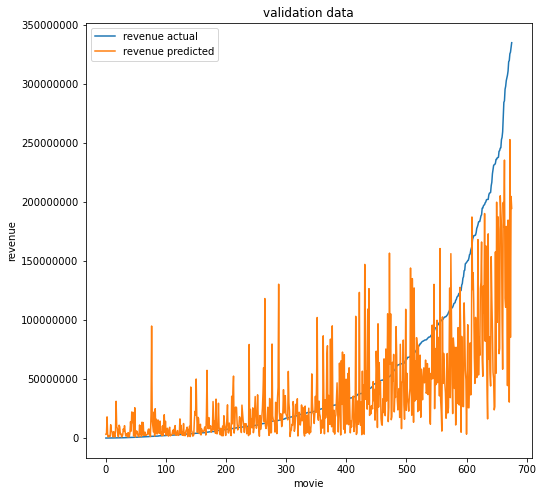

Epoch 00257: early stopping
-----------------------------------------------
output NN
train
mape: 241.357
mae: 0.493
rmse: 0.633
adj_r2: 0.582
test
mape: 208.557
mae: 0.506
rmse: 0.647
adj_r2: 0.375


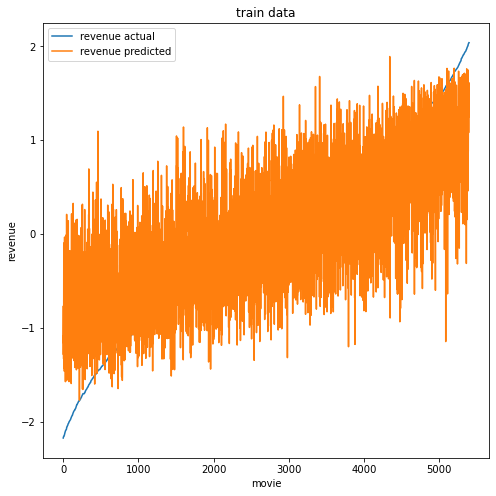

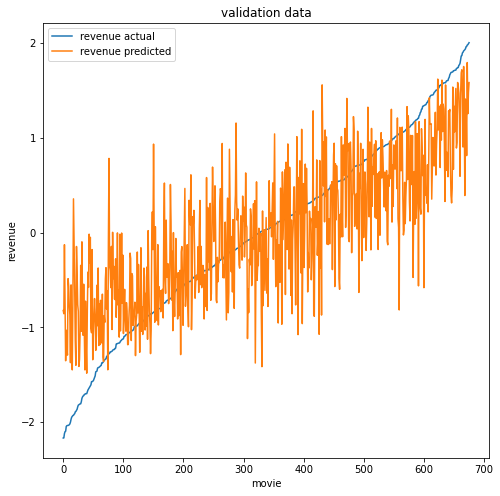

train
mape: 250.579
mae: 28,044,494.492
rmse: 49,528,380.037
adj_r2: 0.474
test
mape: 264.682
mae: 28,818,383.860
rmse: 49,446,855.435
adj_r2: 0.260


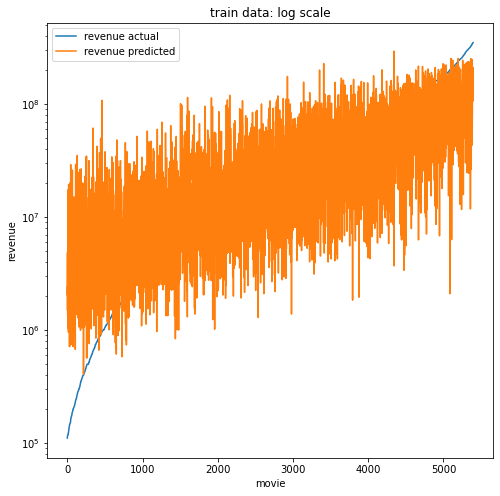

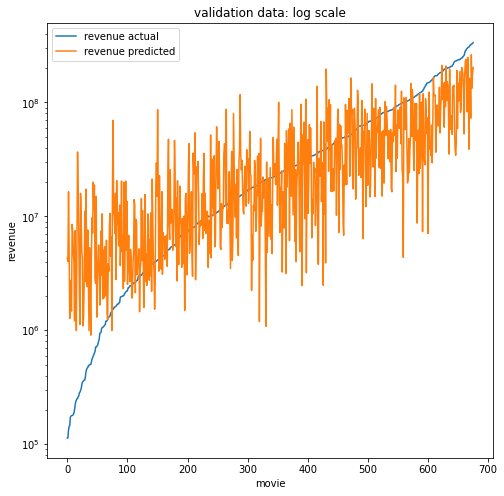

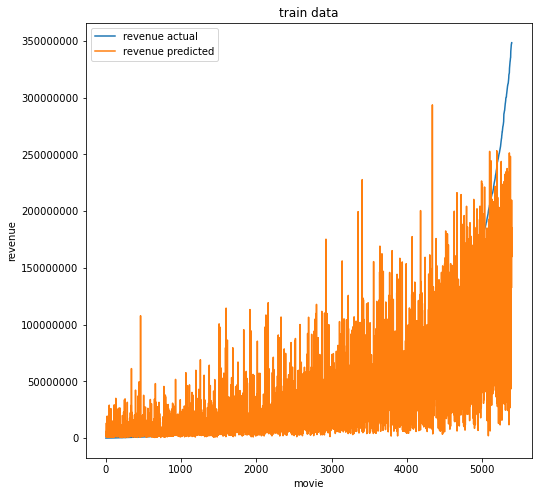

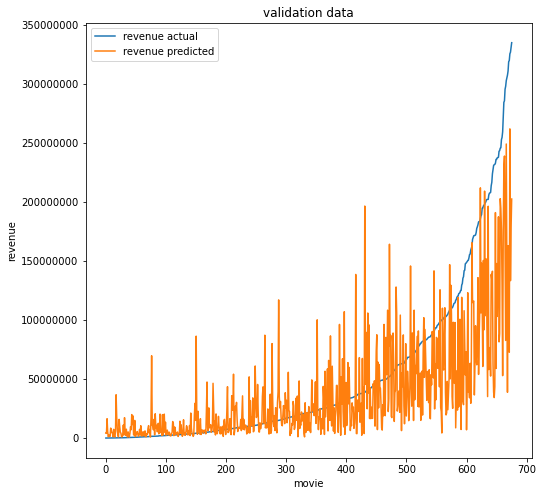

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dataset_years1970-1999.csv
-----------------------------------------------
output LGBMRegressor
train
mape: 124.886
mae: 0.297
rmse: 0.386
adj_r2: 0.827
test
mape: 685.074
mae: 0.524
rmse: 0.657
adj_r2: 5.299


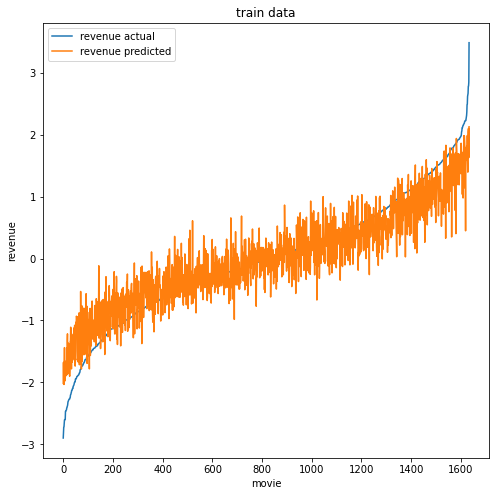

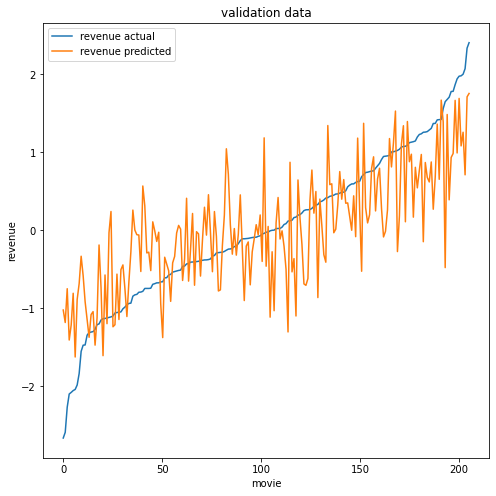

train
mape: 133.811
mae: 25,419,552.498
rmse: 69,909,001.105
adj_r2: 0.557
test
mape: 486.677
mae: 37,754,064.554
rmse: 71,131,418.874
adj_r2: 6.107


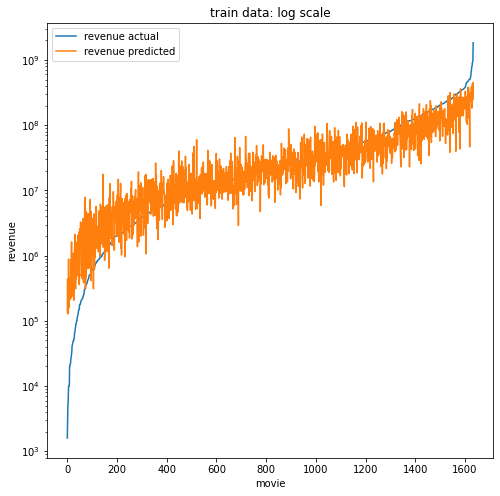

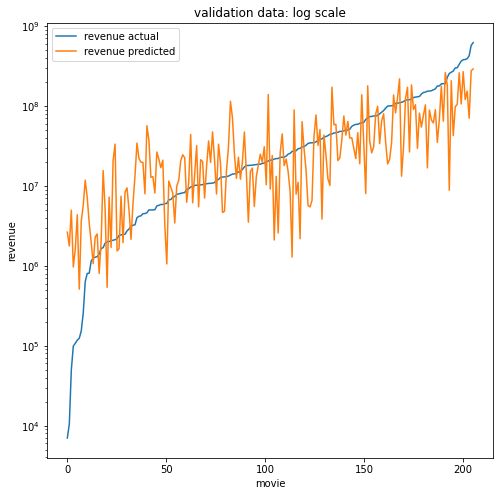

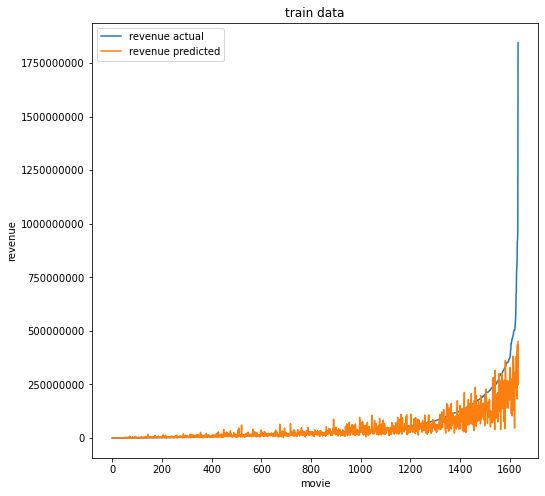

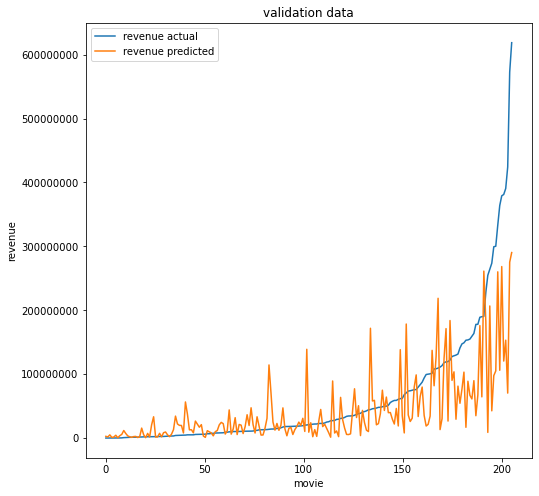

Epoch 00338: early stopping
-----------------------------------------------
output NN
train
mape: 208.391
mae: 0.435
rmse: 0.559
adj_r2: 0.637
test
mape: 708.591
mae: 0.528
rmse: 0.653
adj_r2: 5.235


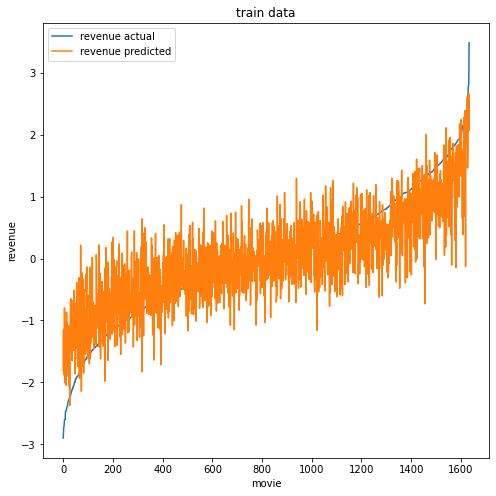

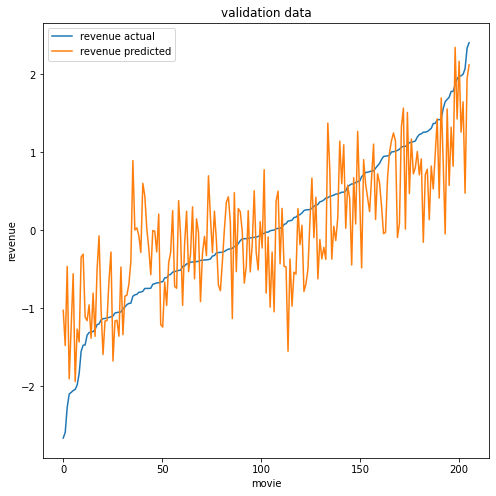

train
mape: 319.646
mae: 31,037,857.031
rmse: 66,983,331.945
adj_r2: 0.593
test
mape: 475.945
mae: 36,655,620.240
rmse: 65,243,645.749
adj_r2: 5.296


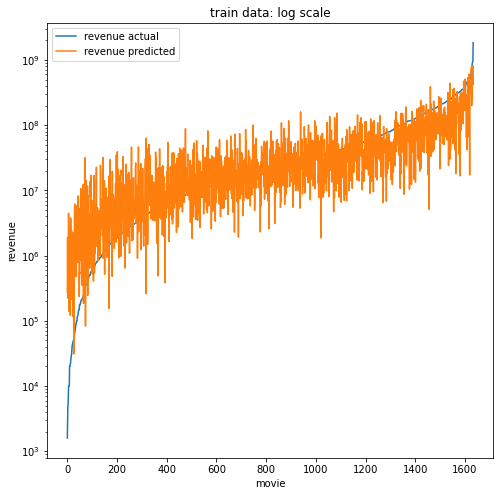

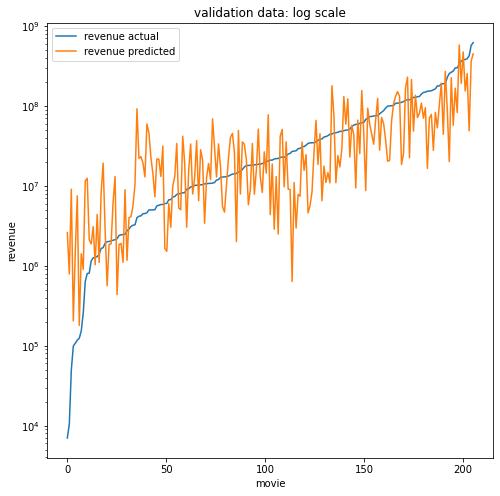

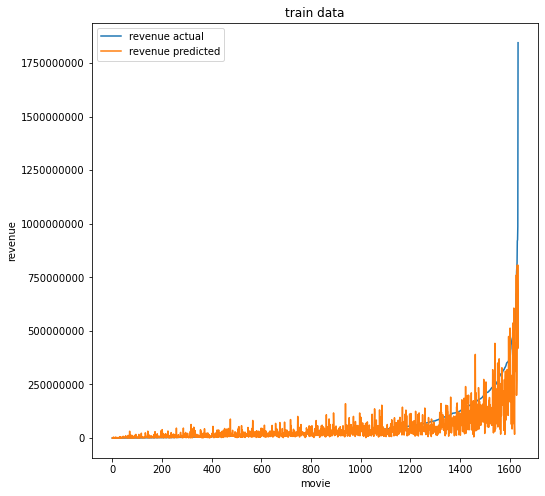

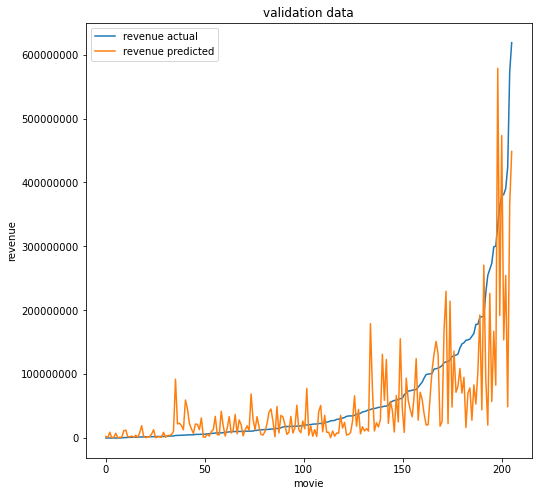

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
dataset_years2000-2018.csv
-----------------------------------------------
output LGBMRegressor
train
mape: 169.287
mae: 0.268
rmse: 0.346
adj_r2: 0.873
test
mape: 131.164
mae: 0.403
rmse: 0.531
adj_r2: 0.505


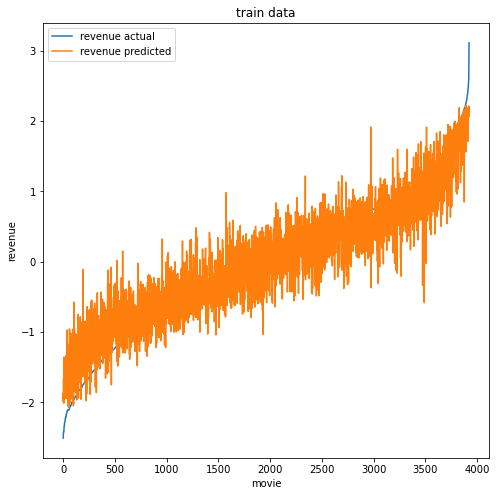

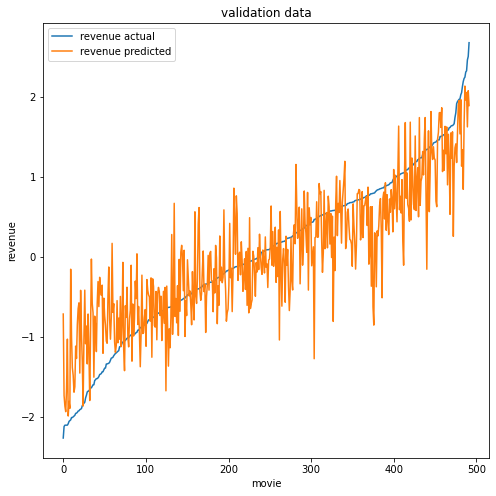

train
mape: 205.935
mae: 31,711,842.336
rmse: 83,763,921.438
adj_r2: 0.765
test
mape: 859.301
mae: 47,666,991.641
rmse: 115,070,882.145
adj_r2: 0.295


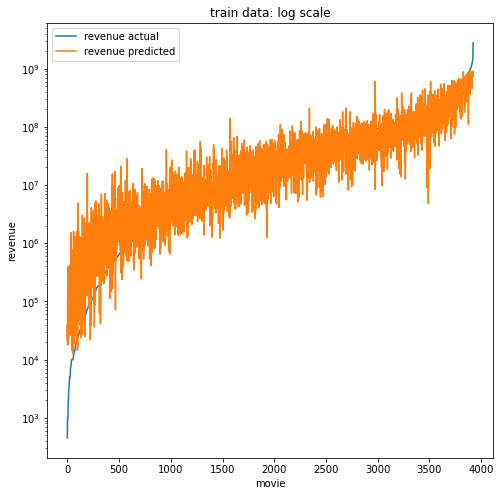

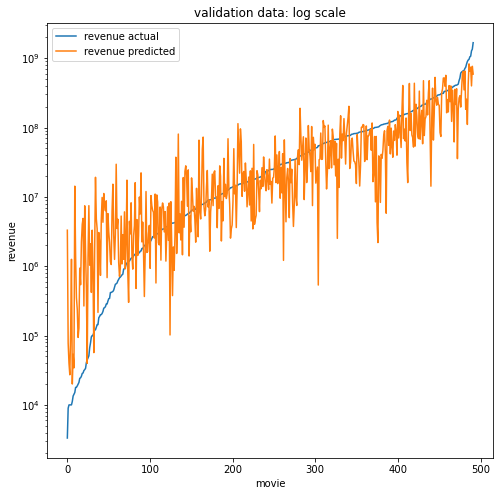

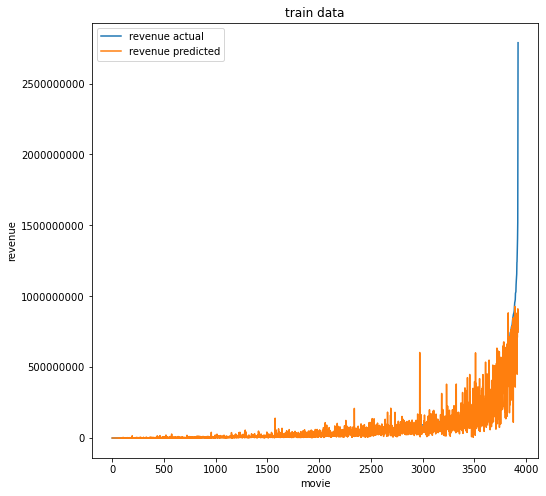

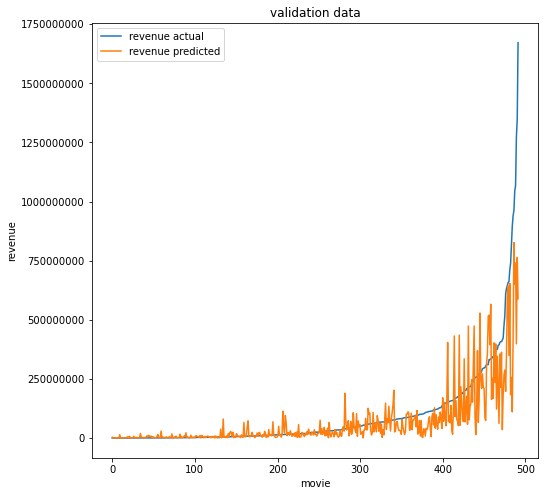

Epoch 00241: early stopping
-----------------------------------------------
output NN
train
mape: 221.678
mae: 0.402
rmse: 0.522
adj_r2: 0.711
test
mape: 146.278
mae: 0.404
rmse: 0.528
adj_r2: 0.510


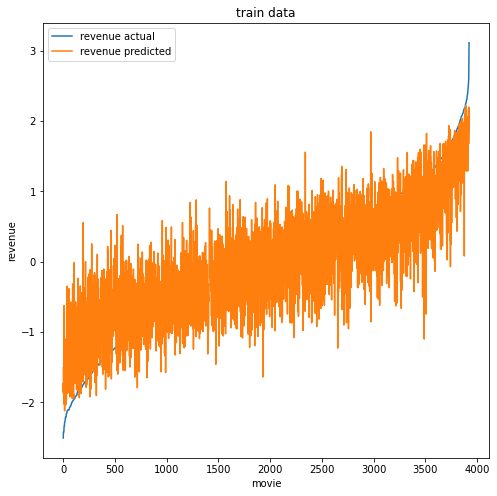

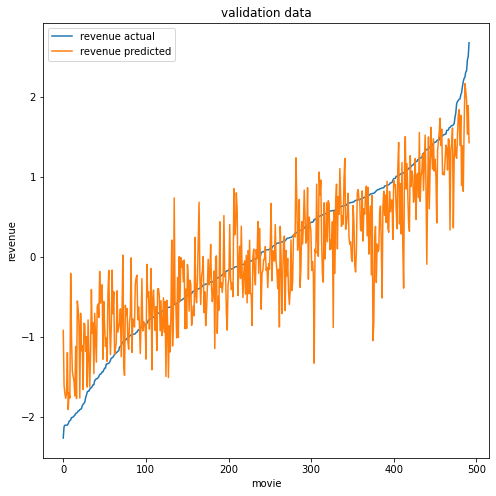

train
mape: 661.926
mae: 42,352,044.734
rmse: 105,305,649.046
adj_r2: 0.628
test
mape: 643.157
mae: 47,541,842.175
rmse: 122,569,056.609
adj_r2: 0.200


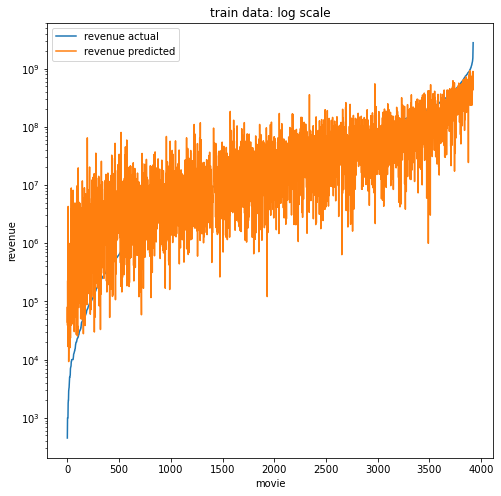

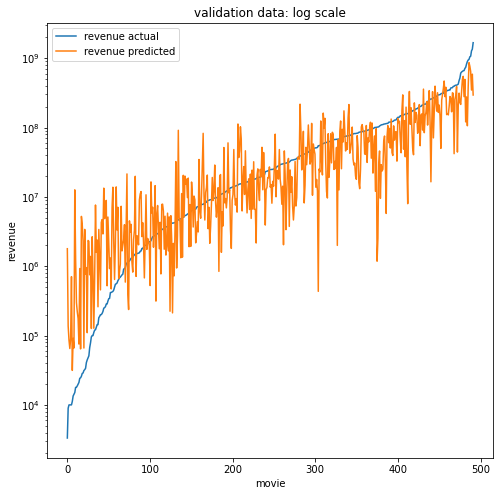

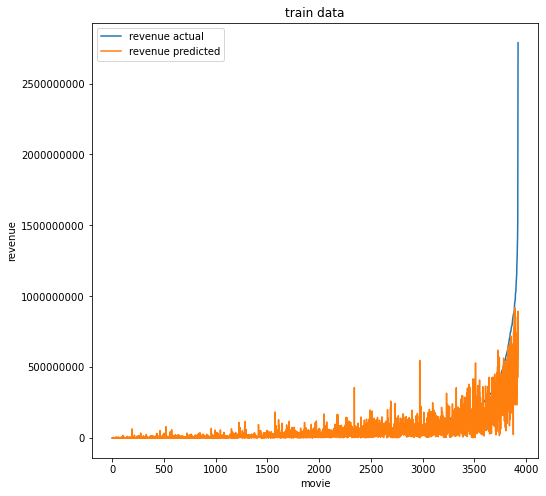

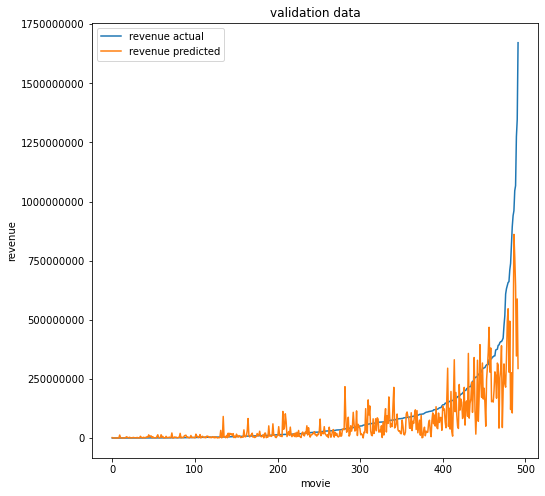

In [201]:
for dataset in datasets:
    name = dataset.replace('.csv', '')
    if name in ['dataset_all', 'dataset_us', 'dataset_gb']:
        continue
    
    with open(f'processed/{name}_data.pickle', 'rb') as handle:
        data = pickle.load(handle)
    
    with open(f'processed/{name}_process.pickle', 'rb') as handle:
        process = pickle.load(handle)
    
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
    print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
    print(dataset)
    run_lgb()
    run_nn()

In [200]:
def run_lgb():
    mod_lgb = lgb.LGBMRegressor(
        objective='regression',
        num_leaves=34,
        learning_rate=0.001, 
        n_estimators=7500,
        max_bin=192,
        max_depth=0,
        min_child_samples=160,
        min_child_weight=0.001,
        bagging_fraction=0.98,
        bagging_freq=15, 
        feature_fraction=0.77,
        metric='l2',
        bagging_seed=9,
        min_data_in_leaf=1, 
        min_sum_hessian_in_leaf=50,
        colsample_bytree=0.87,
        reg_alpha=0.18,
        reg_lambda=30,
        subsample=0.39,
        tree_learner='data',
    )
    mod_lgb.fit(
        data['X_train'].values, 
        data['y_train'],
        verbose=0,
        eval_metric='mse',
        eval_set=[(data['X_test'], data['y_test'])],
        early_stopping_rounds=100
    )
    print('-----------------------------------------------')
    print('output LGBMRegressor')
    output_metrics(mod_lgb, data, process, with_val=True)

In [22]:
def build_nn_model():
    adamax = keras.optimizers.Adamax(learning_rate=0.001,beta_1=0.958,beta_2=0.987)
    model = tf.keras.Sequential([
    Dense(
        256, 
        activation='sigmoid', 
        input_shape=[len(data['X_train'].keys())],
        kernel_initializer='glorot_normal',
        kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
        bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
    ),
    Dropout(0.005),
    Dense(
        256, 
        activation='sigmoid',
        kernel_initializer='glorot_normal',
        kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
        bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
    ),
    Dropout(0.5),  
    Dense(
        1,
        kernel_initializer='glorot_normal',
        activation='linear'
    )
    ])

    model.compile(loss='mse',
                optimizer=adamax,
                metrics=['mae', 'mse'])
    return model


def run_nn():
    model3 = build_nn_model()
    # model3.summary()

    es = EarlyStopping(
        monitor='val_loss', 
        mode='min', 
        verbose=1, 
        patience=20)

    history = model3.fit(
        data['X_train'], data['y_train'],
        epochs=10000, 
        validation_data=(data['X_test'], data['y_test']),
        verbose=0,
        batch_size=256,
        shuffle=True,
#         callbacks=[tfdocs.modeling.EpochDots(), es])
        callbacks=[es])
    print('-----------------------------------------------')
    print('output NN')
    output_metrics(model3, data, process, with_val=True)

In [8]:
# DT model selection
from scipy.stats import randint as sp_randint

random_grid = {
               'bootstrap': [True, False],
               'max_depth': sp_randint(5, 300),
               'min_samples_leaf': sp_randint(1, 20),
               'min_samples_split': sp_randint(10, 100),
               'n_estimators': [100, 500, 1000],
}

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rf = RandomForestRegressor(
    criterion='mae',
    n_jobs=-1,
    random_state=0,
    verbose=1,    
)
rf_random = RandomizedSearchCV(
    scoring='neg_mean_absolute_error',
    estimator = rf, 
    param_distributions = random_grid, 
    n_iter = 100, 
    n_jobs=-1,
    cv = 3, 
    refit=True,
    verbose=True, 
    random_state=42, 
)
rf_random.fit(
    data['X_train'], 
    data['y_train'], 
)

In [105]:
def learning_rate_010_decay_power_099(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_010_decay_power_0995(current_iter):
    base_learning_rate = 0.1
    lr = base_learning_rate  * np.power(.995, current_iter)
    return lr if lr > 1e-3 else 1e-3

def learning_rate_005_decay_power_099(current_iter):
    base_learning_rate = 0.05
    lr = base_learning_rate  * np.power(.99, current_iter)
    return lr if lr > 1e-3 else 1e-3

In [11]:
import lightgbm as lgb
fit_params={"early_stopping_rounds":25, 
            "eval_metric" : 'mse', 
            "eval_set" : [(data['X_test'], data['y_test'])],
#             'callbacks': [lgb.reset_parameter(learning_rate=learning_rate_010_decay_power_099)],
            'verbose': 100,
}

In [ ]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
param_test ={
    'num_leaves': sp_randint(5, 1000), 
    'max_depth': sp_randint(5, 100),
    'max_bin': sp_randint(100, 1000),
    'min_child_samples': sp_randint(100, 400), 
    'learning_rate': sp_uniform(loc=0.0001, scale=0.0999),
#     'num_iterations': [2500, 5000, 7500, 10000],
    'min_child_weight': [1e-4, 1e-3, 1e-2, 1e-1, 1, 1e1],
    'min_child_samples': sp_randint(100, 400), 
    'subsample': sp_uniform(loc=0.3, scale=0.5), 
    'colsample_bytree': sp_uniform(loc=0.6, scale=0.3),
    'reg_alpha': sp_uniform(loc=0, scale=5),
    'reg_lambda': sp_randint(1, 50),
    'bagging_fraction': sp_uniform(loc=0.7, scale=0.3),
    'bagging_freq': sp_randint(5, 20),
    'feature_fraction': sp_uniform(loc=0.5, scale=0.5),
    'min_data_in_leaf': sp_randint(1, 500),
    'min_sum_hessian_in_leaf': sp_randint(1, 100),
}

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

clf = lgb.LGBMRegressor(
    num_threads=12,
    random_state=314, 
    silent=True, 
    n_jobs=-1,
    verbose=4,
    tree_learner='data',
# #     num_leaves=
#     max_depth=-1,
#     learning_rate=0.001,
#     num_iterations=100000,
#     min_child_weight=10,
# #     min_child_samples=
#     subsample=0.4,
#     colsample_bytree=0.73,
#     reg_alpha=3.15,
#     reg_lambda=26,
# #     max_bin=
#     bagging_fraction=0.96,
#     bagging_freq=6,
#     feature_fraction=0.6,
#     min_data_in_leaf=50,
#     min_sum_hessian_in_leaf=50,
)
gs = RandomizedSearchCV(
    estimator=clf, 
    param_distributions=param_test, 
    n_iter=1000,
    cv=3,
    refit=True,
    random_state=314,
    verbose=True)

In [ ]:
gs.fit(
    data['X_train'], 
    data['y_train'], 
    **fit_params,
)

In [ ]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [ ]:
print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

In [150]:
import lightgbm as lgb
mod_lgb = lgb.LGBMRegressor(
#     boosting='dart',
    num_iterations=50000,
    objective='regression',
    bagging_fraction=0.937,
    bagging_freq=14, 
    colsample_bytree=0.609,
    feature_fraction=0.626,
    learning_rate=0.086, 
    max_bin=117,
    max_depth=74,
    min_child_samples=169,
    min_child_weight=0.01,
    min_data_in_leaf=72, 
    min_sum_hessian_in_leaf=34,
#     n_estimators=2500,
    num_leaves=411,
    reg_alpha=0.5,
    reg_lambda=44,
    subsample=0.63,
    feature_fraction_seed=9,
    bagging_seed=9,
    tree_learner='data',
)
mod_lgb.fit(
    data['X_train'].values, 
    data['y_train'],
    verbose=2,
    eval_metric='rmse',
    eval_set=(data['X_test'], data['y_test']),
    early_stopping_rounds=100,
)

/home/stas/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 100 rounds
[2]	valid_0's rmse: 0.886176	valid_0's l2: 0.785308
[4]	valid_0's rmse: 0.820953	valid_0's l2: 0.673964
[6]	valid_0's rmse: 0.773088	valid_0's l2: 0.597664
[8]	valid_0's rmse: 0.73511	valid_0's l2: 0.540386
[10]	valid_0's rmse: 0.701539	valid_0's l2: 0.492157
[12]	valid_0's rmse: 0.675132	valid_0's l2: 0.455804
[14]	valid_0's rmse: 0.653584	valid_0's l2: 0.427173
[16]	valid_0's rmse: 0.636407	valid_0's l2: 0.405014
[18]	valid_0's rmse: 0.624438	valid_0's l2: 0.389923
[20]	valid_0's rmse: 0.612634	valid_0's l2: 0.375321
[22]	valid_0's rmse: 0.604032	valid_0's l2: 0.364854
[24]	valid_0's rmse: 0.597486	valid_0's l2: 0.356989
[26]	valid_0's rmse: 0.592272	valid_0's l2: 0.350787
[28]	valid_0's rmse: 0.588179	valid_0's l2: 0.345955
[30]	valid_0's rmse: 0.582858	valid_0's l2: 0.339723
[32]	valid_0's rmse: 0.57992	valid_0's l2: 0.336307
[34]	valid_0's rmse: 0.576744	valid_0's l2: 0.332634
[36]	valid_0's rmse: 0.574664	valid_0's l2:

LGBMRegressor(bagging_fraction=0.937, bagging_freq=14, bagging_seed=9,
              colsample_bytree=0.609, feature_fraction=0.626,
              feature_fraction_seed=9, learning_rate=0.086, max_bin=117,
              max_depth=74, min_child_samples=169, min_child_weight=0.01,
              min_data_in_leaf=72, min_sum_hessian_in_leaf=34,
              num_iterations=50000, num_leaves=411, objective='regression',
              reg_alpha=0.5, reg_lambda=44, subsample=0.63,
              tree_learner='data')

train
mape: 214.043
mae: 0.291
rmse: 0.377
adj_r2: 0.851
test
mape: 160.619
mae: 0.454
rmse: 0.585
adj_r2: 0.413


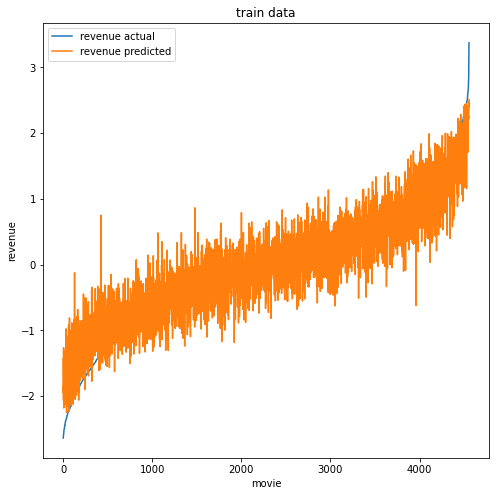

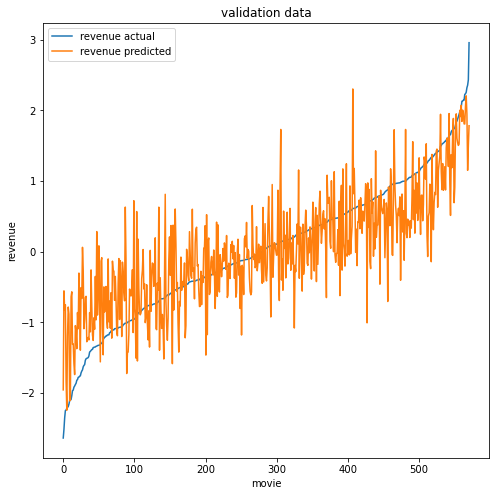

train
mape: 239.416
mae: 35,068,929.632
rmse: 88,195,749.446
adj_r2: 0.757
test
mape: 1,031.227
mae: 49,830,622.536
rmse: 110,328,905.893
adj_r2: 0.286


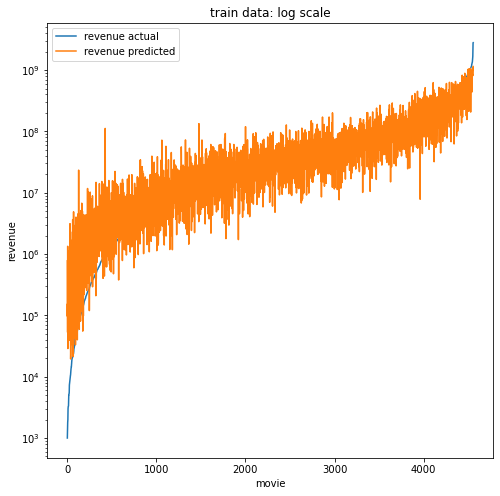

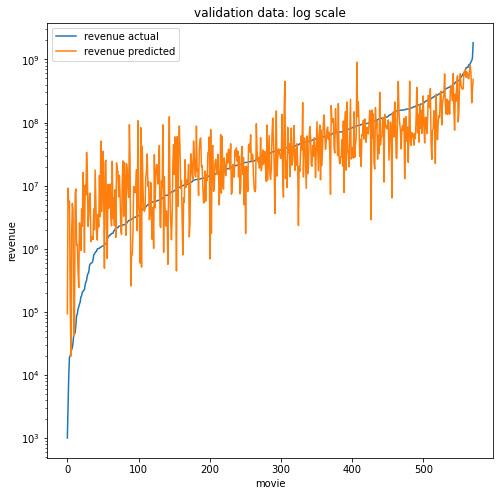

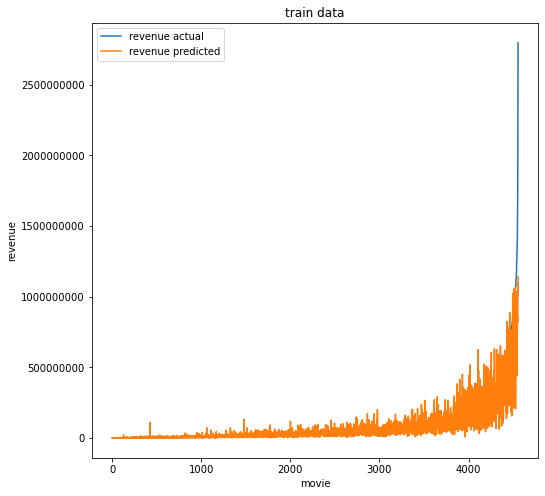

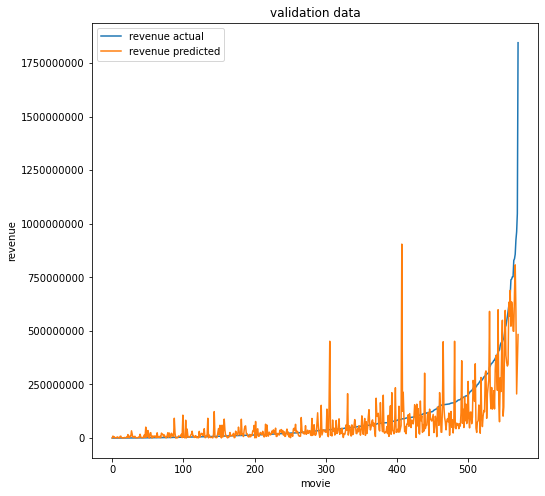

In [174]:
output_metrics(mod_lgb, data, process, with_val=True)

In [175]:
import lightgbm as lgb
mod_lgb = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=34,
    learning_rate=0.001, 
    n_estimators=7500,
    max_bin=192,
    max_depth=0,
    min_child_samples=160,
    min_child_weight=0.001,
    bagging_fraction=0.98,
    bagging_freq=15, 
    feature_fraction=0.77,
    metric='l2',
    bagging_seed=9,
    min_data_in_leaf=1, 
    min_sum_hessian_in_leaf=50,
    colsample_bytree=0.87,
    reg_alpha=0.18,
    reg_lambda=30,
    subsample=0.39,
    tree_learner='data',
)
mod_lgb.fit(
    data['X_train'].values, 
    data['y_train'],
    verbose=2,
    eval_metric='mse',
    eval_set=[(data['X_test'], data['y_test'])],
    early_stopping_rounds=100
)
output_metrics(mod_lgb, data, process, with_val=True)

Training until validation scores don't improve for 100 rounds
[2]	valid_0's l2: 1.03589
[4]	valid_0's l2: 1.03383
[6]	valid_0's l2: 1.03208
[8]	valid_0's l2: 1.03024
[10]	valid_0's l2: 1.0282
[12]	valid_0's l2: 1.02614
[14]	valid_0's l2: 1.02437
[16]	valid_0's l2: 1.02234
[18]	valid_0's l2: 1.02035
[20]	valid_0's l2: 1.01867
[22]	valid_0's l2: 1.01699
[24]	valid_0's l2: 1.01525
[26]	valid_0's l2: 1.01329
[28]	valid_0's l2: 1.01184
[30]	valid_0's l2: 1.00987
[32]	valid_0's l2: 1.00792
[34]	valid_0's l2: 1.00598
[36]	valid_0's l2: 1.00433
[38]	valid_0's l2: 1.00267
[40]	valid_0's l2: 1.00069
[42]	valid_0's l2: 0.99877
[44]	valid_0's l2: 0.997121
[46]	valid_0's l2: 0.995473
[48]	valid_0's l2: 0.993836
[50]	valid_0's l2: 0.992246
[52]	valid_0's l2: 0.990592
[54]	valid_0's l2: 0.988744
[56]	valid_0's l2: 0.987117
[58]	valid_0's l2: 0.985536
[60]	valid_0's l2: 0.983709
[62]	valid_0's l2: 0.981765
[64]	valid_0's l2: 0.980344
[66]	valid_0's l2: 0.978717
[68]	valid_0's l2: 0.977071
[70]	valid_0

[570]	valid_0's l2: 0.67151
[572]	valid_0's l2: 0.670728
[574]	valid_0's l2: 0.669969
[576]	valid_0's l2: 0.669124
[578]	valid_0's l2: 0.668288
[580]	valid_0's l2: 0.66753
[582]	valid_0's l2: 0.666705
[584]	valid_0's l2: 0.665864
[586]	valid_0's l2: 0.66512
[588]	valid_0's l2: 0.66425
[590]	valid_0's l2: 0.663382
[592]	valid_0's l2: 0.662647
[594]	valid_0's l2: 0.661913
[596]	valid_0's l2: 0.661062
[598]	valid_0's l2: 0.660218
[600]	valid_0's l2: 0.659471
[602]	valid_0's l2: 0.658675
[604]	valid_0's l2: 0.657955
[606]	valid_0's l2: 0.657243
[608]	valid_0's l2: 0.656462
[610]	valid_0's l2: 0.655782
[612]	valid_0's l2: 0.654994
[614]	valid_0's l2: 0.654202
[616]	valid_0's l2: 0.653521
[618]	valid_0's l2: 0.652704
[620]	valid_0's l2: 0.6519
[622]	valid_0's l2: 0.651245
[624]	valid_0's l2: 0.650536
[626]	valid_0's l2: 0.649872
[628]	valid_0's l2: 0.64917
[630]	valid_0's l2: 0.648361
[632]	valid_0's l2: 0.647554
[634]	valid_0's l2: 0.646882
[636]	valid_0's l2: 0.6461
[638]	valid_0's l2: 0.6

[1146]	valid_0's l2: 0.514697
[1148]	valid_0's l2: 0.51434
[1150]	valid_0's l2: 0.513968
[1152]	valid_0's l2: 0.513619
[1154]	valid_0's l2: 0.513241
[1156]	valid_0's l2: 0.512935
[1158]	valid_0's l2: 0.512564
[1160]	valid_0's l2: 0.512244
[1162]	valid_0's l2: 0.511921
[1164]	valid_0's l2: 0.51159
[1166]	valid_0's l2: 0.511231
[1168]	valid_0's l2: 0.510903
[1170]	valid_0's l2: 0.510565
[1172]	valid_0's l2: 0.510211
[1174]	valid_0's l2: 0.509887
[1176]	valid_0's l2: 0.509525
[1178]	valid_0's l2: 0.509145
[1180]	valid_0's l2: 0.508793
[1182]	valid_0's l2: 0.508411
[1184]	valid_0's l2: 0.508104
[1186]	valid_0's l2: 0.507738
[1188]	valid_0's l2: 0.507373
[1190]	valid_0's l2: 0.506998
[1192]	valid_0's l2: 0.50666
[1194]	valid_0's l2: 0.506393
[1196]	valid_0's l2: 0.506057
[1198]	valid_0's l2: 0.505758
[1200]	valid_0's l2: 0.505416
[1202]	valid_0's l2: 0.505087
[1204]	valid_0's l2: 0.504724
[1206]	valid_0's l2: 0.504382
[1208]	valid_0's l2: 0.504061
[1210]	valid_0's l2: 0.503744
[1212]	valid_

[1698]	valid_0's l2: 0.443545
[1700]	valid_0's l2: 0.443361
[1702]	valid_0's l2: 0.443224
[1704]	valid_0's l2: 0.443047
[1706]	valid_0's l2: 0.442881
[1708]	valid_0's l2: 0.442723
[1710]	valid_0's l2: 0.44257
[1712]	valid_0's l2: 0.442409
[1714]	valid_0's l2: 0.442234
[1716]	valid_0's l2: 0.442068
[1718]	valid_0's l2: 0.441905
[1720]	valid_0's l2: 0.441727
[1722]	valid_0's l2: 0.441548
[1724]	valid_0's l2: 0.441366
[1726]	valid_0's l2: 0.441215
[1728]	valid_0's l2: 0.441062
[1730]	valid_0's l2: 0.440889
[1732]	valid_0's l2: 0.440727
[1734]	valid_0's l2: 0.440552
[1736]	valid_0's l2: 0.440386
[1738]	valid_0's l2: 0.440223
[1740]	valid_0's l2: 0.440058
[1742]	valid_0's l2: 0.439909
[1744]	valid_0's l2: 0.439755
[1746]	valid_0's l2: 0.439608
[1748]	valid_0's l2: 0.439453
[1750]	valid_0's l2: 0.439309
[1752]	valid_0's l2: 0.439165
[1754]	valid_0's l2: 0.439019
[1756]	valid_0's l2: 0.43886
[1758]	valid_0's l2: 0.438686
[1760]	valid_0's l2: 0.438473
[1762]	valid_0's l2: 0.438304
[1764]	valid

[2248]	valid_0's l2: 0.408161
[2250]	valid_0's l2: 0.408084
[2252]	valid_0's l2: 0.407984
[2254]	valid_0's l2: 0.407893
[2256]	valid_0's l2: 0.407795
[2258]	valid_0's l2: 0.407704
[2260]	valid_0's l2: 0.407592
[2262]	valid_0's l2: 0.407508
[2264]	valid_0's l2: 0.407421
[2266]	valid_0's l2: 0.407303
[2268]	valid_0's l2: 0.407191
[2270]	valid_0's l2: 0.4071
[2272]	valid_0's l2: 0.406999
[2274]	valid_0's l2: 0.406883
[2276]	valid_0's l2: 0.406767
[2278]	valid_0's l2: 0.406668
[2280]	valid_0's l2: 0.406568
[2282]	valid_0's l2: 0.406482
[2284]	valid_0's l2: 0.406391
[2286]	valid_0's l2: 0.406309
[2288]	valid_0's l2: 0.406215
[2290]	valid_0's l2: 0.406144
[2292]	valid_0's l2: 0.406055
[2294]	valid_0's l2: 0.405965
[2296]	valid_0's l2: 0.40589
[2298]	valid_0's l2: 0.405809
[2300]	valid_0's l2: 0.405711
[2302]	valid_0's l2: 0.405609
[2304]	valid_0's l2: 0.405512
[2306]	valid_0's l2: 0.405414
[2308]	valid_0's l2: 0.405298
[2310]	valid_0's l2: 0.405215
[2312]	valid_0's l2: 0.405133
[2314]	valid_

KeyboardInterrupt: 

In [ ]:
param_test_etr ={
    'n_estimators': [100, 500, 750, 1000, 5000, 10000],
    'max_depth': sp_randint(1, 200),
    'max_features': sp_randint(10, 225), 
    'min_samples_leaf': sp_randint(1,50), 
    'min_samples_split': sp_randint(1,50),
    'min_weight_fraction_leaf': sp_uniform(0.0, 0.5),
    'max_leaf_nodes': sp_randint(1, 200),
    'min_impurity_decrease': sp_uniform(0.0, 5),
    'ccp_alpha': sp_uniform(0.0, 5),
}

In [ ]:
reg_etr = ExtraTreesRegressor(
    n_jobs=-1, 
    random_state=0,
    verbose=5,
)
reg_etr_gs = RandomizedSearchCV(
    n_jobs=-1, 
    estimator=reg_etr, 
    param_distributions=param_test_etr, 
    n_iter=10,
    cv=5,
    refit=True,
    random_state=314,
    verbose=10)

In [ ]:
%%time

reg_etr_gs.fit(data['X_train'], data['y_train'])

In [ ]:
print('Best score reached: {} with params: {} '.format(reg_etr_gs.best_score_, reg_etr_gs.best_params_))

In [ ]:
etr = ExtraTreesRegressor(
    n_jobs=-1, 
    ccp_alpha=0.32,
    max_depth=10,
    max_features=71, 
    max_leaf_nodes=55,
    min_impurity_decrease=0.35,
    min_samples_leaf=8, 
    min_samples_split=23,
    min_weight_fraction_leaf=0.29,
    n_estimators=5000, 
    
)
etr.fit(data['X_train'].values, data['y_train'])
output_metrics(etr, data, process, with_val=True)

In [63]:
def model(X_train, y_train, X_test, y_test):
    
    model = tf.keras.Sequential()
    model.add(Dense(
        {{choice([128, 192, 256, 512, 1024, 2048])}}, 
        input_shape=[X_train.shape[1]],
        kernel_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},           
        bias_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},  
        kernel_regularizer=l1_l2(
            l1={{uniform(0, 0.1)}}, 
            l2={{uniform(0, 0.1)}}),
        bias_regularizer=l1_l2(
            l1={{uniform(0, 0.1)}}, 
            l2={{uniform(0, 0.1)}}),
        activity_regularizer=l1_l2(
            l1={{uniform(0, 0.1)}}, 
            l2={{uniform(0, 0.1)}})))
    model.add(Activation({{choice(['sigmoid', 'relu', 'tanh'])}}))
    if {{choice(['bn1_yes', 'bn1_no'])}} == 'bn1_yes':
        model.add(BatchNormalization())
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense(
        {{choice([128, 192, 256, 512, 1024, 2048])}},
        kernel_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},           
        bias_initializer={{choice(['zeros', 'glorot_normal', 'he_normal'])}},          
        kernel_regularizer=l1_l2(
            l1={{uniform(0, 0.1)}}, 
            l2={{uniform(0, 0.1)}}),
        bias_regularizer=l1_l2(
            l1={{uniform(0, 0.1)}}, 
            l2={{uniform(0, 0.1)}}),
        activity_regularizer=l1_l2(
            l1={{uniform(0, 0.1)}}, 
            l2={{uniform(0, 0.1)}})))
    model.add(Activation({{choice(['sigmoid', 'relu', 'tanh'])}}))
    if {{choice(['bn2_yes', 'bn2_no'])}} == 'bn2_yes':
        model.add(BatchNormalization())
    model.add(Dropout({{uniform(0, 1)}}))
    model.add(Dense(1))
    
    adamax = keras.optimizers.Adamax(
        learning_rate={{uniform(0.001, 0.1)}},
        beta_1={{uniform(0.75, 1)}},
        beta_2={{uniform(0.75, 1)}})
        
    model.compile(loss='mse', 
                  metrics=['mae'],
                  optimizer=adamax)

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
    model.fit(X_train, y_train,
              batch_size={{choice([16, 32, 64, 128, 256, 512])}},
              epochs=500,
              verbose=2,
              validation_data=(X_test, y_test),
#               validation_split=0.15,
              callbacks=[es])

    mse, mae = model.evaluate(X_test, y_test, verbose=1)
    print('Test mse:', mse)
    return {'loss': mse, 'status': STATUS_OK, 'model': model}

# def model(X_train, y_train, X_test, y_test):
    
#     model = tf.keras.Sequential()
#     model.add(Dense(
#         256,
#         activation='sigmoid', 
#         input_shape=[X_train.shape[1]],
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)))        
#     model.add(Dropout(0.005))
#     model.add(Dense(
#         256,
#         activation='sigmoid',
#         kernel_initializer='glorot_normal', 
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01)))
#     model.add(Dropout(0.5))
        
#     model.add(Dense(
#         1,
#         kernel_initializer='glorot_normal',
#         activation='linear'
#     ))
    
#     adamax = keras.optimizers.Adamax(
#         learning_rate=0.001,
#         beta_1={{uniform(0.9, 1)}},
#         beta_2={{uniform(0.9, 1)}})
        
#     model.compile(loss='mse', 
#                   metrics=['mae'],
#                   optimizer=adamax)

#     es = EarlyStopping(
#         monitor='val_loss', 
#         mode='min', 
#         verbose=1, 
#         patience=20)

#     model.fit(X_train, y_train,
#               batch_size=256,
#               epochs=500,
#               verbose=2,
#               shuffle=True,
#               validation_data=(X_test, y_test),
# #               validation_split=0.15,
#               callbacks=[es])
    
#     mse, mae = model.evaluate(X_test, y_test, verbose=1)
#     print('Test mse:', mse)
#     return {'loss': mse, 'status': STATUS_OK, 'model': model}

In [64]:
best_run = None
best_model = None
space = None
trials=Trials()
best_run, best_model, space = optim.minimize(model=model,
                                      data=get_data,
                                      algo=tpe.suggest,
                                      max_evals=500,
                                      trials=trials,
                                      notebook_name='keras',
                                      eval_space=True,
                                      return_space=True)

>>> Imports:
#coding=utf-8

try:
    import time
except:
    pass

try:
    import pickle
except:
    pass

try:
    from os import listdir
except:
    pass

try:
    from os.path import isfile, join
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import pandas as pd
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from statistics import mean
except:
    pass

try:
    from sklearn import metrics
except:
    pass

try:
    from sklearn.utils import shuffle
except:
    pass

try:
    from sklearn.impute import SimpleImputer
except:
    pass

try:
    from sklearn.neural_network import MLPRegressor
except:
    pass

try:
    from sklearn.preprocessing import MinMaxScaler
except:
    pass

try:
    from sklearn.preprocessing import PowerTransformer
except:
    pass

try:
    from sklearn.preprocessing import RobustScaler
except:
    pass

try:
    from sklearn.experimental import

Epoch 2/500                                            
12/12 - 0s - loss: 1727.2214 - mae: 3.9385 - val_loss: 1238.1790 - val_mae: 2.7168

Epoch 3/500                                            
12/12 - 0s - loss: 1109.6648 - mae: 2.8887 - val_loss: 1049.3245 - val_mae: 1.3059

Epoch 4/500                                            
12/12 - 0s - loss: 983.1348 - mae: 2.1859 - val_loss: 896.6558 - val_mae: 0.8155

Epoch 5/500                                            
12/12 - 0s - loss: 891.0085 - mae: 1.6896 - val_loss: 874.2736 - val_mae: 0.7884

Epoch 6/500                                            
12/12 - 0s - loss: 855.8220 - mae: 0.7625 - val_loss: 833.6716 - val_mae: 0.7378

Epoch 7/500                                            
12/12 - 0s - loss: 826.0043 - mae: 0.8495 - val_loss: 820.4072 - val_mae: 0.8879

Epoch 8/500                                            
12/12 - 0s - loss: 816.6470 - mae: 0.8139 - val_loss: 809.8623 - val_mae: 0.8022

Epoch 9/500                   

Epoch 19/500                                                                     
47/47 - 0s - loss: 40.3914 - mae: 0.6595 - val_loss: 39.7920 - val_mae: 0.5912   

Epoch 20/500                                                                     
47/47 - 0s - loss: 39.8402 - mae: 0.6607 - val_loss: 39.6890 - val_mae: 0.5769   

Epoch 00020: early stopping                                                      
 1/24 [>.............................]                                           
 - ETA: 0s - loss: 39.7020 - mae: 0.6342                                         
                                                                                
24/24 [==============================]                                           
 - 0s 1ms/step - loss: 39.6890 - mae: 0.5769                                     

Test mse:                                                                        
39.688961029052734                                                               
Epoch 1/500   

24/24 - 0s - loss: 33.7253 - mae: 0.8025 - val_loss: 33.4232 - val_mae: 0.7690   

Epoch 8/500                                                                      
24/24 - 0s - loss: 33.5822 - mae: 0.8013 - val_loss: 34.2982 - val_mae: 0.7696   

Epoch 9/500                                                                      
24/24 - 0s - loss: 33.5219 - mae: 0.8014 - val_loss: 32.9457 - val_mae: 0.7691   

Epoch 00009: early stopping                                                      
 1/24 [>.............................]                                           
 - ETA: 0s - loss: 32.7876 - mae: 0.7903                                         
                                                                                
24/24 [==============================]                                           
 - 0s 1ms/step - loss: 32.9457 - mae: 0.7691                                     

Test mse:                                                                        
32.9456787109

Epoch 3/500                                                                      
47/47 - 0s - loss: 6.9988 - mae: 0.8401 - val_loss: 4.4029 - val_mae: 0.7762     

Epoch 4/500                                                                      
47/47 - 0s - loss: 3.6394 - mae: 0.8230 - val_loss: 2.7008 - val_mae: 0.7690     

Epoch 5/500                                                                      
47/47 - 0s - loss: 2.5312 - mae: 0.8208 - val_loss: 2.1784 - val_mae: 0.7746     

Epoch 6/500                                                                      
47/47 - 0s - loss: 2.1798 - mae: 0.8110 - val_loss: 2.0137 - val_mae: 0.7705     

Epoch 7/500                                                                      
47/47 - 0s - loss: 2.0813 - mae: 0.8081 - val_loss: 1.9705 - val_mae: 0.7687     

Epoch 8/500                                                                      
47/47 - 0s - loss: 2.0568 - mae: 0.8056 - val_loss: 1.9840 - val_mae: 0.7750     

Epoch 9/50

Epoch 9/500                                                                       
47/47 - 0s - loss: 5.8341 - mae: 0.8109 - val_loss: 5.7506 - val_mae: 0.7729      

Epoch 10/500                                                                      
47/47 - 0s - loss: 5.8101 - mae: 0.8079 - val_loss: 5.7069 - val_mae: 0.7715      

Epoch 11/500                                                                      
47/47 - 0s - loss: 5.8183 - mae: 0.8185 - val_loss: 5.7577 - val_mae: 0.7934      

Epoch 12/500                                                                      
47/47 - 0s - loss: 5.8259 - mae: 0.8204 - val_loss: 5.7291 - val_mae: 0.7717      

Epoch 13/500                                                                      
47/47 - 0s - loss: 5.8003 - mae: 0.8113 - val_loss: 5.7181 - val_mae: 0.7775      

Epoch 00013: early stopping                                                       
 1/24 [>.............................]                                            

Epoch 90/500                                                                      
47/47 - 0s - loss: 1.6377 - mae: 0.8066 - val_loss: 1.5710 - val_mae: 0.7735      

Epoch 91/500                                                                      
47/47 - 0s - loss: 1.6368 - mae: 0.8109 - val_loss: 1.5523 - val_mae: 0.7689      

Epoch 92/500                                                                      
47/47 - 0s - loss: 1.6325 - mae: 0.8074 - val_loss: 1.5474 - val_mae: 0.7705      

Epoch 93/500                                                                      
47/47 - 0s - loss: 1.6180 - mae: 0.8051 - val_loss: 1.5436 - val_mae: 0.7705      

Epoch 94/500                                                                      
47/47 - 0s - loss: 1.6156 - mae: 0.8058 - val_loss: 1.5363 - val_mae: 0.7694      

Epoch 95/500                                                                      
47/47 - 0s - loss: 1.6123 - mae: 0.8071 - val_loss: 1.5367 - val_mae: 0.7695      

Epoch 10/500                                                                      
47/47 - 0s - loss: 5.6556 - mae: 0.8201 - val_loss: 5.5239 - val_mae: 0.7711      

Epoch 11/500                                                                      
47/47 - 0s - loss: 5.6460 - mae: 0.8161 - val_loss: 5.5557 - val_mae: 0.7687      

Epoch 12/500                                                                      
47/47 - 0s - loss: 5.6658 - mae: 0.8213 - val_loss: 5.5263 - val_mae: 0.7687      

Epoch 13/500                                                                      
47/47 - 0s - loss: 5.6644 - mae: 0.8194 - val_loss: 5.6383 - val_mae: 0.8186      

Epoch 00013: early stopping                                                       
 1/24 [>.............................]                                            
 - ETA: 0s - loss: 5.6349 - mae: 0.8106                                           
                                                                                  


Test mse:                                                                         
117.75534057617188                                                                
Epoch 1/500                                                                       
375/375 - 1s - loss: 513.5911 - mae: 4.5916 - val_loss: 123.1832 - val_mae: 0.7318

Epoch 2/500                                                                       
375/375 - 1s - loss: 63.7528 - mae: 1.2911 - val_loss: 43.4083 - val_mae: 0.6050  

Epoch 3/500                                                                       
375/375 - 1s - loss: 43.3230 - mae: 0.9296 - val_loss: 44.8475 - val_mae: 0.6685  

Epoch 4/500                                                                       
375/375 - 1s - loss: 43.3567 - mae: 0.9176 - val_loss: 43.1372 - val_mae: 0.5985  

Epoch 5/500                                                                       
375/375 - 1s - loss: 43.3273 - mae: 0.9211 - val_loss: 41.4360 - val_mae: 0.6244  


Epoch 00006: early stopping                                                       
 1/24 [>.............................]                                            
 - ETA: 0s - loss: 19.2424 - mae: 0.6990                                          
                                                                                 
24/24 [==============================]                                            
 - 0s 1ms/step - loss: 19.2010 - mae: 0.6304                                      

Test mse:                                                                         
19.20098304748535                                                                 
Epoch 1/500                                                                       
47/47 - 0s - loss: 670.5847 - mae: 2.5467 - val_loss: 260.4088 - val_mae: 0.7670  

Epoch 2/500                                                                       
47/47 - 0s - loss: 162.7805 - mae: 0.8903 - val_loss: 111.0376 - val_mae: 0.8060  

Ep

Epoch 1/500                                                                       
375/375 - 1s - loss: 23.3529 - mae: 0.8019 - val_loss: 17.4938 - val_mae: 0.7702  

Epoch 2/500                                                                       
375/375 - 1s - loss: 18.0183 - mae: 0.8021 - val_loss: 17.8022 - val_mae: 0.7694  

Epoch 3/500                                                                       
375/375 - 1s - loss: 18.0161 - mae: 0.8027 - val_loss: 17.8583 - val_mae: 0.7687  

Epoch 4/500                                                                       
375/375 - 1s - loss: 18.0330 - mae: 0.8036 - val_loss: 17.8824 - val_mae: 0.7738  

Epoch 00004: early stopping                                                       
 1/24 [>.............................]                                            
 - ETA: 0s - loss: 17.9054 - mae: 0.8038                                          
                                                                                 
2

Epoch 19/500                                                                      
24/24 - 0s - loss: 8.6702 - mae: 0.8447 - val_loss: 8.5593 - val_mae: 0.7886      

Epoch 00019: early stopping                                                       
 1/24 [>.............................]                                            
 - ETA: 0s - loss: 8.6469 - mae: 0.8241                                           
                                                                                  
24/24 [==============================]                                            
 - 0s 1ms/step - loss: 8.5593 - mae: 0.7886                                       

Test mse:                                                                         
8.559322357177734                                                                 
Epoch 1/500                                                                       
47/47 - 0s - loss: 218.4305 - mae: 1.0165 - val_loss: 110.3074 - val_mae: 0.7781  

E

Epoch 10/500                                                                      
24/24 - 0s - loss: 8.3053 - mae: 0.6206 - val_loss: 8.3973 - val_mae: 0.7064      

Epoch 11/500                                                                      
24/24 - 0s - loss: 8.1276 - mae: 0.5920 - val_loss: 8.2059 - val_mae: 0.7116      

Epoch 12/500                                                                      
24/24 - 0s - loss: 7.8280 - mae: 0.5891 - val_loss: 7.9338 - val_mae: 0.7208      

Epoch 13/500                                                                      
24/24 - 0s - loss: 7.6279 - mae: 0.6013 - val_loss: 7.7185 - val_mae: 0.7115      

Epoch 14/500                                                                      
24/24 - 0s - loss: 7.4887 - mae: 0.5971 - val_loss: 7.6059 - val_mae: 0.7051      

Epoch 15/500                                                                      
24/24 - 0s - loss: 7.4035 - mae: 0.5909 - val_loss: 7.5701 - val_mae: 0.6840      

Epoch 37/500                                                                      
94/94 - 0s - loss: 36.0483 - mae: 1.0502 - val_loss: 34.4922 - val_mae: 1.1750    

Epoch 38/500                                                                      
94/94 - 0s - loss: 35.5796 - mae: 1.0985 - val_loss: 33.2621 - val_mae: 0.8429    

Epoch 39/500                                                                      
94/94 - 0s - loss: 35.3785 - mae: 1.1270 - val_loss: 34.0519 - val_mae: 1.2110    

Epoch 40/500                                                                      
94/94 - 0s - loss: 34.5648 - mae: 0.9959 - val_loss: 32.9693 - val_mae: 1.0042    

Epoch 41/500                                                                      
94/94 - 0s - loss: 34.5388 - mae: 1.1951 - val_loss: 32.4094 - val_mae: 1.0328    

Epoch 42/500                                                                      
94/94 - 0s - loss: 33.4517 - mae: 1.0036 - val_loss: 32.5392 - val_mae: 1.2104    

24/24 [==============================]                                              
 - 0s 1ms/step - loss: 1.2283 - mae: 0.7983                                         

Test mse:                                                                           
1.2282793521881104                                                                  
Epoch 1/500                                                                         
94/94 - 0s - loss: 683.6564 - mae: 1.0091 - val_loss: 114.9290 - val_mae: 0.7682  

Epoch 2/500                                                                       
94/94 - 0s - loss: 147.0203 - mae: 0.9032 - val_loss: 72.6603 - val_mae: 0.7554   

Epoch 3/500                                                                       
94/94 - 0s - loss: 57.9298 - mae: 0.8515 - val_loss: 29.4883 - val_mae: 0.7739    

Epoch 4/500                                                                       
94/94 - 0s - loss: 18.1770 - mae: 0.8293 - val_loss: 8.0792 - val_mae: 0.

Epoch 7/500                                                                       
94/94 - 0s - loss: 4.6079 - mae: 0.9924 - val_loss: 4.5673 - val_mae: 0.9811      

Epoch 00007: early stopping                                                       
 1/24 [>.............................]                                            
 - ETA: 0s - loss: 4.6966 - mae: 1.0255                                           
                                                                                  
24/24 [==============================]                                            
 - 0s 1ms/step - loss: 4.5673 - mae: 0.9811                                       

Test mse:                                                                         
4.567325592041016                                                                 
Epoch 1/500                                                                       
94/94 - 0s - loss: 116.7219 - mae: 0.8553 - val_loss: 14.1999 - val_mae: 0.8019   

E

Epoch 6/500                                                                       
94/94 - 0s - loss: 23.4386 - mae: 0.6395 - val_loss: 21.1215 - val_mae: 0.6289    

Epoch 7/500                                                                       
94/94 - 0s - loss: 20.9241 - mae: 0.6421 - val_loss: 20.7497 - val_mae: 0.5917    

Epoch 8/500                                                                       
94/94 - 0s - loss: 20.2908 - mae: 0.6259 - val_loss: 19.6490 - val_mae: 0.5821    

Epoch 9/500                                                                       
94/94 - 0s - loss: 19.9775 - mae: 0.6391 - val_loss: 19.1287 - val_mae: 0.5712    

Epoch 10/500                                                                      
94/94 - 0s - loss: 19.4314 - mae: 0.6352 - val_loss: 19.4965 - val_mae: 0.5639    

Epoch 11/500                                                                      
94/94 - 0s - loss: 19.8893 - mae: 0.6340 - val_loss: 19.6047 - val_mae: 0.5221    

94/94 - 0s - loss: 8.5233 - mae: 0.6111 - val_loss: 8.4642 - val_mae: 0.5099      

Epoch 13/500                                                                      
94/94 - 0s - loss: 8.5950 - mae: 0.5967 - val_loss: 8.5163 - val_mae: 0.5118      

Epoch 00013: early stopping                                                       
 1/24 [>.............................]                                            
 - ETA: 0s - loss: 8.4582 - mae: 0.5044                                           
                                                                                  
24/24 [==============================]                                            
 - 0s 2ms/step - loss: 8.5163 - mae: 0.5118                                       

Test mse:                                                                         
8.51634693145752                                                                  
Epoch 1/500                                                                       
3

94/94 - 0s - loss: 14.8396 - mae: 0.7076 - val_loss: 14.8106 - val_mae: 0.7191    

Epoch 11/500                                                                      
94/94 - 0s - loss: 14.8324 - mae: 0.7057 - val_loss: 14.5796 - val_mae: 0.6720    

Epoch 00011: early stopping                                                       
 1/24 [>.............................]                                            
 - ETA: 0s - loss: 14.4301 - mae: 0.6111                                          
                                                                                 
24/24 [==============================]                                            
 - 0s 1ms/step - loss: 14.5796 - mae: 0.6720                                      

Test mse:                                                                         
14.579591751098633                                                                
Epoch 1/500                                                                       
94

94/94 - 0s - loss: 11.4573 - mae: 0.9685 - val_loss: 11.3432 - val_mae: 1.0077    

Epoch 3/500                                                                       
94/94 - 0s - loss: 11.1392 - mae: 0.9339 - val_loss: 10.7372 - val_mae: 0.7706    

Epoch 4/500                                                                       
94/94 - 0s - loss: 11.2244 - mae: 0.9510 - val_loss: 11.1195 - val_mae: 0.9143    

Epoch 5/500                                                                       
94/94 - 0s - loss: 11.2819 - mae: 0.9506 - val_loss: 10.9763 - val_mae: 0.8180    

Epoch 6/500                                                                       
94/94 - 0s - loss: 11.3027 - mae: 0.9401 - val_loss: 10.8890 - val_mae: 0.7694    

Epoch 00006: early stopping                                                       
 1/24 [>.............................]                                            
 - ETA: 0s - loss: 10.9315 - mae: 0.7822                                          

12/12 - 0s - loss: 248.5666 - mae: 1.1548 - val_loss: 234.7622 - val_mae: 0.8827   

Epoch 7/500                                                                        
12/12 - 0s - loss: 231.4976 - mae: 1.1231 - val_loss: 223.8721 - val_mae: 0.9479   

Epoch 8/500                                                                        
12/12 - 0s - loss: 221.5044 - mae: 1.0570 - val_loss: 217.4007 - val_mae: 1.0034   

Epoch 9/500                                                                        
12/12 - 0s - loss: 215.4603 - mae: 0.9637 - val_loss: 212.4720 - val_mae: 0.8871   

Epoch 10/500                                                                       
12/12 - 0s - loss: 211.9956 - mae: 0.9071 - val_loss: 210.1490 - val_mae: 0.7844   

Epoch 11/500                                                                       
12/12 - 0s - loss: 210.1169 - mae: 0.9273 - val_loss: 209.1109 - val_mae: 0.8834   

Epoch 12/500                                                          

94/94 - 0s - loss: 5.9119 - mae: 0.6442 - val_loss: 5.4669 - val_mae: 0.5510       

Epoch 12/500                                                                       
94/94 - 0s - loss: 5.6059 - mae: 0.6662 - val_loss: 5.3929 - val_mae: 0.5623       

Epoch 13/500                                                                       
94/94 - 0s - loss: 5.5242 - mae: 0.6418 - val_loss: 5.0612 - val_mae: 0.5154       

Epoch 14/500                                                                       
94/94 - 0s - loss: 5.2336 - mae: 0.6348 - val_loss: 4.9487 - val_mae: 0.4971       

Epoch 15/500                                                                       
94/94 - 0s - loss: 5.1260 - mae: 0.6208 - val_loss: 5.0462 - val_mae: 0.5329       

Epoch 16/500                                                                       
94/94 - 0s - loss: 5.1065 - mae: 0.6203 - val_loss: 4.9440 - val_mae: 0.5767       

Epoch 17/500                                                          

94/94 - 0s - loss: 4.2385 - mae: 0.9114 - val_loss: 4.2436 - val_mae: 0.9197       

Epoch 15/500                                                                       
94/94 - 0s - loss: 4.0559 - mae: 0.8955 - val_loss: 4.0658 - val_mae: 0.8262       

Epoch 16/500                                                                       
94/94 - 0s - loss: 4.0342 - mae: 0.8817 - val_loss: 3.5148 - val_mae: 0.8581       

Epoch 17/500                                                                       
94/94 - 0s - loss: 4.0528 - mae: 0.8849 - val_loss: 3.8383 - val_mae: 0.7812       

Epoch 18/500                                                                       
94/94 - 0s - loss: 3.9341 - mae: 0.8600 - val_loss: 3.8260 - val_mae: 0.8700       

Epoch 19/500                                                                       
94/94 - 0s - loss: 3.9730 - mae: 0.8855 - val_loss: 3.6356 - val_mae: 0.7726       

Epoch 00019: early stopping                                           

Test mse:                                                                          
1393.0953369140625                                                                 
Epoch 1/500                                                                        
94/94 - 0s - loss: 1770.0262 - mae: 4.1110 - val_loss: 1284.0386 - val_mae: 1.4052 

Epoch 2/500                                                                        
94/94 - 0s - loss: 625.4445 - mae: 1.5387 - val_loss: 245.5350 - val_mae: 0.8454   

Epoch 3/500                                                                        
94/94 - 0s - loss: 159.6805 - mae: 1.0165 - val_loss: 113.5118 - val_mae: 0.7370   

Epoch 4/500                                                                        
94/94 - 0s - loss: 90.3450 - mae: 0.8912 - val_loss: 57.7178 - val_mae: 0.7300     

Epoch 5/500                                                                        
94/94 - 0s - loss: 54.0263 - mae: 0.7835 - val_loss: 45.0344 - val_mae: 

Epoch 4/500                                                                        
12/12 - 0s - loss: 11224.3428 - mae: 10.9424 - val_loss: 8050.0894 - val_mae: 8.1435

Epoch 5/500                                                                        
12/12 - 0s - loss: 6888.2383 - mae: 4.6697 - val_loss: 4765.0308 - val_mae: 1.5394 

Epoch 6/500                                                                        
12/12 - 0s - loss: 3411.6372 - mae: 2.5528 - val_loss: 2105.8677 - val_mae: 1.3026 

Epoch 7/500                                                                        
12/12 - 0s - loss: 1758.8962 - mae: 3.7552 - val_loss: 1316.6760 - val_mae: 1.6163 

Epoch 8/500                                                                        
12/12 - 0s - loss: 1128.4086 - mae: 1.6049 - val_loss: 895.7343 - val_mae: 1.3698  

Epoch 9/500                                                                        
12/12 - 0s - loss: 925.7576 - mae: 3.5173 - val_loss: 889.6395 - val_m

Epoch 25/500                                                                       
24/24 - 0s - loss: 1.2870 - mae: 0.4992 - val_loss: 1.2433 - val_mae: 0.4713       

Epoch 26/500                                                                       
24/24 - 0s - loss: 1.2899 - mae: 0.5049 - val_loss: 1.2269 - val_mae: 0.4814       

Epoch 27/500                                                                       
24/24 - 0s - loss: 1.2890 - mae: 0.5009 - val_loss: 1.2351 - val_mae: 0.5015       

Epoch 28/500                                                                       
24/24 - 0s - loss: 1.2962 - mae: 0.5072 - val_loss: 1.2465 - val_mae: 0.4955       

Epoch 29/500                                                                       
24/24 - 0s - loss: 1.2834 - mae: 0.5000 - val_loss: 1.2628 - val_mae: 0.4901       

Epoch 00029: early stopping                                                        
 1/24 [>.............................]                                 

Epoch 2/500                                                                        
24/24 - 0s - loss: 339.4274 - mae: 1.0233 - val_loss: 236.2617 - val_mae: 0.7467   

Epoch 3/500                                                                        
24/24 - 0s - loss: 203.8772 - mae: 0.9652 - val_loss: 138.0499 - val_mae: 0.7565   

Epoch 4/500                                                                        
24/24 - 0s - loss: 111.6704 - mae: 0.9181 - val_loss: 73.5576 - val_mae: 0.7677    

Epoch 5/500                                                                        
24/24 - 0s - loss: 56.1905 - mae: 0.8958 - val_loss: 37.0441 - val_mae: 0.7725     

Epoch 6/500                                                                        
24/24 - 0s - loss: 28.1675 - mae: 0.8922 - val_loss: 19.1783 - val_mae: 0.7781     

Epoch 7/500                                                                        
24/24 - 0s - loss: 14.3934 - mae: 0.8742 - val_loss: 9.2693 - val_mae: 

Epoch 6/500                                                                        
24/24 - 0s - loss: 2.0424 - mae: 0.7019 - val_loss: 1.9626 - val_mae: 0.7455       

Epoch 7/500                                                                        
24/24 - 0s - loss: 1.7617 - mae: 0.6433 - val_loss: 1.9021 - val_mae: 0.7259       

Epoch 8/500                                                                        
24/24 - 0s - loss: 1.7000 - mae: 0.6003 - val_loss: 1.8594 - val_mae: 0.7076       

Epoch 9/500                                                                        
24/24 - 0s - loss: 1.6680 - mae: 0.5827 - val_loss: 1.8244 - val_mae: 0.6960       

Epoch 10/500                                                                       
24/24 - 0s - loss: 1.6372 - mae: 0.5655 - val_loss: 1.8133 - val_mae: 0.6933       

Epoch 11/500                                                                       
24/24 - 0s - loss: 1.6024 - mae: 0.5508 - val_loss: 1.7496 - val_mae: 0

Epoch 7/500                                                                        
24/24 - 0s - loss: 1.7876 - mae: 0.6692 - val_loss: 1.8830 - val_mae: 0.7359       

Epoch 8/500                                                                        
24/24 - 0s - loss: 1.6724 - mae: 0.6199 - val_loss: 1.8480 - val_mae: 0.7087       

Epoch 9/500                                                                        
24/24 - 0s - loss: 1.6240 - mae: 0.5874 - val_loss: 1.7945 - val_mae: 0.6928       

Epoch 10/500                                                                       
24/24 - 0s - loss: 1.5869 - mae: 0.5690 - val_loss: 1.7389 - val_mae: 0.6640       

Epoch 11/500                                                                       
24/24 - 0s - loss: 1.5568 - mae: 0.5476 - val_loss: 1.6738 - val_mae: 0.6517       

Epoch 12/500                                                                       
24/24 - 0s - loss: 1.5189 - mae: 0.5367 - val_loss: 1.6610 - val_mae: 0

24/24 [==============================]                                             
 - 0s 1ms/step - loss: 25.9115 - mae: 0.4951                                       

Test mse:                                                                          
25.911457061767578                                                                 
Epoch 1/500                                                                        
375/375 - 1s - loss: 13.3665 - mae: 0.6918 - val_loss: 8.4398 - val_mae: 0.5923    

Epoch 2/500                                                                        
375/375 - 1s - loss: 8.5709 - mae: 0.6650 - val_loss: 8.1940 - val_mae: 0.6022     

Epoch 3/500                                                                        
375/375 - 1s - loss: 8.5305 - mae: 0.6763 - val_loss: 8.4666 - val_mae: 0.5732     

Epoch 4/500                                                                        
375/375 - 1s - loss: 8.5331 - mae: 0.6631 - val_loss: 8.3808 - val_mae: 

 - 0s 2ms/step - loss: 96.2009 - mae: 3.9152                                       

Test mse:                                                                          
96.20088195800781                                                                  
Epoch 1/500                                                                        
94/94 - 0s - loss: 21.9642 - mae: 1.0494 - val_loss: 4.6699 - val_mae: 0.8665      

Epoch 2/500                                                                        
94/94 - 0s - loss: 4.1770 - mae: 0.8076 - val_loss: 4.0850 - val_mae: 0.7859       

Epoch 3/500                                                                        
94/94 - 0s - loss: 4.1114 - mae: 0.8083 - val_loss: 4.2012 - val_mae: 0.8105       

Epoch 4/500                                                                        
94/94 - 0s - loss: 4.1034 - mae: 0.8062 - val_loss: 4.1079 - val_mae: 0.7751       

Epoch 5/500                                                            

Epoch 2/500                                                                        
375/375 - 1s - loss: nan - mae: 21442359984128.0000 - val_loss: nan - val_mae: 366095393799606023147301656797904896.0000

Epoch 3/500                                                                        
375/375 - 1s - loss: nan - mae: 19453351821312.0000 - val_loss: nan - val_mae: inf 

Epoch 00003: early stopping                                                        
 1/24 [>.............................]                                             
 - ETA: 0s - loss: nan - mae: 758797189134752296145267242997645312.0000            
                                                                                   
24/24 [==============================]                                             
 - 0s 1ms/step - loss: nan - mae: inf                                              

Test mse:                                                                          
nan                                 

 - ETA: 0s - loss: 6441.4697 - mae: 14.3350                                        
                                                                                   
24/24 [==============================]                                             
 - 0s 2ms/step - loss: 6509.6577 - mae: 14.4911                                    

Test mse:                                                                          
6509.65771484375                                                                   
Epoch 1/500                                                                        
94/94 - 0s - loss: 56.4672 - mae: 1.2244 - val_loss: 23.8057 - val_mae: 0.7833     

Epoch 2/500                                                                        
94/94 - 0s - loss: 22.7306 - mae: 0.9871 - val_loss: 21.6497 - val_mae: 0.8823     

Epoch 3/500                                                                        
94/94 - 0s - loss: 21.2913 - mae: 1.0289 - val_loss: 20.9594 - val_mae: 0

Epoch 14/500                                                                       
12/12 - 0s - loss: 317.8669 - mae: 1.4705 - val_loss: 284.7269 - val_mae: 0.7637   

Epoch 15/500                                                                       
12/12 - 0s - loss: 267.3608 - mae: 1.3531 - val_loss: 239.8054 - val_mae: 1.3792   

Epoch 16/500                                                                       
12/12 - 0s - loss: 225.8778 - mae: 1.3886 - val_loss: 204.8828 - val_mae: 1.7700   

Epoch 17/500                                                                       
12/12 - 0s - loss: 199.6365 - mae: 1.3263 - val_loss: 185.8394 - val_mae: 1.2644   

Epoch 18/500                                                                       
12/12 - 0s - loss: 188.0223 - mae: 1.1970 - val_loss: 183.6966 - val_mae: 0.7211   

Epoch 19/500                                                                       
12/12 - 0s - loss: 186.5743 - mae: 1.1580 - val_loss: 180.9087 - val_ma

24/24 [==============================]                                             
 - 0s 1ms/step - loss: 494.0771 - mae: 4.2365                                      

Test mse:                                                                          
494.0771484375                                                                     
Epoch 1/500                                                                        
375/375 - 1s - loss: 44189972.0000 - mae: 2078.0776 - val_loss: 197226240.0000 - val_mae: 4617.9136

Epoch 2/500                                                                        
375/375 - 1s - loss: 1679967104.0000 - mae: 10930.9883 - val_loss: 3355874816.0000 - val_mae: 79.7869

Epoch 3/500                                                                        
375/375 - 1s - loss: 18088824832.0000 - mae: 24828.5977 - val_loss: 31015344128.0000 - val_mae: 50500.4375

Epoch 4/500                                                                        
375/375 - 1s - 

Epoch 2/500                                                                        
24/24 - 0s - loss: 16.1232 - mae: 1.0233 - val_loss: 11.6942 - val_mae: 0.8306     

Epoch 3/500                                                                        
24/24 - 0s - loss: 11.2673 - mae: 1.0227 - val_loss: 10.5873 - val_mae: 1.0802     

Epoch 4/500                                                                        
24/24 - 0s - loss: 10.1123 - mae: 0.8987 - val_loss: 10.1377 - val_mae: 0.9081     

Epoch 5/500                                                                        
24/24 - 0s - loss: 10.2491 - mae: 0.9161 - val_loss: 10.0748 - val_mae: 0.8298     

Epoch 6/500                                                                        
24/24 - 0s - loss: 10.2306 - mae: 0.8808 - val_loss: 10.1134 - val_mae: 0.7967     

Epoch 7/500                                                                        
24/24 - 0s - loss: 10.4767 - mae: 0.9532 - val_loss: 10.2579 - val_mae:

375/375 - 1s - loss: 8.7108 - mae: 0.6702 - val_loss: 8.6294 - val_mae: 0.6068     

Epoch 3/500                                                                        
375/375 - 1s - loss: 9.2651 - mae: 0.6654 - val_loss: 9.0626 - val_mae: 0.6348     

Epoch 4/500                                                                        
375/375 - 1s - loss: 9.3043 - mae: 0.6481 - val_loss: 9.0841 - val_mae: 0.5885     

Epoch 00004: early stopping                                                        
 1/24 [>.............................]                                             
 - ETA: 0s - loss: 9.1294 - mae: 0.6257                                            
                                                                                   
24/24 [==============================]                                             
 - 0s 1ms/step - loss: 9.0841 - mae: 0.5885                                        

Test mse:                                                               

94/94 - 0s - loss: 111.7328 - mae: 1.2185 - val_loss: 68.9771 - val_mae: 0.8006    

Epoch 6/500                                                                        
94/94 - 0s - loss: 57.0673 - mae: 1.1391 - val_loss: 45.0884 - val_mae: 0.7673     

Epoch 7/500                                                                        
94/94 - 0s - loss: 37.7300 - mae: 0.9925 - val_loss: 27.5257 - val_mae: 0.7729     

Epoch 8/500                                                                        
94/94 - 0s - loss: 22.0746 - mae: 0.8953 - val_loss: 15.8730 - val_mae: 0.7725     

Epoch 9/500                                                                        
94/94 - 0s - loss: 17.2902 - mae: 0.9391 - val_loss: 13.6840 - val_mae: 0.8443     

Epoch 10/500                                                                       
94/94 - 0s - loss: 24.1439 - mae: 1.1613 - val_loss: 29.6453 - val_mae: 0.7897     

Epoch 11/500                                                          

24/24 - 0s - loss: 7.3722 - mae: 1.0782 - val_loss: 7.2081 - val_mae: 1.1485       

Epoch 25/500                                                                       
24/24 - 0s - loss: 7.0217 - mae: 1.0627 - val_loss: 7.2414 - val_mae: 1.1913       

Epoch 26/500                                                                       
24/24 - 0s - loss: 6.7869 - mae: 1.0711 - val_loss: 6.7863 - val_mae: 1.0912       

Epoch 27/500                                                                       
24/24 - 0s - loss: 6.6164 - mae: 1.0876 - val_loss: 6.5437 - val_mae: 1.1551       

Epoch 28/500                                                                       
24/24 - 0s - loss: 6.3571 - mae: 1.0702 - val_loss: 5.8717 - val_mae: 1.0544       

Epoch 29/500                                                                       
24/24 - 0s - loss: 6.2361 - mae: 1.0843 - val_loss: 6.3591 - val_mae: 1.0993       

Epoch 30/500                                                          

94/94 - 0s - loss: 7.6744 - mae: 0.8456 - val_loss: 7.6390 - val_mae: 0.8148       

Epoch 3/500                                                                        
94/94 - 0s - loss: 7.6545 - mae: 0.8386 - val_loss: 7.5090 - val_mae: 0.7690       

Epoch 4/500                                                                        
94/94 - 0s - loss: 7.6180 - mae: 0.8270 - val_loss: 7.4967 - val_mae: 0.7691       

Epoch 5/500                                                                        
94/94 - 0s - loss: 7.6412 - mae: 0.8401 - val_loss: 7.7354 - val_mae: 0.8784       

Epoch 6/500                                                                        
94/94 - 0s - loss: 7.6294 - mae: 0.8374 - val_loss: 7.4946 - val_mae: 0.7738       

Epoch 7/500                                                                        
94/94 - 0s - loss: 7.6079 - mae: 0.8373 - val_loss: 7.4749 - val_mae: 0.7911       

Epoch 8/500                                                           

47/47 - 0s - loss: 192.0513 - mae: 1.9385 - val_loss: 176.8339 - val_mae: 2.0199   

Epoch 00013: early stopping                                                        
 1/24 [>.............................]                                             
 - ETA: 0s - loss: 173.6473 - mae: 2.0717                                          
                                                                                   
24/24 [==============================]                                             
 - 0s 1ms/step - loss: 176.8340 - mae: 2.0199                                      

Test mse:                                                                          
176.83396911621094                                                                 
Epoch 1/500                                                                        
94/94 - 0s - loss: 16.2230 - mae: 0.8778 - val_loss: 3.6960 - val_mae: 0.7703      

Epoch 2/500                                                              

24/24 - 0s - loss: 379.1723 - mae: 2.4913 - val_loss: 371.5152 - val_mae: 2.6911   

Epoch 7/500                                                                        
24/24 - 0s - loss: 330.2716 - mae: 1.6843 - val_loss: 284.5947 - val_mae: 0.8907   

Epoch 8/500                                                                        
24/24 - 0s - loss: 262.8699 - mae: 1.2373 - val_loss: 232.3963 - val_mae: 0.6106   

Epoch 9/500                                                                        
24/24 - 0s - loss: 219.7397 - mae: 1.0519 - val_loss: 200.7011 - val_mae: 0.8925   

Epoch 10/500                                                                       
24/24 - 0s - loss: 192.2280 - mae: 1.1511 - val_loss: 182.1561 - val_mae: 1.1967   

Epoch 11/500                                                                       
24/24 - 0s - loss: 176.0862 - mae: 1.1005 - val_loss: 168.7160 - val_mae: 1.1398   

Epoch 12/500                                                          

 1/24 [>.............................]                                             
 - ETA: 0s - loss: 31.4184 - mae: 0.6984                                           
                                                                                  
24/24 [==============================]                                             
 - 0s 1ms/step - loss: 31.3820 - mae: 0.6399                                       

Test mse:                                                                          
31.381967544555664                                                                 
Epoch 1/500                                                                        
375/375 - 1s - loss: 91.6102 - mae: 1.4827 - val_loss: 55.1460 - val_mae: 1.5519   

Epoch 2/500                                                                        
375/375 - 1s - loss: 43.2516 - mae: 1.2563 - val_loss: 31.2634 - val_mae: 0.8304   

Epoch 3/500                                                               

Epoch 00009: early stopping                                                        
 1/24 [>.............................]                                             
 - ETA: 0s - loss: 1.3721 - mae: 0.7879                                            
                                                                                   
24/24 [==============================]                                             
 - 0s 1ms/step - loss: 1.3538 - mae: 0.7886                                        

Test mse:                                                                          
1.3537815809249878                                                                 
Epoch 1/500                                                                        
94/94 - 0s - loss: 123.7809 - mae: 1.6959 - val_loss: 86.4462 - val_mae: 1.0064    

Epoch 2/500                                                                        
94/94 - 0s - loss: 79.6870 - mae: 1.3516 - val_loss: 75.2706 - val_mae: 0.

Epoch 2/500                                                                        
12/12 - 0s - loss: 743.1157 - mae: 3.8368 - val_loss: 706.3633 - val_mae: 3.4193   

Epoch 3/500                                                                        
12/12 - 0s - loss: 661.7020 - mae: 5.8010 - val_loss: 598.2845 - val_mae: 3.1704   

Epoch 4/500                                                                        
12/12 - 0s - loss: 703.0672 - mae: 6.6745 - val_loss: 679.2985 - val_mae: 4.3968   

Epoch 5/500                                                                        
12/12 - 0s - loss: 794.2042 - mae: 6.5544 - val_loss: 807.8937 - val_mae: 3.5019   

Epoch 6/500                                                                        
12/12 - 0s - loss: 863.6790 - mae: 5.6651 - val_loss: 841.1391 - val_mae: 1.4936   

Epoch 00006: early stopping                                                        
 1/24 [>.............................]                                 

375/375 - 1s - loss: 5989.0405 - mae: 19.9112 - val_loss: 13182.6104 - val_mae: 4.9870

Epoch 2/500                                                                        
375/375 - 1s - loss: 68092752.0000 - mae: 2480.9856 - val_loss: 35361300.0000 - val_mae: 273.7509

Epoch 3/500                                                                        
375/375 - 1s - loss: 622399172745625600.0000 - mae: 69214400.0000 - val_loss: 105973435858944.0000 - val_mae: 4816224.5000

Epoch 4/500                                                                        
375/375 - 1s - loss: 45860803523860102119424.0000 - mae: 16834273280.0000 - val_loss: 2031878933871329280.0000 - val_mae: 179131744.0000

Epoch 00004: early stopping                                                        
 1/24 [>.............................]                                             
 - ETA: 0s - loss: 2189883152829251584.0000 - mae: 178220736.0000                  
                                               

24/24 - 0s - loss: 1.4171 - mae: 0.4858 - val_loss: 1.4112 - val_mae: 0.5028       

Epoch 19/500                                                                       
24/24 - 0s - loss: 1.4061 - mae: 0.4848 - val_loss: 1.3944 - val_mae: 0.5028       

Epoch 20/500                                                                       
24/24 - 0s - loss: 1.3960 - mae: 0.4852 - val_loss: 1.3828 - val_mae: 0.4792       

Epoch 21/500                                                                       
24/24 - 0s - loss: 1.3787 - mae: 0.4771 - val_loss: 1.3457 - val_mae: 0.4662       

Epoch 22/500                                                                       
24/24 - 0s - loss: 1.3755 - mae: 0.4789 - val_loss: 1.3413 - val_mae: 0.4860       

Epoch 23/500                                                                       
24/24 - 0s - loss: 1.3642 - mae: 0.4758 - val_loss: 1.3192 - val_mae: 0.4573       

Epoch 24/500                                                          

 1/24 [>.............................]                                             
 - ETA: 0s - loss: 10.8658 - mae: 0.5336                                           
                                                                                  
24/24 [==============================]                                             
 - 0s 1ms/step - loss: 10.8838 - mae: 0.5229                                       

Test mse:                                                                          
10.883831024169922                                                                 
Epoch 1/500                                                                        
24/24 - 0s - loss: 95.9153 - mae: 0.9147 - val_loss: 16.0047 - val_mae: 0.7401     

Epoch 2/500                                                                        
24/24 - 0s - loss: 7.8448 - mae: 0.6990 - val_loss: 5.0450 - val_mae: 0.7528       

Epoch 3/500                                                               

Epoch 29/500                                                                       
24/24 - 0s - loss: 1.2834 - mae: 0.4640 - val_loss: 1.2374 - val_mae: 0.4661       

Epoch 30/500                                                                       
24/24 - 0s - loss: 1.2681 - mae: 0.4673 - val_loss: 1.2506 - val_mae: 0.4673       

Epoch 31/500                                                                       
24/24 - 0s - loss: 1.2639 - mae: 0.4677 - val_loss: 1.2583 - val_mae: 0.4511       

Epoch 32/500                                                                       
24/24 - 0s - loss: 1.2622 - mae: 0.4660 - val_loss: 1.2548 - val_mae: 0.4454       

Epoch 00032: early stopping                                                        
 1/24 [>.............................]                                             
 - ETA: 0s - loss: 1.3161 - mae: 0.4873                                            
                                                                        

Epoch 1/500                                                                        
12/12 - 0s - loss: 244.1450 - mae: 2.5188 - val_loss: 92.0466 - val_mae: 0.7671    

Epoch 2/500                                                                        
12/12 - 0s - loss: 94.2462 - mae: 0.9135 - val_loss: 53.3725 - val_mae: 0.7555     

Epoch 3/500                                                                        
12/12 - 0s - loss: 37.1916 - mae: 0.8277 - val_loss: 19.6708 - val_mae: 0.7652     

Epoch 4/500                                                                        
12/12 - 0s - loss: 15.8327 - mae: 0.8002 - val_loss: 12.1953 - val_mae: 0.7709     

Epoch 5/500                                                                        
12/12 - 0s - loss: 11.4818 - mae: 0.8020 - val_loss: 10.5718 - val_mae: 0.7690     

Epoch 6/500                                                                        
12/12 - 0s - loss: 10.4852 - mae: 0.8010 - val_loss: 10.3162 - val_mae:

24/24 - 0s - loss: 4.3449 - mae: 0.7778 - val_loss: 2.4045 - val_mae: 0.7667       

Epoch 9/500                                                                        
24/24 - 0s - loss: 1.9531 - mae: 0.7923 - val_loss: 1.5268 - val_mae: 0.7684       

Epoch 10/500                                                                       
24/24 - 0s - loss: 1.5216 - mae: 0.7967 - val_loss: 1.4091 - val_mae: 0.7689       

Epoch 11/500                                                                       
24/24 - 0s - loss: 1.4594 - mae: 0.7961 - val_loss: 1.3799 - val_mae: 0.7688       

Epoch 12/500                                                                       
24/24 - 0s - loss: 1.4307 - mae: 0.7965 - val_loss: 1.3669 - val_mae: 0.7687       

Epoch 13/500                                                                       
24/24 - 0s - loss: 1.4232 - mae: 0.7964 - val_loss: 1.3610 - val_mae: 0.7687       

Epoch 14/500                                                          

12/12 - 0s - loss: 54.9137 - mae: 0.8070 - val_loss: 54.0827 - val_mae: 0.7781     

Epoch 23/500                                                                       
12/12 - 0s - loss: 54.7160 - mae: 0.8077 - val_loss: 54.0836 - val_mae: 0.7898     

Epoch 24/500                                                                       
12/12 - 0s - loss: 54.8559 - mae: 0.8104 - val_loss: 54.2660 - val_mae: 0.7811     

Epoch 25/500                                                                       
12/12 - 0s - loss: 54.7124 - mae: 0.8046 - val_loss: 53.8671 - val_mae: 0.7716     

Epoch 26/500                                                                       
12/12 - 0s - loss: 54.6386 - mae: 0.8056 - val_loss: 54.7035 - val_mae: 0.7715     

Epoch 27/500                                                                       
12/12 - 0s - loss: 54.6423 - mae: 0.8079 - val_loss: 54.6176 - val_mae: 0.8029     

Epoch 28/500                                                          

94/94 - 0s - loss: 13.3712 - mae: 0.5668 - val_loss: 13.4541 - val_mae: 0.6684     

Epoch 4/500                                                                        
94/94 - 0s - loss: 13.4095 - mae: 0.5777 - val_loss: 13.6240 - val_mae: 0.6630     

Epoch 5/500                                                                        
94/94 - 0s - loss: 13.4399 - mae: 0.5782 - val_loss: 13.5322 - val_mae: 0.6423     

Epoch 6/500                                                                        
94/94 - 0s - loss: 13.4064 - mae: 0.5800 - val_loss: 13.3839 - val_mae: 0.5923     

Epoch 7/500                                                                        
94/94 - 0s - loss: 13.4087 - mae: 0.5742 - val_loss: 13.3305 - val_mae: 0.5510     

Epoch 8/500                                                                        
94/94 - 0s - loss: 13.4300 - mae: 0.5693 - val_loss: 13.4032 - val_mae: 0.5425     

Epoch 9/500                                                           

Epoch 00037: early stopping                                                        
 1/24 [>.............................]                                             
 - ETA: 0s - loss: 4.2886 - mae: 0.5284                                            
                                                                                   
24/24 [==============================]                                             
 - 0s 2ms/step - loss: 4.2289 - mae: 0.5130                                        

Test mse:                                                                          
4.228890895843506                                                                  
Epoch 1/500                                                                        
94/94 - 0s - loss: 28.2725 - mae: 0.7091 - val_loss: 11.3016 - val_mae: 0.6590     

Epoch 2/500                                                                        
94/94 - 0s - loss: 10.9478 - mae: 0.6278 - val_loss: 10.7922 - val_mae: 0.

 - 0s 1ms/step - loss: 6.7284 - mae: 0.8765                                        

Test mse:                                                                          
6.728418350219727                                                                  
Epoch 1/500                                                                        
24/24 - 0s - loss: 757.5750 - mae: 4.4977 - val_loss: 894.6864 - val_mae: 10.9623  

Epoch 2/500                                                                        
24/24 - 0s - loss: 533.6287 - mae: 2.2781 - val_loss: 430.0448 - val_mae: 2.9786   

Epoch 3/500                                                                        
24/24 - 0s - loss: 408.3058 - mae: 2.1012 - val_loss: 348.5258 - val_mae: 0.7103   

Epoch 4/500                                                                        
24/24 - 0s - loss: 304.6470 - mae: 1.4394 - val_loss: 268.6828 - val_mae: 1.2160   

Epoch 5/500                                                            

12/12 - 0s - loss: 59.1137 - mae: 1.2074 - val_loss: 58.7721 - val_mae: 0.6328     

Epoch 15/500                                                                       
12/12 - 0s - loss: 55.9505 - mae: 1.0324 - val_loss: 57.8264 - val_mae: 2.0044     

Epoch 16/500                                                                       
12/12 - 0s - loss: 54.3019 - mae: 1.7934 - val_loss: 53.9646 - val_mae: 2.5182     

Epoch 17/500                                                                       
12/12 - 0s - loss: 52.5959 - mae: 2.6006 - val_loss: 52.7008 - val_mae: 2.8912     

Epoch 18/500                                                                       
12/12 - 0s - loss: 49.8339 - mae: 2.5779 - val_loss: 39.5483 - val_mae: 1.2644     

Epoch 19/500                                                                       
12/12 - 0s - loss: 47.4255 - mae: 2.5106 - val_loss: 49.8814 - val_mae: 3.1367     

Epoch 20/500                                                          

24/24 - 0s - loss: 106.7228 - mae: 0.9212 - val_loss: 70.1813 - val_mae: 0.7630    

Epoch 3/500                                                                        
24/24 - 0s - loss: 49.8336 - mae: 0.8294 - val_loss: 31.0422 - val_mae: 0.7835     

Epoch 4/500                                                                        
24/24 - 0s - loss: 24.5180 - mae: 0.8172 - val_loss: 17.5162 - val_mae: 0.7664     

Epoch 5/500                                                                        
24/24 - 0s - loss: 14.0704 - mae: 0.7690 - val_loss: 10.8362 - val_mae: 0.7568     

Epoch 6/500                                                                        
24/24 - 0s - loss: 9.1718 - mae: 0.6876 - val_loss: 7.9050 - val_mae: 0.7530       

Epoch 7/500                                                                        
24/24 - 0s - loss: 7.1879 - mae: 0.6567 - val_loss: 6.6716 - val_mae: 0.7351       

Epoch 8/500                                                           

94/94 - 0s - loss: 3.0012 - mae: 0.8758 - val_loss: 2.6450 - val_mae: 0.7945       

Epoch 5/500                                                                        
94/94 - 0s - loss: 2.6192 - mae: 0.8249 - val_loss: 2.4651 - val_mae: 0.7811       

Epoch 6/500                                                                        
94/94 - 0s - loss: 2.5520 - mae: 0.8305 - val_loss: 2.4009 - val_mae: 0.7809       

Epoch 7/500                                                                        
94/94 - 0s - loss: 2.5334 - mae: 0.8335 - val_loss: 2.4605 - val_mae: 0.7906       

Epoch 8/500                                                                        
94/94 - 0s - loss: 2.5311 - mae: 0.8363 - val_loss: 2.6550 - val_mae: 0.8802       

Epoch 9/500                                                                        
94/94 - 0s - loss: 2.5293 - mae: 0.8408 - val_loss: 2.4666 - val_mae: 0.8257       

Epoch 00009: early stopping                                           

Epoch 13/500                                                                       
94/94 - 0s - loss: 30.4995 - mae: 0.5915 - val_loss: 30.3572 - val_mae: 0.5318     

Epoch 14/500                                                                       
94/94 - 0s - loss: 30.4941 - mae: 0.5839 - val_loss: 30.2239 - val_mae: 0.4989     

Epoch 15/500                                                                       
94/94 - 0s - loss: 30.5198 - mae: 0.6075 - val_loss: 30.5253 - val_mae: 0.6235     

Epoch 16/500                                                                       
94/94 - 0s - loss: 30.1813 - mae: 0.5924 - val_loss: 29.7404 - val_mae: 0.5053     

Epoch 17/500                                                                       
94/94 - 0s - loss: 29.7803 - mae: 0.5855 - val_loss: 29.2567 - val_mae: 0.4817     

Epoch 18/500                                                                       
94/94 - 0s - loss: 29.4573 - mae: 0.6050 - val_loss: 29.3033 - val_mae:

Epoch 2/500                                                                        
188/188 - 1s - loss: 367.5765 - mae: 0.7734 - val_loss: 211.5042 - val_mae: 0.7282 

Epoch 3/500                                                                        
188/188 - 0s - loss: 140.7950 - mae: 0.7906 - val_loss: 82.7125 - val_mae: 0.7086  

Epoch 4/500                                                                        
188/188 - 1s - loss: 53.5061 - mae: 0.7139 - val_loss: 31.6905 - val_mae: 0.6548   

Epoch 5/500                                                                        
188/188 - 1s - loss: 22.8780 - mae: 0.6177 - val_loss: 16.7860 - val_mae: 0.5386   

Epoch 6/500                                                                        
188/188 - 1s - loss: 14.8097 - mae: 0.6110 - val_loss: 13.4070 - val_mae: 0.5124   

Epoch 7/500                                                                        
188/188 - 0s - loss: 13.4176 - mae: 0.6202 - val_loss: 13.0712 - val_ma

Epoch 3/500                                                                        
188/188 - 1s - loss: 188.6226 - mae: 0.6565 - val_loss: 187.7417 - val_mae: 0.6591 

Epoch 4/500                                                                        
188/188 - 1s - loss: 188.2385 - mae: 0.6470 - val_loss: 188.1601 - val_mae: 0.6526 

Epoch 5/500                                                                        
188/188 - 1s - loss: 187.9784 - mae: 0.6487 - val_loss: 189.5036 - val_mae: 0.5682 

Epoch 6/500                                                                        
188/188 - 1s - loss: 188.5711 - mae: 0.6508 - val_loss: 188.6725 - val_mae: 0.5901 

Epoch 00006: early stopping                                                        
 1/24 [>.............................]                                             
 - ETA: 0s - loss: 188.6362 - mae: 0.6262                                          
                                                                        

Epoch 13/500                                                                       
94/94 - 0s - loss: 1.2786 - mae: 0.7405 - val_loss: 1.2109 - val_mae: 0.7250       

Epoch 14/500                                                                       
94/94 - 0s - loss: 1.2639 - mae: 0.7326 - val_loss: 1.1408 - val_mae: 0.6867       

Epoch 15/500                                                                       
94/94 - 0s - loss: 1.2674 - mae: 0.7345 - val_loss: 1.1400 - val_mae: 0.6867       

Epoch 00015: early stopping                                                        
 1/24 [>.............................]                                             
 - ETA: 0s - loss: 1.2173 - mae: 0.7253                                            
                                                                                   
24/24 [==============================]                                             
 - 0s 1ms/step - loss: 1.1400 - mae: 0.6867                              

Epoch 3/500                                                                        
94/94 - 0s - loss: 8.1042 - mae: 0.8661 - val_loss: 6.4784 - val_mae: 0.7689       

Epoch 4/500                                                                        
94/94 - 0s - loss: 6.3733 - mae: 0.8553 - val_loss: 6.0207 - val_mae: 0.7831       

Epoch 5/500                                                                        
94/94 - 0s - loss: 6.1155 - mae: 0.8481 - val_loss: 5.8835 - val_mae: 0.7754       

Epoch 6/500                                                                        
94/94 - 0s - loss: 6.0008 - mae: 0.8390 - val_loss: 5.8235 - val_mae: 0.7709       

Epoch 7/500                                                                        
94/94 - 0s - loss: 5.9361 - mae: 0.8332 - val_loss: 5.7967 - val_mae: 0.7715       

Epoch 8/500                                                                        
94/94 - 0s - loss: 5.9042 - mae: 0.8259 - val_loss: 5.7729 - val_mae: 0

Epoch 9/500                                                                        
94/94 - 0s - loss: 13.1941 - mae: 0.8881 - val_loss: 13.7861 - val_mae: 1.0997     

Epoch 10/500                                                                       
94/94 - 0s - loss: 13.4340 - mae: 0.9557 - val_loss: 13.3135 - val_mae: 0.9292     

Epoch 11/500                                                                       
94/94 - 0s - loss: 13.3591 - mae: 0.9234 - val_loss: 13.4537 - val_mae: 0.9717     

Epoch 00011: early stopping                                                        
 1/24 [>.............................]                                             
 - ETA: 0s - loss: 13.3693 - mae: 0.9559                                           
                                                                                  
24/24 [==============================]                                             
 - 0s 1ms/step - loss: 13.4537 - mae: 0.9717                              

Epoch 2/500                                                                        
94/94 - 0s - loss: 5.1031 - mae: 0.8782 - val_loss: 3.4944 - val_mae: 0.7704       

Epoch 3/500                                                                        
94/94 - 0s - loss: 3.8144 - mae: 0.8314 - val_loss: 3.3732 - val_mae: 0.7699       

Epoch 4/500                                                                        
94/94 - 0s - loss: 3.4971 - mae: 0.8129 - val_loss: 3.0385 - val_mae: 0.7697       

Epoch 5/500                                                                        
94/94 - 0s - loss: 3.2705 - mae: 0.8061 - val_loss: 3.0739 - val_mae: 0.7699       

Epoch 6/500                                                                        
94/94 - 0s - loss: 3.2705 - mae: 0.8076 - val_loss: 3.0479 - val_mae: 0.7691       

Epoch 7/500                                                                        
94/94 - 0s - loss: 3.2207 - mae: 0.8091 - val_loss: 2.9194 - val_mae: 0

 - ETA: 0s - loss: 7.3658 - mae: 0.7813                                            
                                                                                   
24/24 [==============================]                                             
 - 0s 1ms/step - loss: 7.3189 - mae: 0.7699                                        

Test mse:                                                                          
7.318896770477295                                                                  
Epoch 1/500                                                                        
94/94 - 0s - loss: 90.8430 - mae: 1.1055 - val_loss: 13.4000 - val_mae: 0.7699     

Epoch 2/500                                                                        
94/94 - 0s - loss: 7.8539 - mae: 0.9730 - val_loss: 3.8571 - val_mae: 0.7695       

Epoch 3/500                                                                        
94/94 - 0s - loss: 3.8192 - mae: 0.8633 - val_loss: 3.0559 - val_mae: 0.7

94/94 - 0s - loss: 4.3373 - mae: 0.8028 - val_loss: 3.9681 - val_mae: 0.7690       

Epoch 51/500                                                                       
94/94 - 0s - loss: 4.3086 - mae: 0.8037 - val_loss: 3.9398 - val_mae: 0.7699       

Epoch 52/500                                                                       
94/94 - 0s - loss: 4.2976 - mae: 0.8034 - val_loss: 3.9240 - val_mae: 0.7705       

Epoch 53/500                                                                       
94/94 - 0s - loss: 4.2766 - mae: 0.8029 - val_loss: 3.9181 - val_mae: 0.7690       

Epoch 54/500                                                                       
94/94 - 0s - loss: 4.2690 - mae: 0.8038 - val_loss: 3.9000 - val_mae: 0.7695       

Epoch 55/500                                                                       
94/94 - 0s - loss: 4.2572 - mae: 0.8034 - val_loss: 3.9114 - val_mae: 0.7720       

Epoch 56/500                                                          

94/94 - 0s - loss: 6.0600 - mae: 0.8033 - val_loss: 5.9545 - val_mae: 0.7706       

Epoch 5/500                                                                        
94/94 - 0s - loss: 6.2204 - mae: 0.8033 - val_loss: 6.0193 - val_mae: 0.7692       

Epoch 00005: early stopping                                                        
 1/24 [>.............................]                                             
 - ETA: 0s - loss: 6.0795 - mae: 0.7913                                            
                                                                                   
24/24 [==============================]                                             
 - 0s 1ms/step - loss: 6.0193 - mae: 0.7692                                        

Test mse:                                                                          
6.019282341003418                                                                  
Epoch 1/500                                                              

Epoch 4/500                                                                        
12/12 - 0s - loss: 219.1141 - mae: 1.1528 - val_loss: 190.8314 - val_mae: 1.0965   

Epoch 5/500                                                                        
12/12 - 0s - loss: 181.1213 - mae: 1.0500 - val_loss: 164.5609 - val_mae: 1.0259   

Epoch 6/500                                                                        
12/12 - 0s - loss: 163.5823 - mae: 1.2686 - val_loss: 155.6206 - val_mae: 1.0148   

Epoch 7/500                                                                        
12/12 - 0s - loss: 157.6597 - mae: 1.0114 - val_loss: 152.8709 - val_mae: 1.0488   

Epoch 8/500                                                                        
12/12 - 0s - loss: 153.6874 - mae: 1.2300 - val_loss: 144.0993 - val_mae: 1.1092   

Epoch 9/500                                                                        
12/12 - 0s - loss: 142.1530 - mae: 1.0232 - val_loss: 129.9154 - val_ma

Epoch 100/500                                                                      
12/12 - 0s - loss: 4.4986 - mae: 0.8436 - val_loss: 4.4010 - val_mae: 0.8000       

Epoch 101/500                                                                      
12/12 - 0s - loss: 4.3653 - mae: 0.8148 - val_loss: 4.1820 - val_mae: 0.8021       

Epoch 102/500                                                                      
12/12 - 0s - loss: 4.3519 - mae: 0.8540 - val_loss: 4.1342 - val_mae: 0.7877       

Epoch 103/500                                                                      
12/12 - 0s - loss: 4.1441 - mae: 0.8172 - val_loss: 4.1756 - val_mae: 0.8213       

Epoch 104/500                                                                      
12/12 - 0s - loss: 4.1757 - mae: 0.8492 - val_loss: 4.0602 - val_mae: 0.8313       

Epoch 105/500                                                                      
12/12 - 0s - loss: 4.0136 - mae: 0.8170 - val_loss: 3.8706 - val_mae: 0

94/94 - 0s - loss: 283.1995 - mae: 1.5623 - val_loss: 267.4384 - val_mae: 0.9181   

Epoch 00004: early stopping                                                        
 1/24 [>.............................]                                             
 - ETA: 0s - loss: 267.4497 - mae: 0.9209                                          
                                                                                   
24/24 [==============================]                                             
 - 0s 2ms/step - loss: 267.4384 - mae: 0.9181                                      

Test mse:                                                                          
267.4384460449219                                                                  
Epoch 1/500                                                                        
375/375 - 1s - loss: 41.9866 - mae: 0.9250 - val_loss: 5.4596 - val_mae: 0.7708    

Epoch 2/500                                                              

94/94 - 0s - loss: 126.0294 - mae: 1.4517 - val_loss: 132.2392 - val_mae: 2.1185   

Epoch 6/500                                                                        
94/94 - 0s - loss: 125.0166 - mae: 1.5366 - val_loss: 140.8798 - val_mae: 3.5615   

Epoch 00006: early stopping                                                        
 1/24 [>.............................]                                             
 - ETA: 0s - loss: 140.6354 - mae: 3.5058                                          
                                                                                   
24/24 [==============================]                                             
 - 0s 1ms/step - loss: 140.8798 - mae: 3.5615                                      

Test mse:                                                                          
140.87979125976562                                                                 
Epoch 1/500                                                              

Epoch 16/500                                                                       
94/94 - 0s - loss: 163.2486 - mae: 0.8088 - val_loss: 154.1576 - val_mae: 0.7900   

Epoch 17/500                                                                       
94/94 - 0s - loss: 155.6811 - mae: 0.8150 - val_loss: 145.7404 - val_mae: 0.7735   

Epoch 18/500                                                                       
94/94 - 0s - loss: 149.6856 - mae: 0.8106 - val_loss: 139.6767 - val_mae: 0.7690   

Epoch 19/500                                                                       
94/94 - 0s - loss: 142.6753 - mae: 0.8117 - val_loss: 133.3209 - val_mae: 0.7790   

Epoch 20/500                                                                       
94/94 - 0s - loss: 136.7565 - mae: 0.8142 - val_loss: 127.8789 - val_mae: 0.7687   

Epoch 21/500                                                                       
94/94 - 0s - loss: 130.5133 - mae: 0.8119 - val_loss: 121.6685 - val_ma

94/94 - 0s - loss: 13.6239 - mae: 0.8287 - val_loss: 13.4379 - val_mae: 0.7719     

Epoch 10/500                                                                       
94/94 - 0s - loss: 13.4695 - mae: 0.8059 - val_loss: 13.3871 - val_mae: 0.7710     

Epoch 11/500                                                                       
94/94 - 0s - loss: 13.4458 - mae: 0.8052 - val_loss: 13.3309 - val_mae: 0.7694     

Epoch 12/500                                                                       
94/94 - 0s - loss: 13.4132 - mae: 0.8103 - val_loss: 13.3047 - val_mae: 0.7747     

Epoch 13/500                                                                       
94/94 - 0s - loss: 13.3991 - mae: 0.8116 - val_loss: 13.3589 - val_mae: 0.7822     

Epoch 14/500                                                                       
94/94 - 0s - loss: 13.4056 - mae: 0.8162 - val_loss: 13.2918 - val_mae: 0.7721     

Epoch 15/500                                                          

Epoch 34/500                                                                       
12/12 - 0s - loss: 4.3693 - mae: 0.7009 - val_loss: 4.3065 - val_mae: 0.7169       

Epoch 35/500                                                                       
12/12 - 0s - loss: 4.3338 - mae: 0.7049 - val_loss: 4.2580 - val_mae: 0.7253       

Epoch 36/500                                                                       
12/12 - 0s - loss: 4.2919 - mae: 0.6998 - val_loss: 4.2809 - val_mae: 0.7114       

Epoch 37/500                                                                       
12/12 - 0s - loss: 4.3246 - mae: 0.7178 - val_loss: 4.2019 - val_mae: 0.6978       

Epoch 38/500                                                                       
12/12 - 0s - loss: 4.2617 - mae: 0.7055 - val_loss: 4.1965 - val_mae: 0.7099       

Epoch 39/500                                                                       
12/12 - 0s - loss: 4.2378 - mae: 0.7101 - val_loss: 4.1327 - val_mae: 0

Epoch 8/500                                                                        
94/94 - 0s - loss: 6.8204 - mae: 0.9919 - val_loss: 6.2210 - val_mae: 0.7701       

Epoch 9/500                                                                        
94/94 - 0s - loss: 6.9455 - mae: 1.0245 - val_loss: 7.0129 - val_mae: 1.0457       

Epoch 10/500                                                                       
94/94 - 0s - loss: 6.7544 - mae: 0.9758 - val_loss: 6.6064 - val_mae: 0.9256       

Epoch 00010: early stopping                                                        
 1/24 [>.............................]                                             
 - ETA: 0s - loss: 6.5489 - mae: 0.9111                                            
                                                                                   
24/24 [==============================]                                             
 - 0s 1ms/step - loss: 6.6064 - mae: 0.9256                              

Epoch 38/500                                                                       
12/12 - 0s - loss: 1.4293 - mae: 0.8190 - val_loss: 1.3266 - val_mae: 0.7752       

Epoch 39/500                                                                       
12/12 - 0s - loss: 1.4108 - mae: 0.8110 - val_loss: 1.3660 - val_mae: 0.7936       

Epoch 40/500                                                                       
12/12 - 0s - loss: 1.4097 - mae: 0.8141 - val_loss: 1.3013 - val_mae: 0.7687       

Epoch 41/500                                                                       
12/12 - 0s - loss: 1.4058 - mae: 0.8185 - val_loss: 1.3008 - val_mae: 0.7710       

Epoch 42/500                                                                       
12/12 - 0s - loss: 1.3921 - mae: 0.8111 - val_loss: 1.3536 - val_mae: 0.7942       

Epoch 43/500                                                                       
12/12 - 0s - loss: 1.3882 - mae: 0.8124 - val_loss: 1.3008 - val_mae: 0

375/375 - 1s - loss: 33.1227 - mae: 0.9369 - val_loss: 5.2941 - val_mae: 0.7951    

Epoch 2/500                                                                        
375/375 - 1s - loss: 5.7647 - mae: 0.9818 - val_loss: 6.0937 - val_mae: 1.1213     

Epoch 3/500                                                                        
375/375 - 1s - loss: 5.8349 - mae: 1.0184 - val_loss: 5.1989 - val_mae: 0.7788     

Epoch 4/500                                                                        
375/375 - 1s - loss: 5.5806 - mae: 0.9306 - val_loss: 5.1935 - val_mae: 0.7785     

Epoch 5/500                                                                        
375/375 - 1s - loss: 5.4867 - mae: 0.8905 - val_loss: 5.3550 - val_mae: 0.8301     

Epoch 6/500                                                                        
375/375 - 1s - loss: 5.5713 - mae: 0.9221 - val_loss: 5.5626 - val_mae: 0.9329     

Epoch 7/500                                                           

94/94 - 0s - loss: 6.4045 - mae: 0.6478 - val_loss: 6.0211 - val_mae: 0.5309       

Epoch 13/500                                                                       
94/94 - 0s - loss: 6.1567 - mae: 0.6455 - val_loss: 5.8409 - val_mae: 0.5341       

Epoch 14/500                                                                       
94/94 - 0s - loss: 5.9689 - mae: 0.6383 - val_loss: 5.7974 - val_mae: 0.5900       

Epoch 15/500                                                                       
94/94 - 0s - loss: 5.9055 - mae: 0.6352 - val_loss: 5.6160 - val_mae: 0.5600       

Epoch 16/500                                                                       
94/94 - 0s - loss: 6.0345 - mae: 0.6538 - val_loss: 6.1616 - val_mae: 0.5483       

Epoch 17/500                                                                       
94/94 - 0s - loss: 6.1213 - mae: 0.6490 - val_loss: 5.8913 - val_mae: 0.5260       

Epoch 18/500                                                          

Epoch 8/500                                                                        
12/12 - 0s - loss: 28.9899 - mae: 1.1298 - val_loss: 24.5135 - val_mae: 0.8070     

Epoch 9/500                                                                        
12/12 - 0s - loss: 25.2802 - mae: 1.0822 - val_loss: 21.6402 - val_mae: 1.0001     

Epoch 10/500                                                                       
12/12 - 0s - loss: 21.3791 - mae: 1.1041 - val_loss: 19.4740 - val_mae: 1.2385     

Epoch 11/500                                                                       
12/12 - 0s - loss: 18.1423 - mae: 1.0850 - val_loss: 16.4378 - val_mae: 1.1368     

Epoch 12/500                                                                       
12/12 - 0s - loss: 15.3844 - mae: 1.0434 - val_loss: 14.0299 - val_mae: 1.0779     

Epoch 13/500                                                                       
12/12 - 0s - loss: 13.3679 - mae: 1.0078 - val_loss: 11.6119 - val_mae:

 - ETA: 0s - loss: 1.3036 - mae: 0.7936                                            
                                                                                   
24/24 [==============================]                                             
 - 0s 1ms/step - loss: 1.2412 - mae: 0.7699                                        

Test mse:                                                                          
1.2412378787994385                                                                 
Epoch 1/500                                                                        
47/47 - 0s - loss: 132.8832 - mae: 2.0137 - val_loss: 99.1837 - val_mae: 0.7631    

Epoch 2/500                                                                        
47/47 - 0s - loss: 73.9673 - mae: 1.1769 - val_loss: 49.2711 - val_mae: 0.7789     

Epoch 3/500                                                                        
47/47 - 0s - loss: 42.5054 - mae: 1.1447 - val_loss: 32.2458 - val_mae: 0

24/24 [==============================]                                             
 - 0s 1ms/step - loss: 4.2448 - mae: 0.6991                                        

Test mse:                                                                          
4.244849681854248                                                                  
Epoch 1/500                                                                        
47/47 - 0s - loss: 150.6272 - mae: 2.1861 - val_loss: 102.5162 - val_mae: 0.7652   

Epoch 2/500                                                                        
47/47 - 0s - loss: 81.0689 - mae: 0.9502 - val_loss: 62.7592 - val_mae: 0.5926     

Epoch 3/500                                                                        
47/47 - 0s - loss: 54.3478 - mae: 0.6496 - val_loss: 44.4217 - val_mae: 0.5892     

Epoch 4/500                                                                        
47/47 - 0s - loss: 37.1416 - mae: 0.6255 - val_loss: 30.8233 - val_mae: 

Epoch 11/500                                                                       
47/47 - 0s - loss: 7.3878 - mae: 0.5913 - val_loss: 7.4435 - val_mae: 0.6350       

Epoch 12/500                                                                       
47/47 - 0s - loss: 7.3683 - mae: 0.5908 - val_loss: 7.4070 - val_mae: 0.6105       

Epoch 13/500                                                                       
47/47 - 0s - loss: 7.3077 - mae: 0.5852 - val_loss: 7.1794 - val_mae: 0.5981       

Epoch 14/500                                                                       
47/47 - 0s - loss: 7.0832 - mae: 0.5901 - val_loss: 6.9410 - val_mae: 0.5825       

Epoch 15/500                                                                       
47/47 - 0s - loss: 6.8232 - mae: 0.5769 - val_loss: 6.6856 - val_mae: 0.5682       

Epoch 16/500                                                                       
47/47 - 0s - loss: 6.6138 - mae: 0.5884 - val_loss: 6.4542 - val_mae: 0

Epoch 1/500                                                                        
47/47 - 0s - loss: 82.7567 - mae: 0.7739 - val_loss: 44.6702 - val_mae: 0.7513     

Epoch 2/500                                                                        
47/47 - 0s - loss: 27.0469 - mae: 0.7904 - val_loss: 14.7872 - val_mae: 0.7639     

Epoch 3/500                                                                        
47/47 - 0s - loss: 10.6803 - mae: 0.7976 - val_loss: 7.8684 - val_mae: 0.7666      

Epoch 4/500                                                                        
47/47 - 0s - loss: 5.9114 - mae: 0.7994 - val_loss: 4.4554 - val_mae: 0.7681       

Epoch 5/500                                                                        
47/47 - 0s - loss: 3.8041 - mae: 0.8005 - val_loss: 3.1779 - val_mae: 0.7691       

Epoch 6/500                                                                        
47/47 - 0s - loss: 2.9266 - mae: 0.8012 - val_loss: 2.6087 - val_mae: 0

 - 0s 1ms/step - loss: 6.4187 - mae: 0.7781                                        

Test mse:                                                                          
6.418670654296875                                                                  
Epoch 1/500                                                                        
47/47 - 0s - loss: 57.7040 - mae: 0.7370 - val_loss: 34.9271 - val_mae: 0.7557     

Epoch 2/500                                                                        
47/47 - 0s - loss: 25.4457 - mae: 0.7099 - val_loss: 20.2979 - val_mae: 0.6583     

Epoch 3/500                                                                        
47/47 - 0s - loss: 21.0622 - mae: 0.7277 - val_loss: 23.0499 - val_mae: 0.7121     

Epoch 4/500                                                                        
47/47 - 0s - loss: 24.6132 - mae: 0.6872 - val_loss: 25.0922 - val_mae: 0.6162     

Epoch 5/500                                                            

Epoch 00038: early stopping                                                        
 1/24 [>.............................]                                             
 - ETA: 0s - loss: 9.9877 - mae: 0.7824                                            
                                                                                   
24/24 [==============================]                                             
 - 0s 1ms/step - loss: 9.9368 - mae: 0.7694                                        

Test mse:                                                                          
9.936821937561035                                                                  
Epoch 1/500                                                                        
47/47 - 0s - loss: 1120.5454 - mae: 1.2476 - val_loss: 788.9303 - val_mae: 1.3982  

Epoch 2/500                                                                        
47/47 - 0s - loss: 685.0649 - mae: 1.5416 - val_loss: 623.1942 - val_mae: 

Epoch 21/500                                                                       
94/94 - 0s - loss: 57.9520 - mae: 0.8014 - val_loss: 57.8333 - val_mae: 0.7699     

Epoch 22/500                                                                       
94/94 - 0s - loss: 57.8998 - mae: 0.8016 - val_loss: 57.8067 - val_mae: 0.7698     

Epoch 23/500                                                                       
94/94 - 0s - loss: 57.8992 - mae: 0.8016 - val_loss: 57.7635 - val_mae: 0.7702     

Epoch 24/500                                                                       
94/94 - 0s - loss: 57.8776 - mae: 0.8016 - val_loss: 57.8002 - val_mae: 0.7700     

Epoch 25/500                                                                       
94/94 - 0s - loss: 57.8446 - mae: 0.8015 - val_loss: 57.7516 - val_mae: 0.7700     

Epoch 26/500                                                                       
94/94 - 0s - loss: 57.8520 - mae: 0.8014 - val_loss: 57.7109 - val_mae:

Epoch 23/500                                                                       
12/12 - 0s - loss: 5.1740 - mae: 0.8013 - val_loss: 5.0864 - val_mae: 0.7701       

Epoch 24/500                                                                       
12/12 - 0s - loss: 5.1506 - mae: 0.8012 - val_loss: 5.0696 - val_mae: 0.7700       

Epoch 25/500                                                                       
12/12 - 0s - loss: 5.1289 - mae: 0.8013 - val_loss: 5.0553 - val_mae: 0.7700       

Epoch 26/500                                                                       
12/12 - 0s - loss: 5.1169 - mae: 0.8013 - val_loss: 5.0316 - val_mae: 0.7700       

Epoch 27/500                                                                       
12/12 - 0s - loss: 5.0943 - mae: 0.8013 - val_loss: 5.0212 - val_mae: 0.7699       

Epoch 28/500                                                                       
12/12 - 0s - loss: 5.0839 - mae: 0.8013 - val_loss: 5.0105 - val_mae: 0

 - 0s 1ms/step - loss: 2.4120 - mae: 0.7706                                        

Test mse:                                                                          
2.41202712059021                                                                   
Epoch 1/500                                                                        
94/94 - 0s - loss: 180.7970 - mae: 0.9521 - val_loss: 48.9596 - val_mae: 0.8037    

Epoch 2/500                                                                        
94/94 - 0s - loss: 23.4826 - mae: 0.8378 - val_loss: 11.3484 - val_mae: 0.7888     

Epoch 3/500                                                                        
94/94 - 0s - loss: 9.6946 - mae: 0.8490 - val_loss: 8.5665 - val_mae: 0.8136       

Epoch 4/500                                                                        
94/94 - 0s - loss: 8.3832 - mae: 0.8401 - val_loss: 8.0498 - val_mae: 0.7855       

Epoch 5/500                                                            

Epoch 5/500                                                                       
375/375 - 1s - loss: 8.9175 - mae: 0.6797 - val_loss: 8.9241 - val_mae: 0.6912    

Epoch 00005: early stopping                                                       
 1/24 [>.............................]                                            
 - ETA: 0s - loss: 9.0515 - mae: 0.7438                                           
                                                                                  
24/24 [==============================]                                            
 - 0s 1ms/step - loss: 8.9241 - mae: 0.6912                                       

Test mse:                                                                         
8.924070358276367                                                                 
Epoch 1/500                                                                       
94/94 - 0s - loss: 80.9959 - mae: 1.0566 - val_loss: 42.3319 - val_mae: 1.3672    

E

24/24 [==============================]                                            
 - 0s 1ms/step - loss: 4.7391 - mae: 0.5208                                       

Test mse:                                                                         
4.739107608795166                                                                 
Epoch 1/500                                                                       
94/94 - 0s - loss: 96.2064 - mae: 1.6436 - val_loss: 105.1607 - val_mae: 0.7419   

Epoch 2/500                                                                       
94/94 - 0s - loss: 79.9852 - mae: 0.9991 - val_loss: 48.0507 - val_mae: 0.7856    

Epoch 3/500                                                                       
94/94 - 0s - loss: 34.0379 - mae: 0.8774 - val_loss: 22.0756 - val_mae: 0.7690    

Epoch 4/500                                                                       
94/94 - 0s - loss: 17.0367 - mae: 0.8340 - val_loss: 11.7273 - val_mae: 0.7676    


Epoch 9/500                                                                       
12/12 - 0s - loss: 23.0090 - mae: 0.8868 - val_loss: 21.0593 - val_mae: 0.9276    

Epoch 10/500                                                                      
12/12 - 0s - loss: 20.6255 - mae: 0.9668 - val_loss: 18.2268 - val_mae: 0.7621    

Epoch 11/500                                                                      
12/12 - 0s - loss: 19.0343 - mae: 0.8296 - val_loss: 18.5015 - val_mae: 0.8972    

Epoch 12/500                                                                      
12/12 - 0s - loss: 17.9207 - mae: 0.8874 - val_loss: 16.7711 - val_mae: 0.7797    

Epoch 13/500                                                                      
12/12 - 0s - loss: 17.4279 - mae: 0.8362 - val_loss: 16.2712 - val_mae: 0.7648    

Epoch 14/500                                                                      
12/12 - 0s - loss: 16.9236 - mae: 0.8263 - val_loss: 16.4855 - val_mae: 0.8042    

Epoch 14/500                                                                      
94/94 - 0s - loss: 9.8038 - mae: 0.8021 - val_loss: 9.7212 - val_mae: 0.7708      

Epoch 00014: early stopping                                                       
 1/24 [>.............................]                                            
 - ETA: 0s - loss: 9.7830 - mae: 0.7965                                           
                                                                                  
24/24 [==============================]                                            
 - 0s 1ms/step - loss: 9.7212 - mae: 0.7708                                       

Test mse:                                                                         
9.721166610717773                                                                 
Epoch 1/500                                                                       
94/94 - 0s - loss: 70.5222 - mae: 1.0777 - val_loss: 24.9788 - val_mae: 0.7307    

E

In [65]:
best_run

{'Activation': 'tanh',
 'Activation_1': 'bn1_no',
 'Activation_2': 'tanh',
 'Activation_3': 'bn2_no',
 'Dense': 128,
 'Dense_1': 192,
 'Dropout': 0.7217628486222808,
 'Dropout_1': 0.46766857943399504,
 'batch_size': 64,
 'beta_1': 0.9793274526960134,
 'beta_1_1': 0.9589099103845498,
 'kernel_initializer': 'glorot_normal',
 'kernel_initializer_1': 'he_normal',
 'kernel_initializer_2': 'glorot_normal',
 'kernel_initializer_3': 'glorot_normal',
 'l1': 0.022103631824812536,
 'l1_1': 0.04492285207643376,
 'l1_10': 0.049150565711341354,
 'l1_11': 0.029959707408647045,
 'l1_2': 0.07301410182751424,
 'l1_3': 0.027598974103400162,
 'l1_4': 0.0047085104693431875,
 'l1_5': 0.01455289086873188,
 'l1_6': 0.06699377402564537,
 'l1_7': 0.0244792994713314,
 'l1_8': 0.026183615013059092,
 'l1_9': 0.060560239136846085,
 'learning_rate': 0.001152874351498572}

train
mape: 133.41005888532092
mae: 0.5942351762516226
rmse: 0.740279250392871
adj_r2: 0.41751556408342194
test
mape: 114.89180081022965
mae: 0.5839430454212506
rmse: 0.7207922203826597
adj_r2: -0.06990584722991988
train


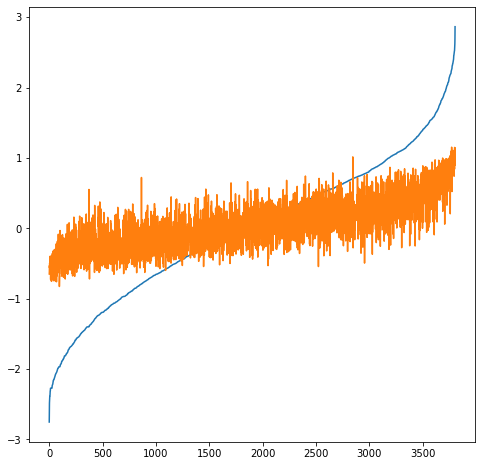

test


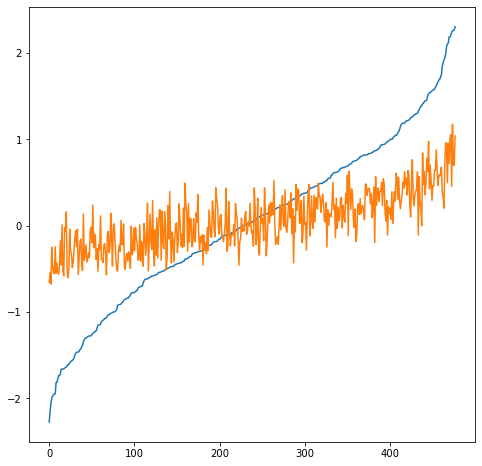

train
mape: 2276.9959005944065
mae: 66768148.49132268
rmse: 162085330.81405374
adj_r2: 0.0653737898669795
test
mape: 919.1770716478757
mae: 68196663.3056723
rmse: 155239931.12165958
adj_r2: -0.7059274029909675
train log


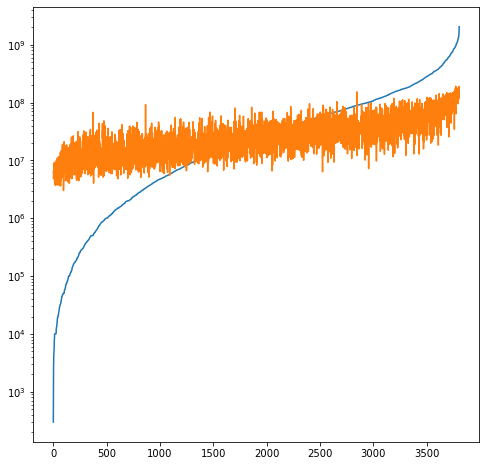

test log


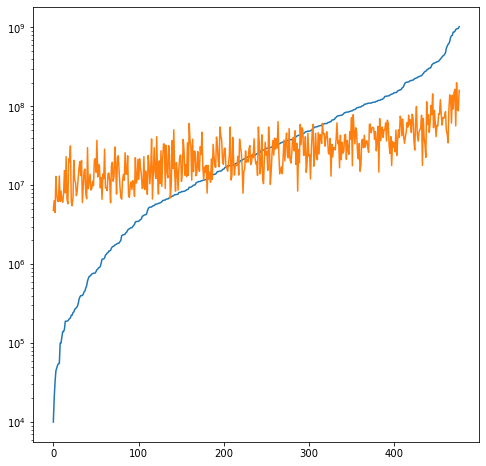

train


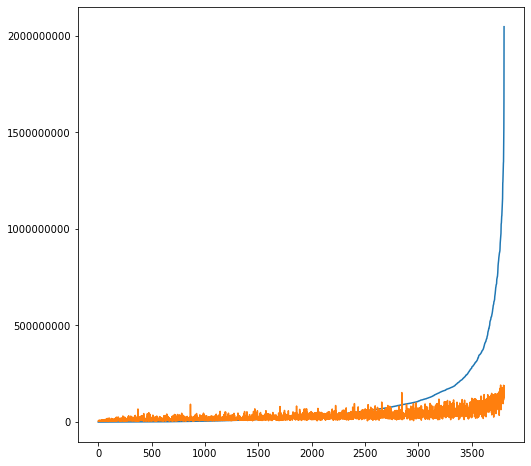

test


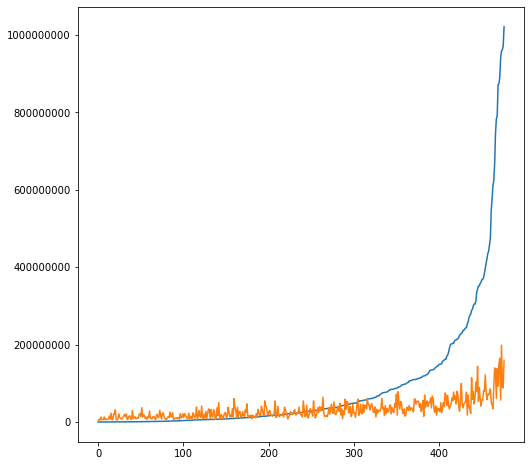

In [66]:
output_metrics(best_model, data, process)

In [ ]:
adamax = keras.optimizers.Adamax(learning_rate=0.001,beta_1=0.958,beta_2=0.987)

def build_model():
  model = tf.keras.Sequential([
    Dense(
        256, 
        activation='sigmoid', 
        input_shape=[len(data['X_train'].keys())],
        kernel_initializer='glorot_normal',
        kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
        bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
    ),
    Dropout(0.005),
    Dense(
        256, 
        activation='sigmoid',
        kernel_initializer='glorot_normal',
        kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
        bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
    ),
    Dropout(0.5),  
    Dense(
        1,
        kernel_initializer='glorot_normal',
        activation='linear'
    )
  ])

  model.compile(loss='mse',
                optimizer=adamax,
                metrics=['mae', 'mse'])
  return model

model3 = build_model()
# model3.summary()

es = EarlyStopping(
    monitor='val_loss', 
    mode='min', 
    verbose=1, 
    patience=20)

history = model3.fit(
    data['X_train'], data['y_train'],
    epochs=10000, 
    validation_data=(data['X_test'], data['y_test']),
    verbose=0,
    batch_size=256,
    shuffle=True,
    callbacks=[tfdocs.modeling.EpochDots(), es])
#     callbacks=[es])
output_metrics(model3, data, process, with_val=True)

In [ ]:
output_metrics(model3, data, process, with_val=True)

In [135]:
mape: 701.1628654644568
mae: 41859822.98122131
rmse: 92053624.95453802
adj_r2: 0.44188860358712956

In [ ]:
output_metrics(model3, data, process, with_val=True)

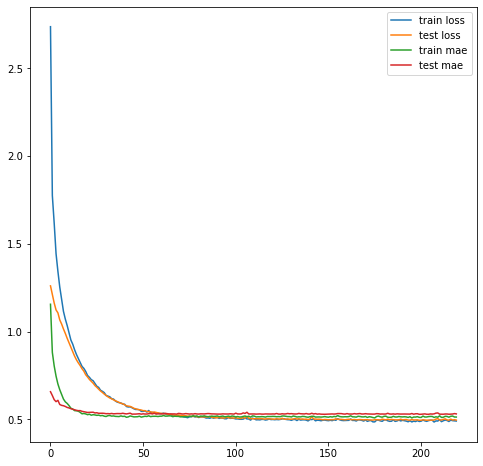

In [45]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train loss')
pyplot.plot(history.history['val_loss'], label='test loss')
pyplot.plot(history.history['mae'], label='train mae')
pyplot.plot(history.history['val_mae'], label='test mae')
pyplot.legend()
pyplot.show()

In [ ]:
# relu wo initialization

# mape: 6.6013761902604395
# mae: 47785029.21390841
# rmse: 117085745.28254725
# adj_r2: 0.2683608578800275

In [ ]:
# sigmoid

# mape: 6.921294519771364
# mae: 46309187.6036963
# rmse: 106573312.92760979
# adj_r2: 0.39384203627853387

In [ ]:
# sigmoid initialization glorot

# mape: 5.891309178898037
# mae: 45178191.806934245
# rmse: 105538830.70659108
# adj_r2: 0.40555259042845115

In [ ]:
# relu initialization he-normal

# mape: 11.22876428439224
# mae: 49985922.89351641
# rmse: 124054429.88760668
# adj_r2: 0.1786780362328163

In [ ]:
# {'Dense': 1024,
#  'Dense_1': 256,
#  'Dense_2': 1024,
#  'Dropout': 0.15106219282775246,
#  'Dropout_1': 0.6763508226311498,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.30987873188582754,
#  'batch_size': 256,
#  'choiceval': 'adam',
#  'lr': 0.001,
#  'lr_1': 0.01,
#  'lr_2': 0.1}

# mape: 14.735849474528678
# mae: 42425257.59364493
# rmse: 93314406.47801651
# adj_r2: 0.5986823964694081

In [ ]:
# {'Dense': 256,
#  'Dense_1': 1024,
#  'Dense_2': 1024,
#  'Dropout': 0.2974750265433348,
#  'Dropout_1': 0.39966419778642664,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.526026582745637,
#  'activation': 'sigmoid',
#  'activation_1': 'sigmoid',
#  'activation_2': 'sigmoid',
#  'batch_size': 128,
#  'epochs': 75,
#  'kernel_initializer': <tensorflow.python.ops.init_ops_v2.VarianceScaling at 0x7f8b393ae710>,
#  'kernel_initializer_1': <tensorflow.python.ops.init_ops_v2.GlorotUniform at 0x7f8b393f3610>,
#  'kernel_initializer_2': <tensorflow.python.ops.init_ops_v2.VarianceScaling at 0x7f8b2aec9750>,
#  'optimizer': 'adam'}

# mape: 11.930947077248565
# mae: 41936947.39355901
# rmse: 94227681.26787286
# adj_r2: 0.5117092256416581

In [ ]:
# {'Dense': 256,
#  'Dense_1': 256,
#  'Dense_2': 1024,
#  'Dropout': 0.12206225819915595,
#  'Dropout_1': 0.197064731659927,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.00029842311592569865,
#  'activation': 'sigmoid',
#  'activation_1': 'sigmoid',
#  'activation_2': 'relu',
#  'batch_size': 128,
#  'epochs': 25,
#  'kernel_initializer': 'glorot_normal',
#  'kernel_initializer_1': 'glorot_normal',
#  'kernel_initializer_2': 'glorot_uniform',
#  'optimizer': 'adam'}

# mape: 6.224157960480135
# mae: 43643280.72317956
# rmse: 99891850.23558912
# adj_r2: 0.5618906445214958

In [ ]:
# {'Dense': 512,
#  'Dense_1': 1024,
#  'Dense_2': 1024,
#  'Dropout': 0.003154114487844459,
#  'Dropout_1': 0.49453988643233404,
#  'Dropout_2': 'two',
#  'Dropout_3': 0.6057457357612506,
#  'activation': 'sigmoid',
#  'activation_1': 'sigmoid',
#  'activation_2': 'sigmoid',
#  'batch_size': 512,
#  'epochs': 100,
#  'kernel_initializer': 'glorot_normal',
#  'kernel_initializer_1': 'he_uniform',
#  'kernel_initializer_2': 'glorot_normal',
#  'optimizer': 'adam'}


# mape: 5.984611554637821
# mae: 43830607.21558445
# rmse: 99151995.47327316
# adj_r2: 0.5683563756398305

In [ ]:
# def build_model():
#   model = tf.keras.Sequential([
#     Dense(
#         512, 
#         activation='sigmoid', 
#         input_shape=[len(data['X_train'].keys())],
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
#     ),
#     Dropout(0.005),
#     Dense(
#         1024, 
#         activation='sigmoid',
#         kernel_initializer='he_uniform',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#         activity_regularizer=l1_l2(l1=0, l2=0.00001)
#     ),
#     Dropout(0.7), 
#     Dense(1)
#   ])

#   model.compile(loss='mean_squared_error',
#                 optimizer='adam',
#                 metrics=['mae', 'mean_squared_error'])
#   return model

# model3 = build_model()
# model3.summary()

# mape: 8.161095980091112
# mae: 35879531.109611064
# rmse: 87476559.6580578
# adj_r2: 0.5608763424966564

In [ ]:
# def build_model():
#   model = tf.keras.Sequential([
#     Dense(
#         256, 
#         activation='sigmoid', 
#         input_shape=[len(data['X_train'].keys())],
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
#     ),
#     Dropout(0.005),
#     Dense(
#         256, 
#         activation='sigmoid',
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#     ),
#     Dropout(0.5),  
#     Dense(1)
#   ])

#   model.compile(loss='mae',
#                 optimizer='adam',
#                 metrics=['mae', 'mean_squared_error'])
#   return model

# model3 = build_model()
# # model3.summary()

# es = EarlyStopping(
#     monitor='val_loss', 
#     mode='min', 
#     verbose=1, 
#     patience=50)

# history = model3.fit(
#     data['X_train'], data['y_train'],
#     epochs=10000, 
#     validation_data=(data['X_test'], data['y_test']),
#     verbose=1,
#     batch_size=256,
#     shuffle=True,
# #     callbacks=[tfdocs.modeling.EpochDots(), es])
#     callbacks=[es])


# mape: 5.821131932635737
# mae: 42307258.2010261
# rmse: 95281127.2382761
# adj_r2: 0.4884981254695354

In [ ]:
# skew x -> skew y

# adamax = keras.optimizers.Adamax(learning_rate=0.001,beta_1=0.95,beta_2=0.999)

# def build_model():
#   model = tf.keras.Sequential([
#     Dense(
#         256, 
#         activation='sigmoid', 
#         input_shape=[len(data['X_train'].keys())],
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
#     ),
#     Dropout(0.005),
#     Dense(
#         256, 
#         activation='sigmoid',
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#     ),
#     Dropout(0.5),  
#     Dense(
#         1,
#         kernel_initializer='glorot_normal',
#         activation='linear'
#     )
#   ])

#   model.compile(loss='mse',
#                 optimizer=adamax,
#                 metrics=['mae', 'mse'])
#   return model

# model3 = build_model()
# # model3.summary()

# es = EarlyStopping(
#     monitor='val_loss', 
#     mode='min', 
#     verbose=1, 
#     patience=20)

# history = model3.fit(
#     data['X_train'], data['y_train'],
#     epochs=1000, 
#     validation_data=(data['X_test'], data['y_test']),
#     verbose=0,
#     batch_size=256,
#     shuffle=True,
# #     callbacks=[tfdocs.modeling.EpochDots(), es])
#     callbacks=[es])

# mape: 6.094501890528896
# mae: 40504269.625439286
# rmse: 87054173.39806816
# adj_r2: 0.5730149701057303

In [ ]:
# # skew x -> skew y

# import lightgbm as lgb
# mod_lgb = lgb.LGBMRegressor(
#     objective='regression',
#     num_leaves=34,
#     learning_rate=0.001, 
#     n_estimators=7500,
#     max_bin=192,
#     max_depth=0,
#     min_child_samples=160,
#     min_child_weight=0.001,
#     bagging_fraction=0.98,
#     bagging_freq=15, 
#     feature_fraction=0.77,
#     feature_fraction_seed=9,
#     bagging_seed=9,
#     min_data_in_leaf=1, 
#     min_sum_hessian_in_leaf=50,
#     colsample_bytree=0.87,
#     reg_alpha=0.18,
#     reg_lambda=30,
#     subsample=0.39,
#     tree_learner='data',
# )
# mod_lgb.fit(
#     data['X_train'].values, 
#     data['y_train'],
#     verbose=0,
#     eval_metric='mse',
#     eval_set=[(data['X_test'], data['y_test'])],
#     early_stopping_rounds=25
# )
# output_metrics(mod_lgb, data, process, with_val=True)

# mape: 8.358551244895033
# mae: 40639301.811736666
# rmse: 83874926.05518548
# adj_r2: 0.49830307531562434

In [ ]:
# adamax = keras.optimizers.Adamax(learning_rate=0.001,beta_1=0.958,beta_2=0.987)

# def build_model():
#   model = tf.keras.Sequential([
#     Dense(
#         256, 
#         activation='sigmoid', 
#         input_shape=[len(data['X_train'].keys())],
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0.0001, l2=0.0001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.001, l2=0.1)
#     ),
#     Dropout(0.005),
#     Dense(
#         256, 
#         activation='sigmoid',
#         kernel_initializer='glorot_normal',
#         kernel_regularizer=keras.regularizers.l1_l2(l1=0, l2=0.001),
#         bias_regularizer=keras.regularizers.l1_l2(l1=0.01, l2=0.01),
#     ),
#     Dropout(0.5),  
#     Dense(
#         1,
#         kernel_initializer='glorot_normal',
#         activation='linear'
#     )
#   ])

#   model.compile(loss='mse',
#                 optimizer=adamax,
#                 metrics=['mae', 'mse'])
#   return model

# model3 = build_model()
# # model3.summary()

# es = EarlyStopping(
#     monitor='val_loss', 
#     mode='min', 
#     verbose=1, 
#     patience=20)

# history = model3.fit(
#     data['X_train'], data['y_train'],
#     epochs=10000, 
#     validation_data=(data['X_test'], data['y_test']),
#     verbose=0,
#     batch_size=256,
#     shuffle=True,
#     callbacks=[tfdocs.modeling.EpochDots(), es])
# #     callbacks=[es])


# mape: 715.0661530743256
# mae: 41755141.579565056
# rmse: 91255901.0566581
# adj_r2: 0.45151972233459114

In [ ]:
# import lightgbm as lgb
# mod_lgb = lgb.LGBMRegressor(
#     objective='regression',
#     num_leaves=34,
#     learning_rate=0.001, 
#     n_estimators=7500,
#     max_bin=192,
#     max_depth=0,
#     min_child_samples=160,
#     min_child_weight=0.001,
#     bagging_fraction=0.98,
#     bagging_freq=15, 
#     feature_fraction=0.77,
#     metric='l2',
#     bagging_seed=9,
#     min_data_in_leaf=1, 
#     min_sum_hessian_in_leaf=50,
#     colsample_bytree=0.87,
#     reg_alpha=0.18,
#     reg_lambda=30,
#     subsample=0.39,
#     tree_learner='data',
# )
# mod_lgb.fit(
#     data['X_train'].values, 
#     data['y_train'],
#     verbose=2,
#     eval_metric='mse',
#     eval_set=[(data['X_test'], data['y_test'])],
#     early_stopping_rounds=50
# )
# output_metrics(mod_lgb, data, process, with_val=True)